# 3-Segment Shuffle + Scale (10-50%) + Angular Perturbation Analysis

## Overview

This notebook analyzes the effect of **angular perturbations** on track classification when combined with **3-segment shuffle** and **per-segment scaling (10-50%)**. The goal is to determine how different levels of angular noise affect the stability of population classification while keeping the shuffle and scaling parameters fixed.

## Augmentation Method

### Combined Augmentation Strategy

The augmentation applied to each track combines three operations:

1. **3-Segment Shuffle**: Divide track into 3 equal segments and randomly reorder them
   ```
   Original:    [Segment1]-[Segment2]-[Segment3]
   Augmented:   [Segment3]-[Segment1]-[Segment2]  (random permutation)
   ```

2. **Per-Segment Scaling (10-50% variation)**: Each segment is independently scaled
   - **Shrink**: Randomly scale to 50-90% of original size (scale factor 0.5-0.9)
   - **Grow**: Randomly scale to 110-150% of original size (scale factor 1.1-1.5)
   - Each segment randomly chooses shrink OR grow, then a value within that range
   - **Guaranteed range**: Ensures meaningful variation (not near-identity)

3. **Per-Step Angular Perturbation**: Each displacement step gets angular deviation
   - Convert displacement to polar coordinates (r, θ)
   - Add random angular noise: `θ_new = θ + sign × uniform(min_deg, max_deg)`
   - Random sign ensures both clockwise and counterclockwise deviations
   - **Guaranteed minimum**: Each step gets at least `min_deg` degrees of deviation

### Configuration

- **Fixed Parameters**:
  - Number of segments: **3** (fixed for all augmentations)
  - Scaling range: **(0.5, 1.5)** → ±10-50% variation per segment
  
- **Variable Parameter** (titrated):
  - Angular perturbation range: Tested at multiple levels
    - `a0`: No angle perturbation (baseline)
    - `a1_5`: 1-5° (very mild)
    - `a5_10`: 5-10° (mild)
    - `a20_30`: 20-30° (moderate)
    - `a50_60`: 50-60° (strong)
    - `a80_90`: 80-90° (extreme)

## Augmentation Naming Convention

Format: `shuf_3s_s10_50_a{angle_range}`

- `shuf_3s`: 3-segment shuffle (fixed)
- `s10_50`: ±10-50% scaling (fixed, scale_range = 0.5 to 1.5)
- `a{range}`: Angular perturbation range in degrees

**Examples**:
- `shuf_3s_s10_50_a0`: 3-seg shuffle + ±10-50% scale (no angle) - baseline
- `shuf_3s_s10_50_a1_5`: 3-seg shuffle + ±10-50% scale + 1-5° angle
- `shuf_3s_s10_50_a5_10`: 3-seg shuffle + ±10-50% scale + 5-10° angle
- `shuf_3s_s10_50_a20_30`: 3-seg shuffle + ±10-50% scale + 20-30° angle
- `shuf_3s_s10_50_a50_60`: 3-seg shuffle + ±10-50% scale + 50-60° angle
- `shuf_3s_s10_50_a80_90`: 3-seg shuffle + ±10-50% scale + 80-90° angle

## Analysis Goals

1. **Stability Testing**: Measure how often augmented tracks maintain their original population classification
2. **Angular Sensitivity**: Determine at what angular perturbation level classification becomes unstable
3. **Augmentation Selection**: Identify the optimal angular perturbation range for contrastive learning
   - Need sufficient diversity for training
   - Must preserve enough structure to maintain classification stability

## Key Features

- **Guaranteed Minimums**: Both scaling and angular perturbation have guaranteed minimum values (not uniform random)
  - Ensures meaningful augmentation (not near-identity transformations)
  - Provides controlled, reproducible variation
  
- **Segment-Level Operations**: Scaling and shuffling operate on segments, preserving local motion patterns within each segment

- **Step-Level Angular Noise**: Angular perturbation applied to each displacement step, providing fine-grained directional variation

## Final Settled Configuration

After analysis, the settled augmentation for contrastive learning is:
- **3-segment shuffle**
- **10-50% scaling** (scale_range = (0.5, 1.5))
- **1-10° angular perturbation** (angle_range = (1, 10))

This configuration is implemented in `SPTnano.augmentations.apply_augmentation_for_training()`

---

**Note**: Run cells 1-12 in order. Each cell is labeled with its function.

# Augmentation Methods Overview

## 1. SEGMENT SHUFFLE (shuffle_Nseg)
Split track into N equal segments, randomly reorder them.

```
Original:    [A]-[B]-[C]-[D]    (4 segments)
Augmented:   [C]-[A]-[D]-[B]    (random permutation)

Severity ↑ (more segments):
  2seg:  [██████]-[██████]           → Mild (only 2 pieces to swap)
  4seg:  [███]-[███]-[███]-[███]     → Moderate  
  12seg: [█][█][█][█][█][█]...       → Extreme (many tiny pieces)
```
**Effect**: More segments = more disruption to trajectory continuity, but preserves local motion patterns within each segment.

---

## 2. SHUFFLE WITH REVERSAL (shuffle_rev_Nseg_P%)
Split into N segments, shuffle, AND reverse P% of segments.

```
Original:    [A→]-[B→]-[C→]-[D→]
Augmented:   [C→]-[←A]-[D→]-[←B]   (some segments reversed)

Severity ↑:
  shuffle_rev_4seg_25:  25% of segments reversed
  shuffle_rev_4seg_50:  50% of segments reversed
  shuffle_rev_6seg_50:  More segments + 50% reversed
```
**Effect**: Reversal changes local velocity direction within segments. Higher % = more direction changes.

---

## 3. CIRCULAR PERMUTATION (circular_P%)
Shift the starting point by P% of track length (like rotating a ring).

```
Original:    [A]-[B]-[C]-[D]
circular_25: [B]-[C]-[D]-[A]    (shift by 25%)
circular_50: [C]-[D]-[A]-[B]    (shift by 50%)

Severity ↑:
  circular_25:    Shift by 25% of track length
  circular_50:    Shift by 50% (most different start point)
  circular_random: Random shift amount
```
**Effect**: MILDEST augmentation - preserves ALL temporal relationships, just changes start point. Perfect for rotation-invariant training.

---

## 4. ADJACENT SWAP (adjacent_Nswap)
Swap N pairs of adjacent segments (gentler than full shuffle).

```
Original:    [A]-[B]-[C]-[D]-[E]-[F]
adjacent_1:  [B]-[A]-[C]-[D]-[E]-[F]    (swap 1 pair)
adjacent_2:  [B]-[A]-[D]-[C]-[E]-[F]    (swap 2 pairs)
adjacent_3:  [B]-[A]-[D]-[C]-[F]-[E]    (swap 3 pairs)

Severity ↑:
  adjacent_1swap: 1 pair swapped → very mild
  adjacent_2swap: 2 pairs swapped → mild
  adjacent_3swap: 3 pairs swapped → moderate
```
**Effect**: Localized disruption - maintains most of the trajectory flow. Good for subtle augmentation.

---

## Summary Table

| Method | Disruption | Preserves | Best For |
|--------|-----------|-----------|----------|
| circular | Very Low | All temporal relationships | Start-point invariance |
| adjacent_1-2 | Low | Most trajectory flow | Subtle augmentation |
| shuffle_2-3seg | Moderate | Local motion in segments | Balanced augmentation |
| shuffle_4-6seg | High | Smaller local patterns | Aggressive augmentation |
| shuffle_rev_* | Very High | Very little | Stress-testing |
| shuffle_10-12seg | Extreme | Almost nothing | Edge case testing |

In [ ]:
# [1] IMPORTS
import sys; sys.path.append('../src')
import numpy as np, pandas as pd, polars as pl, matplotlib.pyplot as plt, os, warnings, scipy.optimize
from matplotlib.patches import Rectangle, Polygon, Circle
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
from tqdm.notebook import tqdm
import SPTnano as spt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# [5] HELPER FUNCTIONS
# NOTE: These functions are now available in SPTnano.helper_scripts
# Import them here for use in this notebook
from SPTnano.helper_scripts import (
    parse_window_uid,
    get_window_frames,
    calc_intersections,
    compute_features,
    has_complete_frames
)

# [5B] AUGMENTATION FUNCTIONS
# NOTE: The augmentation function is now available in SPTnano.augmentations
# Import it here for use in this notebook
from SPTnano.augmentations import (
    aug_shuffle_scale_noise,
    apply_augmentation_for_training
)

print('Helper functions imported from SPTnano.helper_scripts')
print('Augmentation functions imported from SPTnano.augmentations')

print('Imports done')

Config module loaded. Master directory is: D:/TRANSFORMER_DEVELOPMENT/
Imports done


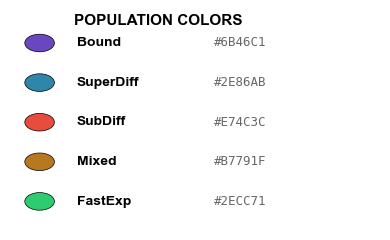

In [2]:
# [2] POPULATION COLORS KEY
POP_COLORS = {
    'bound_stationary': '#6B46C1',
    'superdiffusive_transport': '#2E86AB',
    'subdiffusive_motion': '#E74C3C',
    'mixed_exploratory_bound': '#B7791F',
    'fast_exploratory': '#2ECC71',
    'ungatedgate1': '#AAAAAA',
    'ungatedgate2': '#AAAAAA',
    'unknown': '#888888',
}
POP_ABBREV = {
    'bound_stationary': 'Bound',
    'superdiffusive_transport': 'SuperDiff',
    'subdiffusive_motion': 'SubDiff',
    'mixed_exploratory_bound': 'Mixed',
    'fast_exploratory': 'FastExp',
}
POP_ORDER = ['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', 'mixed_exploratory_bound', 'fast_exploratory']

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.axis('off')
for i, pop in enumerate(POP_ORDER):
    y = 0.85 - i*0.18
    ax.add_patch(Circle((0.08, y), 0.04, fc=POP_COLORS[pop], ec='black', lw=0.5))
    ax.text(0.18, y, POP_ABBREV[pop], fontsize=10, fontweight='bold', va='center')
    ax.text(0.55, y, POP_COLORS[pop], fontsize=9, va='center', family='monospace', color='#666')
ax.text(0.4, 0.98, 'POPULATION COLORS', fontsize=11, fontweight='bold', va='top', ha='center')
plt.tight_layout()
plt.show()

In [3]:
# DIAG-2: Check colors defined
print("DIAG-2: Population colors check")
print(f"  POP_COLORS keys: {list(POP_COLORS.keys())}")
print(f"  POP_ORDER: {POP_ORDER}")
print(f"  All 5 pops in POP_COLORS? {all(p in POP_COLORS for p in POP_ORDER)}")

DIAG-2: Population colors check
  POP_COLORS keys: ['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', 'mixed_exploratory_bound', 'fast_exploratory', 'ungatedgate1', 'ungatedgate2', 'unknown']
  POP_ORDER: ['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', 'mixed_exploratory_bound', 'fast_exploratory']
  All 5 pops in POP_COLORS? True


In [4]:
# [3] CONFIGURATION
DATA_DRIVE = 'F:'
DATA_DIR = f'{DATA_DRIVE}/Analyzed/HIERARCHICAL_GATES_20260119_102840'
INSTANT_DF_PATH = os.path.join(DATA_DIR, 'instant_df_hierarchical_gates.parquet')
WINDOWED_DF_PATH = os.path.join(DATA_DIR, 'windowed_df_hierarchical_gates.parquet')
OUTPUT_FOLDER = Path('D:/TRANSFORMER_DEVELOPMENT/plots/shuffle_scale_analysis')
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)
N_TRACKS_PER_POP, N_TRACKS_VIZ, SEED = 60, 1, 42
np.random.seed(SEED)
GATE1_RECTS = {
    'low_speed_low_intersections': {'x': (0.0, 0.2), 'y': (0.0, 0.14), 'color': '#6B46C1'},
    'high_speed_low_intersections': {'x': (0.2, 1.0), 'y': (0.0, 0.14), 'color': '#2E86AB'},
    'low_speed_high_intersections': {'x': (0.0, 0.3), 'y': (0.14, 1.0), 'color': '#B7791F'},
    'high_speed_high_intersections': {'x': (0.3, 1.0), 'y': (0.14, 1.0), 'color': '#2ECC71'},
}
# NOTE: cum_disp goes up to ~28, so set upper y-bound to 30!
# Diagonal boundary from (1.1, 0) to (2.825, 30), extended to y=30
GATE2_BOUNDS = {
    'superdiffusive': [(1.1, 0.0), (2.825, 30.0), (3.0, 30.0), (3.0, 0.0)],
    'subdiffusive': [(-0.5, 0.0), (-0.5, 30.0), (2.825, 30.0), (1.1, 0.0)],
}
print(f'Data: {DATA_DIR}')

Data: F:/Analyzed/HIERARCHICAL_GATES_20260119_102840


In [5]:
# [4] LOAD DATA
instant_df = pl.read_parquet(INSTANT_DF_PATH)
windowed_df = pl.read_parquet(WINDOWED_DF_PATH)
instant_df = instant_df.with_columns(pl.col('foldername').str.replace('Z:', DATA_DRIVE))
windowed_df = windowed_df.with_columns(pl.col('foldername').str.replace('Z:', DATA_DRIVE))
windowed_df = windowed_df.filter(pl.col('bad_fit_flag') == False)
windowed_df = windowed_df.filter(~pl.col('final_population').str.contains('ungated'))
valid_uids = windowed_df['window_uid'].unique().to_list()
instant_df = instant_df.filter(pl.col('window_uid').is_in(valid_uids))
print(f'Windowed: {windowed_df.shape}, Instant: {instant_df.shape}')
print(windowed_df.group_by('final_population').agg(pl.len().alias('n')).sort('n', descending=True))

Windowed: (913237, 68), Instant: (34985130, 51)
shape: (5, 2)
┌──────────────────────────┬────────┐
│ final_population         ┆ n      │
│ ---                      ┆ ---    │
│ str                      ┆ u32    │
╞══════════════════════════╪════════╡
│ fast_exploratory         ┆ 557990 │
│ bound_stationary         ┆ 214035 │
│ subdiffusive_motion      ┆ 93908  │
│ mixed_exploratory_bound  ┆ 30863  │
│ superdiffusive_transport ┆ 16441  │
└──────────────────────────┴────────┘


In [6]:
# DIAG-4: Check data loaded correctly
print("DIAG-4: Data loading check")
print(f"  instant_df shape: {instant_df.shape}")
print(f"  windowed_df shape: {windowed_df.shape}")
print(f"  windowed_df populations:")
for p, n in windowed_df.group_by('final_population').agg(pl.len().alias('n')).sort('n', descending=True).iter_rows():
    print(f"    {p}: {n:,}")
print(f"  All 5 target pops present? {all(p in windowed_df['final_population'].unique().to_list() for p in POP_ORDER)}")

DIAG-4: Data loading check
  instant_df shape: (34985130, 51)
  windowed_df shape: (913237, 68)
  windowed_df populations:
    fast_exploratory: 557,990
    bound_stationary: 214,035
    subdiffusive_motion: 93,908
    mixed_exploratory_bound: 30,863
    superdiffusive_transport: 16,441
  All 5 target pops present? True


In [ ]:

# # ============================================================================
# # OLD FUNCTION DEFINITIONS (kept for verification - can be removed after testing)
# # ============================================================================
# # These are kept temporarily to verify the imported functions work correctly
# # Once verified, these can be deleted

# def parse_window_uid_old(wuid):
#     parts = wuid.rsplit('_', 2)
#     return '_'.join(parts[:-2]).rsplit('_', 1)[0], int(float(parts[-2])), int(float(parts[-1]))

# def get_window_frames_old(df, wuid):
#     uid, fs, fe = parse_window_uid_old(wuid)
#     return df.filter((pl.col('unique_id') == uid) & (pl.col('frame') >= fs) & (pl.col('frame') <= fe)).sort('frame')

# def calc_intersections_old(x, y):
#     n = len(x)
#     if n < 4: return 0
#     pts = np.column_stack([x, y])
#     ccw = lambda a,b,c: (c[1]-a[1])*(b[0]-a[0]) > (b[1]-a[1])*(c[0]-a[0])
#     intersect = lambda a,b,c,d: ccw(a,c,d) != ccw(b,c,d) and ccw(a,b,c) != ccw(a,b,d)
#     return sum(1 for i in range(n-1) for j in range(i+2, n-1) if intersect(pts[i], pts[i+1], pts[j], pts[j+1]))

# def compute_features_old(x, y, dt_arr):
#     dx, dy = np.diff(x), np.diff(y)
#     steps = np.sqrt(dx**2 + dy**2)
#     dta = np.asarray(dt_arr)[1:] if not np.isscalar(dt_arr) else dt_arr
#     if not np.isscalar(dt_arr): dta = np.where((dta == 0) | np.isnan(dta), 1e-10, dta)
#     speeds = steps / dta if np.isscalar(dta) else steps / dta
#     dt = dt_arr if np.isscalar(dt_arr) else np.nanmedian(dta)
#     n = len(x)
#     lags = np.arange(1, n) * dt
#     msd = np.array([np.mean((x[l:]-x[:-l])**2 + (y[l:]-y[:-l])**2) for l in range(1, n)])
#     try:
#         popt, _ = scipy.optimize.curve_fit(lambda t,D,a: 4*D*np.power(t,a), lags, msd, p0=[0.1,1], bounds=([0,0],[np.inf,3]), maxfev=5000)
#         alpha = popt[1]
#     except:
#         v = (lags > 0) & (msd > 0)
#         alpha = np.polyfit(np.log(lags[v]), np.log(msd[v]), 1)[0] if np.sum(v) >= 2 else 1.0
#     return {'avg_speed_um_s': np.mean(speeds), 'cum_displacement_um': np.sum(steps), 'self_intersections': calc_intersections_old(x,y), 'anomalous_exponent': alpha}

# def has_complete_frames_old(df, wuid):
#     uid, fs, fe = parse_window_uid_old(wuid)
#     return df.filter((pl.col('unique_id') == uid) & (pl.col('frame') >= fs) & (pl.col('frame') <= fe)).height == fe - fs + 1

Helper functions imported from SPTnano.helper_scripts
Augmentation functions imported from SPTnano.augmentations


In [13]:
# [6] SHUFFLE + SCALE + ANGULAR PERTURBATION AUGMENTATIONS
# Goal: 3-segment shuffle + per-segment scale (±10-50%) + per-step angular perturbation
# This tests how angular perturbations affect track classification while keeping shuffle and scale fixed

# NOTE: aug_shuffle_scale_noise is now imported from SPTnano.augmentations (see cell 7)
# The function definition below is kept temporarily for verification

# def aug_shuffle_scale_noise_old(x, y, nseg, scale_range, angle_range, seed):
#     """
#     3-segment shuffle + random scale per segment + angular perturbation per step.
    
#     Args:
#         x, y: Track coordinates
#         nseg: Number of segments (3 - fixed for this analysis)
#         scale_range: (min_scale, max_scale) tuple - GUARANTEED range!
#                      e.g. (0.5, 1.5) means shrink to 50-90% OR grow to 110-150%
#                      Randomly picks shrink OR grow for each segment, then value within range
#         angle_range: (min_deg, max_deg) tuple - GUARANTEED range!
#                      e.g. (5, 10) means each step gets 5-10° deviation (random sign)
#                      (0, 0) = no angle perturbation
#         seed: Random seed for reproducibility
    
#     Process:
#         1. Split track into 3 segments
#         2. Scale each segment by random factor within ±10-50% (guaranteed in range!)
#         3. Shuffle segment order
#         4. Add angular perturbation to EACH step (guaranteed in range!)
#     """
#     np.random.seed(seed)
#     n = len(x)
    
#     # Get displacements
#     dx = np.diff(x, prepend=x[0])
#     dy = np.diff(y, prepend=y[0])
    
#     # Split into segments and scale
#     ss = n // nseg
#     segs = []
#     for i in range(nseg):
#         start = i * ss
#         end = (i + 1) * ss if i < nseg - 1 else n
#         sdx = dx[start:end].copy()
#         sdy = dy[start:end].copy()
        
#         # GUARANTEED scale: randomly pick shrink or grow, then value in range
#         # For ±10-50%: scale_range = (0.5, 1.5)
#         #   Shrink: 50-90% of original (scale 0.5-0.9)
#         #   Grow: 110-150% of original (scale 1.1-1.5)
#         min_s, max_s = scale_range
#         if np.random.random() < 0.5:
#             # Shrink: 50-90% (scale 0.5-0.9)
#             scale = np.random.uniform(min_s, 0.9)
#         else:
#             # Grow: 110-150% (scale 1.1-1.5)
#             scale = np.random.uniform(1.1, max_s)
#         sdx *= scale
#         sdy *= scale
        
#         segs.append((sdx, sdy))
    
#     # Shuffle segment order
#     idx = np.arange(nseg)
#     np.random.shuffle(idx)
    
#     # Reconstruct from shuffled, scaled segments
#     new_dx = np.concatenate([segs[i][0] for i in idx])
#     new_dy = np.concatenate([segs[i][1] for i in idx])
    
#     # Add angular noise - GUARANTEED minimum!
#     min_ang, max_ang = angle_range
#     if max_ang > 0:
#         min_rad = np.deg2rad(min_ang)
#         max_rad = np.deg2rad(max_ang)
#         # Convert to polar
#         r = np.sqrt(new_dx**2 + new_dy**2)
#         theta = np.arctan2(new_dy, new_dx)
#         # Random magnitude in [min, max] with random sign
#         magnitudes = np.random.uniform(min_rad, max_rad, size=len(theta))
#         signs = np.random.choice([-1, 1], size=len(theta))
#         noise = magnitudes * signs
#         theta_noisy = theta + noise
#         # Convert back to cartesian
#         new_dx = r * np.cos(theta_noisy)
#         new_dy = r * np.sin(theta_noisy)
    
#     return np.cumsum(new_dx), np.cumsum(new_dy)

# # Reference: shuffle only (no scale, no noise)
# def aug_shuffle(x, y, nseg, seed):
#     np.random.seed(seed); n = len(x)
#     dx, dy = np.diff(x, prepend=x[0]), np.diff(y, prepend=y[0])
#     ss = n // nseg
#     segs = [(dx[i*ss:(i+1)*ss if i<nseg-1 else n].copy(), dy[i*ss:(i+1)*ss if i<nseg-1 else n].copy()) for i in range(nseg)]
#     idx = np.arange(nseg); np.random.shuffle(idx)
#     return np.cumsum(np.concatenate([segs[i][0] for i in idx])), np.cumsum(np.concatenate([segs[i][1] for i in idx]))

# ============================================================================
# OLD CONFIGURATIONS: SHUFFLE + SCALE + ANGULAR NOISE TITRATION (COMMENTED OUT)
# ============================================================================
# Fixed: 4 segments
# Scale: (min, max) - segments randomly shrink OR grow within guaranteed range
# Angle: (min, max) - each step gets angle in this range (with random ± sign)
#
# KEY: Both scale and angle have GUARANTEED MINIMUMS!
#      'a5_10' means each step gets 5-10° deviation (not 0-10°)

# SEGMENT_SHUFFLE_CONFIG = {
#     # NO NOISE (scale only) - baseline for comparison
#     'shuf_s50_a0': {'f': 'ssn', 'n': 4, 'scale': (0.50, 1.50), 'angle': (0, 0)},
#     
#     # MILD angular noise: 2-5°, 5-10°
#     'shuf_s50_a2_5': {'f': 'ssn', 'n': 4, 'scale': (0.50, 1.50), 'angle': (2, 5)},
#     'shuf_s50_a5_10': {'f': 'ssn', 'n': 4, 'scale': (0.50, 1.50), 'angle': (5, 10)},
#     
#     # MODERATE angular noise: 10-15°, 15-20°
#     'shuf_s50_a10_15': {'f': 'ssn', 'n': 4, 'scale': (0.50, 1.50), 'angle': (10, 15)},
#     'shuf_s50_a15_20': {'f': 'ssn', 'n': 4, 'scale': (0.50, 1.50), 'angle': (15, 20)},
#     
#     # AGGRESSIVE angular noise: 20-25°, 25-30°
#     'shuf_s50_a20_25': {'f': 'ssn', 'n': 4, 'scale': (0.50, 1.50), 'angle': (20, 25)},
#     'shuf_s50_a25_30': {'f': 'ssn', 'n': 4, 'scale': (0.50, 1.50), 'angle': (25, 30)},
#     
#     # REFERENCE: shuffle only (no scale, no noise)
#     'shuf_only': {'f': 'shuffle', 'n': 4},
# }
# 
# SEGMENT_GROUPS = {
#     'No noise (scale only)': ['shuf_s50_a0'],
#     'Mild (2-10°)': ['shuf_s50_a2_5', 'shuf_s50_a5_10'],
#     'Moderate (10-20°)': ['shuf_s50_a10_15', 'shuf_s50_a15_20'],
#     'Aggressive (20-30°)': ['shuf_s50_a20_25', 'shuf_s50_a25_30'],
#     'Reference (shuffle only)': ['shuf_only'],
# }

# ============================================================================
# CONFIGURATION: 3-SEGMENT SHUFFLE + SCALE (10-50%) + ANGULAR PERTURBATION
# ============================================================================
# Fixed: 3 segments for all augmentations
# Fixed: Per-segment scaling of ±10-50% (scale_range = 0.5 to 1.5)
#        Each segment randomly gets: shrink to 50-90% OR grow to 110-150%
# Variable: Angular perturbation ranges (applied to each step within segments)
#        - 5-10°: Mild angle changes
#        - 20-30°: Moderate angle changes  
#        - 50-60°: Strong angle changes
#        - 80-90°: Extreme angle changes
#
# Naming convention: shuf_3s_s10_50_a{angle_range}
#   - shuf_3s: 3-segment shuffle (fixed)
#   - s10_50: ±10-50% scaling (fixed)
#   - a{range}: Angular perturbation range in degrees

SEGMENT_SHUFFLE_CONFIG = {
    # Baseline: 3-segment shuffle + ±10-50% scale (no angle perturbation)
    'shuf_3s_s10_50_a0': {'f': 'ssn', 'n': 3, 'scale': (0.5, 1.5), 'angle': (0, 0)},
    
    # Angular perturbation sweeps (all with 3-seg shuffle + ±10-50% scale)
    'shuf_3s_s10_50_a1_5': {'f': 'ssn', 'n': 3, 'scale': (0.5, 1.5), 'angle': (1, 5)},
    'shuf_3s_s10_50_a5_10': {'f': 'ssn', 'n': 3, 'scale': (0.5, 1.5), 'angle': (5, 10)},
    'shuf_3s_s10_50_a20_30': {'f': 'ssn', 'n': 3, 'scale': (0.5, 1.5), 'angle': (20, 30)},
    'shuf_3s_s10_50_a50_60': {'f': 'ssn', 'n': 3, 'scale': (0.5, 1.5), 'angle': (50, 60)},
    'shuf_3s_s10_50_a80_90': {'f': 'ssn', 'n': 3, 'scale': (0.5, 1.5), 'angle': (80, 90)},
}

# Group augmentations by angular perturbation level
SEGMENT_GROUPS = {
    'Baseline (no angle)': ['shuf_3s_s10_50_a0'],
    'Very Mild (1-5°)': ['shuf_3s_s10_50_a1_5'],
    'Mild (5-10°)': ['shuf_3s_s10_50_a5_10'],
    'Moderate (20-30°)': ['shuf_3s_s10_50_a20_30'],
    'Strong (50-60°)': ['shuf_3s_s10_50_a50_60'],
    'Extreme (80-90°)': ['shuf_3s_s10_50_a80_90'],
}

# Helper function to get augmentation description for annotations
def get_scale_description(aug_name):
    """Get human-readable description of augmentation for plot annotations."""
    desc_map = {
        'shuf_3s_s10_50_a0': '3-seg shuffle + ±10-50% scale (no angle)',
        'shuf_3s_s10_50_a1_5': '3-seg shuffle + ±10-50% scale + 1-5° angle',
        'shuf_3s_s10_50_a5_10': '3-seg shuffle + ±10-50% scale + 5-10° angle',
        'shuf_3s_s10_50_a20_30': '3-seg shuffle + ±10-50% scale + 20-30° angle',
        'shuf_3s_s10_50_a50_60': '3-seg shuffle + ±10-50% scale + 50-60° angle',
        'shuf_3s_s10_50_a80_90': '3-seg shuffle + ±10-50% scale + 80-90° angle',
    }
    return desc_map.get(aug_name, aug_name)

# Helper function to get short label for plots
def get_scale_label(aug_name):
    """Get short label for plot annotations."""
    label_map = {
        'shuf_3s_s10_50_a0': 'No angle',
        'shuf_3s_s10_50_a1_5': '1-5°',
        'shuf_3s_s10_50_a5_10': '5-10°',
        'shuf_3s_s10_50_a20_30': '20-30°',
        'shuf_3s_s10_50_a50_60': '50-60°',
        'shuf_3s_s10_50_a80_90': '80-90°',
    }
    return label_map.get(aug_name, aug_name)

def apply_aug(x, y, name, seed):
    c = SEGMENT_SHUFFLE_CONFIG[name]
    if c['f'] == 'ssn':  # shuffle + scale + noise
        return aug_shuffle_scale_noise(x, y, c['n'], c['scale'], c['angle'], seed)
    elif c['f'] == 'shuffle':
        return aug_shuffle(x, y, c['n'], seed)
    raise ValueError(f"Unknown augmentation function: {c['f']}")

print(f'Defined {len(SEGMENT_SHUFFLE_CONFIG)} augmentations:')
for name, cfg in SEGMENT_SHUFFLE_CONFIG.items():
    if cfg['f'] == 'ssn':
        print(f"  {name}: 3-seg shuffle + scale {cfg['scale']} + angle ±{cfg['angle']}°")
    else:
        print(f"  {name}: 3-seg shuffle only (reference)")

Defined 6 augmentations:
  shuf_3s_s10_50_a0: 3-seg shuffle + scale (0.5, 1.5) + angle ±(0, 0)°
  shuf_3s_s10_50_a1_5: 3-seg shuffle + scale (0.5, 1.5) + angle ±(1, 5)°
  shuf_3s_s10_50_a5_10: 3-seg shuffle + scale (0.5, 1.5) + angle ±(5, 10)°
  shuf_3s_s10_50_a20_30: 3-seg shuffle + scale (0.5, 1.5) + angle ±(20, 30)°
  shuf_3s_s10_50_a50_60: 3-seg shuffle + scale (0.5, 1.5) + angle ±(50, 60)°
  shuf_3s_s10_50_a80_90: 3-seg shuffle + scale (0.5, 1.5) + angle ±(80, 90)°


In [14]:
# [7] SELECT PARENTS
selected_parents = {}
for pop in POP_ORDER:
    uids = windowed_df.filter(pl.col('final_population') == pop)['window_uid'].to_list()
    np.random.shuffle(uids)
    complete = []
    for u in uids:
        if has_complete_frames(instant_df, u):
            complete.append(u)
            if len(complete) >= N_TRACKS_PER_POP:
                break
    selected_parents[pop] = complete
    print(f'{pop}: {len(complete)}')
all_parent_uids = [u for uids in selected_parents.values() for u in uids]
print(f'Total: {len(all_parent_uids)}')

bound_stationary: 60
superdiffusive_transport: 60
subdiffusive_motion: 60
mixed_exploratory_bound: 60
fast_exploratory: 60
Total: 300


In [15]:
# DIAG-7: Check parent selection
print("DIAG-7: Parent selection check")
print(f"  selected_parents by population:")
for p in POP_ORDER:
    n = len(selected_parents.get(p, []))
    print(f"    {p}: {n} tracks")
print(f"  Total parent UIDs: {len(all_parent_uids)}")
print(f"  Sample UIDs: {all_parent_uids[:3] if all_parent_uids else 'NONE'}")

DIAG-7: Parent selection check
  selected_parents by population:
    bound_stationary: 60 tracks
    superdiffusive_transport: 60 tracks
    subdiffusive_motion: 60 tracks
    mixed_exploratory_bound: 60 tracks
    fast_exploratory: 60 tracks
  Total parent UIDs: 300
  Sample UIDs: ['nch1h_nch1x_25_8450_R2_R2_1_3878.0_3937.0', 'nch2h_45_34302_R1_11_1736.0_1795.0', 'nvh1h_nvh1x_19_11584_R2_R2_21_631.0_690.0']


In [16]:
# DIAG-7: Check parent selection
print("="*70)
print("DIAG-7: PARENT SELECTION CHECK")
print("="*70)
print(f"N_TRACKS_PER_POP = {N_TRACKS_PER_POP}")
print(f"\nSelected parents by ORIGINAL population:")
for p in POP_ORDER:
    n = len(selected_parents.get(p, []))
    sample = selected_parents.get(p, [])[:2]
    print(f"  {p}: {n} tracks")
    if sample:
        print(f"    Sample: {sample[0][:40]}...")
print(f"\nTotal all_parent_uids: {len(all_parent_uids)}")

DIAG-7: PARENT SELECTION CHECK
N_TRACKS_PER_POP = 60

Selected parents by ORIGINAL population:
  bound_stationary: 60 tracks
    Sample: nch1h_nch1x_25_8450_R2_R2_1_3878.0_3937....
  superdiffusive_transport: 60 tracks
    Sample: eekhw_54_24536_R1_7_211.0_270.0...
  subdiffusive_motion: 60 tracks
    Sample: nch7h_95_55047_R1_42_3568.0_3627.0...
  mixed_exploratory_bound: 60 tracks
    Sample: ncmrw_21_8918_R1_2_3210.0_3269.0...
  fast_exploratory: 60 tracks
    Sample: eekhw_22_13871_R1_1_1983.0_2042.0...

Total all_parent_uids: 300


In [17]:
# [8] APPLY AUGMENTATIONS & CALCULATE FEATURES
child_records = []
for pop, puids in tqdm(selected_parents.items(), desc='Pops'):
    for puid in tqdm(puids, desc=f'{pop[:10]}', leave=False):
        tdf = get_window_frames(instant_df, puid)
        if tdf.height == 0: continue
        x, y, dt = tdf['x_um'].to_numpy(), tdf['y_um'].to_numpy(), tdf['delta_time_s'].to_numpy()
        # Recalculated baseline
        feat = compute_features(x, y, dt)
        child_records.append({'window_uid': f'{puid}_recalculated', 'parent_uid': puid, 'track_type': 'recalculated', 'original_population': pop, **feat})
        # Augmented versions
        for aname in SEGMENT_SHUFFLE_CONFIG.keys():
            seed = hash(f'{puid}_{aname}') % 2**32
            try:
                xa, ya = apply_aug(x, y, aname, seed)
                feat = compute_features(xa, ya, dt)
                child_records.append({'window_uid': f'{puid}_{aname}', 'parent_uid': puid, 'track_type': aname, 'original_population': pop, **feat})
            except Exception as e:
                print(f'Err {aname}: {e}')
aug_df = pl.DataFrame(child_records)
print(f'Created {aug_df.height} records')

Pops:   0%|          | 0/5 [00:00<?, ?it/s]

bound_stat:   0%|          | 0/60 [00:00<?, ?it/s]

superdiffu:   0%|          | 0/60 [00:00<?, ?it/s]

subdiffusi:   0%|          | 0/60 [00:00<?, ?it/s]

mixed_expl:   0%|          | 0/60 [00:00<?, ?it/s]

fast_explo:   0%|          | 0/60 [00:00<?, ?it/s]

Created 2100 records


In [18]:
# DIAG-8: Check augmentation results
print("="*70)
print("DIAG-8: AUGMENTATION & FEATURE CALCULATION CHECK")
print("="*70)
print(f"aug_df shape: {aug_df.shape}")
print(f"\nTrack types in aug_df:")
for tt, n in aug_df.group_by('track_type').agg(pl.len().alias('n')).sort('n', descending=True).iter_rows():
    print(f"  {tt}: {n}")
print(f"\nOriginal populations in aug_df:")
for op, n in aug_df.group_by('original_population').agg(pl.len().alias('n')).sort('n', descending=True).iter_rows():
    print(f"  {op}: {n}")
print(f"\nSample recalculated track features:")
sample_rec = aug_df.filter(pl.col('track_type') == 'recalculated').head(3)
for row in sample_rec.iter_rows(named=True):
    print(f"  {row['window_uid'][:40]}")
    print(f"    speed={row['avg_speed_um_s']:.4f}, intersect={row['self_intersections']}, alpha={row['anomalous_exponent']:.3f}, disp={row['cum_displacement_um']:.3f}")

DIAG-8: AUGMENTATION & FEATURE CALCULATION CHECK
aug_df shape: (2100, 8)

Track types in aug_df:
  shuf_3s_s10_50_a50_60: 300
  shuf_3s_s10_50_a80_90: 300
  shuf_3s_s10_50_a5_10: 300
  recalculated: 300
  shuf_3s_s10_50_a20_30: 300
  shuf_3s_s10_50_a0: 300
  shuf_3s_s10_50_a1_5: 300

Original populations in aug_df:
  bound_stationary: 420
  subdiffusive_motion: 420
  superdiffusive_transport: 420
  mixed_exploratory_bound: 420
  fast_exploratory: 420

Sample recalculated track features:
  nch1h_nch1x_25_8450_R2_R2_1_3878.0_3937.
    speed=8.2053, intersect=108, alpha=0.349, disp=4.841
  nch2h_45_34302_R1_11_1736.0_1795.0_recal
    speed=5.9438, intersect=81, alpha=0.071, disp=3.507
  nvh1h_nvh1x_19_11584_R2_R2_21_631.0_690.
    speed=5.4086, intersect=224, alpha=0.166, disp=3.191


In [19]:
# [9] COMBINE DATA & APPLY GATING
# IMPORTANT: We fit scaler ONLY on original data to preserve original classifications!
# Augmented tracks are then scaled using the same scaler as the original data.

combined_df = windowed_df.with_columns([pl.lit('original').alias('track_type'), pl.col('window_uid').alias('parent_uid'), pl.col('final_population').alias('original_population')])
combined_df = pl.concat([combined_df, aug_df], how='diagonal_relaxed')
print(f'Combined: {combined_df.height:,} ({windowed_df.height:,} original + {aug_df.height:,} augmented)')

# Fit scaler on ALL COMBINED data (original + recalc + augmented)
# This ensures consistent scaling across all tracks
fx, fy = 'avg_speed_um_s', 'self_intersections'
scaler = Pipeline([('std', StandardScaler()), ('mm', MinMaxScaler())])
scaler.fit(combined_df[[fx, fy]].to_pandas())  # <-- FIT ON ALL DATA
print(f"Scaler fit on ALL combined data ({combined_df.height:,} tracks)")
roi1 = spt.ROIManager(df=combined_df, x_col=fx, y_col=fy, scaler=scaler)
roi1.clear_gates()
roi1.add_rectangle_gate(0.0, 0.2, 0.0, 0.14, name='low_speed_low_intersections')
roi1.add_rectangle_gate(0.2, 1.0, 0.0, 0.14, name='high_speed_low_intersections')
roi1.add_rectangle_gate(0.0, 0.3, 0.14, 1.0, name='low_speed_high_intersections')
roi1.add_rectangle_gate(0.3, 1.0, 0.14, 1.0, name='high_speed_high_intersections')
classified_df = roi1.classify_data(combined_df, x_col=fx, y_col=fy)

# Gate 2
fx2, fy2 = 'anomalous_exponent', 'cum_displacement_um'
roi2 = spt.ROIManager(df=classified_df, x_col=fx2, y_col=fy2, scaler=None)
# FIXED: Extended y-bounds to 30.0 with SAME diagonal slope from (1.1,0) to (2.825,30)
# Diagonal: at y=0 boundary is alpha=1.1, at y=30 boundary is alpha=2.825 (slope=0.0575)
roi2.add_polygon_gate([(1.1, 0.0), (2.825, 30.0), (3.0, 30.0), (3.0, 0.0)], name='high_a_low_disp')  # superdiffusive
roi2.add_polygon_gate([(-0.5, 0.0), (-0.5, 30.0), (2.825, 30.0), (1.1, 0.0)], name='low_a_high_disp')  # subdiffusive
# CORRECTED: Gate 2 applies to low_speed_low_intersections (gate_id=0), NOT high_speed!
classified_df = roi2.classify_data(classified_df, x_col=fx2, y_col=fy2, gate_col_name='gate2_id', gate_name_col='gate2_name', parent_gate_col='gate_id', parent_gate_ids=0, not_applicable_label='not_in_parent')

# Final population assignment - CORRECTED MAPPING!
# Gate 1: low_speed_low_intersections → goes to Gate 2 for super/sub classification
# Gate 1: high_speed_low_intersections → fast_exploratory (no Gate 2)
# Gate 1: low_speed_high_intersections → bound_stationary (no Gate 2)
# Gate 1: high_speed_high_intersections → mixed_exploratory_bound (no Gate 2)
def get_final(gn, g2n):
    if gn == 'low_speed_low_intersections':
        # This is the ONLY gate that goes to Gate 2!
        if g2n == 'high_a_low_disp': return 'superdiffusive_transport'
        elif g2n == 'low_a_high_disp': return 'subdiffusive_motion'
        else: return 'ungatedgate2'
    elif gn == 'high_speed_low_intersections': return 'fast_exploratory'
    elif gn == 'low_speed_high_intersections': return 'bound_stationary'
    elif gn == 'high_speed_high_intersections': return 'mixed_exploratory_bound'
    return 'ungatedgate1'

# Calculate gated population for all tracks
classified_df = classified_df.with_columns(
    pl.struct(['gate_name', 'gate2_name']).map_elements(
        lambda x: get_final(x['gate_name'], x['gate2_name']), return_dtype=pl.Utf8
    ).alias('gated_population')
)

# CRITICAL: For ORIGINAL tracks, keep their original_population (don't re-gate them!)
# For augmented/recalculated tracks, use the newly gated population
classified_df = classified_df.with_columns(
    pl.when(pl.col('track_type') == 'original')
    .then(pl.col('original_population'))  # Original tracks keep their original classification
    .otherwise(pl.col('gated_population'))  # Augmented/recalc get the new gating
    .alias('final_population')
)

print("Final population distribution:")
print(classified_df.group_by('final_population').agg(pl.len().alias('n')).sort('n', descending=True))
print(f"\nOriginal tracks: kept original_population")
print(f"Augmented/Recalc tracks: assigned via gating")

Combined: 915,337 (913,237 original + 2,100 augmented)
Scaler fit on ALL combined data (915,337 tracks)
🗑️  Cleared 0 gate(s)
✅ Added rectangular gate: x=[0.000, 0.200], y=[0.000, 0.140]
   Total gates: 1
✅ Added rectangular gate: x=[0.200, 1.000], y=[0.000, 0.140]
   Total gates: 2
✅ Added rectangular gate: x=[0.000, 0.300], y=[0.140, 1.000]
   Total gates: 3
✅ Added rectangular gate: x=[0.300, 1.000], y=[0.140, 1.000]
   Total gates: 4


c:\Users\User\miniforge3\envs\nanoSPT\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ Added polygon gate with 4 vertices
   Name: high_a_low_disp
   Total gates: 1
✅ Added polygon gate with 4 vertices
   Name: low_a_high_disp
   Total gates: 2
🔍 Hierarchical gating:
   Parent gate: gate_id in [0]
   Eligible rows: 105,598 / 915,337
   Filtered rows labeled as: 'not_in_parent'
Final population distribution:
shape: (6, 2)
┌──────────────────────────┬────────┐
│ final_population         ┆ n      │
│ ---                      ┆ ---    │
│ str                      ┆ u32    │
╞══════════════════════════╪════════╡
│ fast_exploratory         ┆ 558810 │
│ bound_stationary         ┆ 214251 │
│ subdiffusive_motion      ┆ 94434  │
│ mixed_exploratory_bound  ┆ 30975  │
│ superdiffusive_transport ┆ 16866  │
│ ungatedgate1             ┆ 1      │
└──────────────────────────┴────────┘

Original tracks: kept original_population
Augmented/Recalc tracks: assigned via gating


In [20]:
# DIAG-9: CRITICAL - Check gating results
print("="*70)
print("DIAG-9: GATING DIAGNOSTICS")
print("="*70)

# Check Gate 1 results
print("\n1. GATE 1 RESULTS (by gate_name):")
g1 = classified_df.group_by('gate_name').agg(pl.len().alias('n')).sort('n', descending=True)
for row in g1.iter_rows():
    print(f"   {row[0]}: {row[1]:,}")

# Check Gate 2 results
print("\n2. GATE 2 RESULTS (by gate2_name):")
g2 = classified_df.group_by('gate2_name').agg(pl.len().alias('n')).sort('n', descending=True)
for row in g2.iter_rows():
    print(f"   {row[0]}: {row[1]:,}")

# Check final population
print("\n3. FINAL POPULATION:")
fp = classified_df.group_by('final_population').agg(pl.len().alias('n')).sort('n', descending=True)
for row in fp.iter_rows():
    print(f"   {row[0]}: {row[1]:,}")

# Check track types
print("\n4. BY TRACK TYPE:")
tt = classified_df.group_by('track_type').agg(pl.len().alias('n')).sort('n', descending=True)
for row in tt.iter_rows():
    print(f"   {row[0]}: {row[1]:,}")

# Check recalculated tracks specifically
recalc_df = classified_df.filter(pl.col('track_type') == 'recalculated')
print(f"\n5. RECALCULATED TRACKS ({recalc_df.height} total) by final_population:")
rp = recalc_df.group_by('final_population').agg(pl.len().alias('n')).sort('n', descending=True)
for row in rp.iter_rows():
    print(f"   {row[0]}: {row[1]:,}")

# Sample some tracks to see raw feature values
print("\n6. SAMPLE RAW FEATURES for superdiffusive_transport recalc tracks:")
super_recalc = recalc_df.filter(pl.col('final_population') == 'superdiffusive_transport')
if super_recalc.height > 0:
    for row in super_recalc.head(3).iter_rows(named=True):
        print(f"   {row['window_uid'][:40]}...")
        print(f"      avg_speed: {row['avg_speed_um_s']:.4f}, intersections: {row['self_intersections']}")
        print(f"      alpha: {row['anomalous_exponent']:.4f}, cum_disp: {row['cum_displacement_um']:.4f}")
        print(f"      gate1: {row['gate_name']}, gate2: {row['gate2_name']}")
else:
    print("   NO superdiffusive recalculated tracks found!")
    
# Check what ungatedgate2 tracks look like
print("\n7. SAMPLE ungatedgate2 tracks (why didn't they gate?):")
ungated2 = recalc_df.filter(pl.col('final_population') == 'ungatedgate2')
if ungated2.height > 0:
    for row in ungated2.head(3).iter_rows(named=True):
        print(f"   alpha: {row['anomalous_exponent']:.4f}, cum_disp: {row['cum_displacement_um']:.4f}")
        print(f"      gate2_name: {row['gate2_name']}, gate_name: {row['gate_name']}")
else:
    print("   No ungatedgate2 tracks in recalculated set - gating is working well!")

# ========== NEW: FEATURE RANGES ANALYSIS ==========
print("\n" + "="*70)
print("8. FEATURE RANGES - Understanding Gate Escapes")
print("="*70)

# Get all ungatedgate2 from classified_df (not just recalc)
all_ungated2 = classified_df.filter(pl.col('final_population') == 'ungatedgate2')
print(f"\n   TOTAL ungatedgate2 tracks: {all_ungated2.height:,}")

# Gate 1 uses SCALED features (0-1 range after MinMaxScaler)
print("\n   GATE 1 (uses MinMax scaled features, range 0-1):")
print("   Gate boundaries:")
print("      high_speed_low_intersections: x=[0.15, 1.0], y=[0.0, 0.15]")
print("      low_speed_low_intersections:  x=[0.0, 0.15], y=[0.0, 0.15]")
print(f"\n   RAW feature ranges in classified_df:")
print(f"      avg_speed_um_s:    min={classified_df['avg_speed_um_s'].min():.4f}, max={classified_df['avg_speed_um_s'].max():.4f}")
print(f"      self_intersections: min={classified_df['self_intersections'].min()}, max={classified_df['self_intersections'].max()}")

# Gate 2 uses RAW features (anomalous_exponent, cum_displacement_um)
print("\n   GATE 2 (uses RAW features):")
print("   Gate boundaries (UPDATED - vertical boundary at alpha=1.1, y up to 30):")
print("      superdiffusive: alpha=[1.1, 3.0], cum_disp=[0.0, 30.0]")
print("      subdiffusive:   alpha=[-0.5, 1.1], cum_disp=[0.0, 30.0]")
print(f"\n   RAW feature ranges in classified_df:")
print(f"      anomalous_exponent:  min={classified_df['anomalous_exponent'].min():.4f}, max={classified_df['anomalous_exponent'].max():.4f}")
print(f"      cum_displacement_um: min={classified_df['cum_displacement_um'].min():.4f}, max={classified_df['cum_displacement_um'].max():.4f}")

# Now check ungatedgate2 specifically
if all_ungated2.height > 0:
    print(f"\n   UNGATEDGATE2 tracks ({all_ungated2.height:,}) feature ranges:")
    print(f"      anomalous_exponent:  min={all_ungated2['anomalous_exponent'].min():.4f}, max={all_ungated2['anomalous_exponent'].max():.4f}")
    print(f"      cum_displacement_um: min={all_ungated2['cum_displacement_um'].min():.4f}, max={all_ungated2['cum_displacement_um'].max():.4f}")
    
    # Check WHY they're ungated - what gate1 category are they?
    print(f"\n   ungatedgate2 tracks by gate1 category:")
    ug2_g1 = all_ungated2.group_by('gate_name').agg(pl.len().alias('n')).sort('n', descending=True)
    for row in ug2_g1.iter_rows():
        print(f"      {row[0]}: {row[1]:,}")
    
    # Check the alpha distribution - are they BETWEEN the two gates?
    # superdiffusive gate: alpha >= 1.1 (and polygon)
    # subdiffusive gate: alpha <= 2.25 (and polygon)  
    # But the two gates have overlapping alpha, so the issue is likely cum_displacement!
    
    # Check how many have alpha in the "middle" zone (0.0 to 1.1)
    middle_alpha = all_ungated2.filter((pl.col('anomalous_exponent') >= 0.0) & (pl.col('anomalous_exponent') < 1.1))
    print(f"\n   ungatedgate2 with 0 <= alpha < 1.1 (middle zone): {middle_alpha.height:,}")
    
    # Check cum_displacement distribution
    print(f"\n   ungatedgate2 cum_displacement distribution:")
    disp_bins = [(0, 1), (1, 5), (5, 10), (10, 20), (20, 50), (50, 100), (100, float('inf'))]
    for lo, hi in disp_bins:
        count = all_ungated2.filter((pl.col('cum_displacement_um') >= lo) & (pl.col('cum_displacement_um') < hi)).height
        if count > 0:
            print(f"      {lo}-{hi}: {count:,}")
    
    # Sample 5 ungatedgate2 to see exact values
    print(f"\n   SAMPLE 5 ungatedgate2 tracks (full details):")
    for i, row in enumerate(all_ungated2.head(5).iter_rows(named=True)):
        print(f"   [{i}] alpha={row['anomalous_exponent']:.4f}, cum_disp={row['cum_displacement_um']:.4f}")
        print(f"       gate1={row['gate_name']}, gate2={row['gate2_name']}")
        # Explain WHY it's ungated
        alpha, disp = row['anomalous_exponent'], row['cum_displacement_um']
        reasons = []
        if alpha < 1.1: reasons.append(f"alpha<1.1 (not super)")
        if alpha > 2.25: reasons.append(f"alpha>2.25 (not sub)")
        if disp > 20.0: reasons.append(f"cum_disp>{20.0} (above gates)")
        if disp < 0: reasons.append(f"cum_disp<0 (below gates)")
        if not reasons:
            # It should be in a gate - why isn't it?
            if 1.1 <= alpha <= 3.0:
                reasons.append("IN super polygon range but ungated?")
            elif -0.5 <= alpha <= 2.25:
                reasons.append("IN sub polygon range but ungated?")
            else:
                reasons.append("UNKNOWN - check polygon logic")
        print(f"       REASON: {', '.join(reasons)}")

print("="*70)

DIAG-9: GATING DIAGNOSTICS

1. GATE 1 RESULTS (by gate_name):
   high_speed_low_intersections: 560,704
   low_speed_high_intersections: 215,195
   low_speed_low_intersections: 105,598
   high_speed_high_intersections: 33,814
   ungated: 26

2. GATE 2 RESULTS (by gate2_name):
   not_in_parent: 809,739
   low_a_high_disp: 79,020
   high_a_low_disp: 26,578

3. FINAL POPULATION:
   fast_exploratory: 558,810
   bound_stationary: 214,251
   subdiffusive_motion: 94,434
   mixed_exploratory_bound: 30,975
   superdiffusive_transport: 16,866
   ungatedgate1: 1

4. BY TRACK TYPE:
   original: 913,237
   shuf_3s_s10_50_a5_10: 300
   shuf_3s_s10_50_a1_5: 300
   shuf_3s_s10_50_a50_60: 300
   shuf_3s_s10_50_a80_90: 300
   shuf_3s_s10_50_a20_30: 300
   shuf_3s_s10_50_a0: 300
   recalculated: 300

5. RECALCULATED TRACKS (300 total) by final_population:
   fast_exploratory: 63
   superdiffusive_transport: 62
   bound_stationary: 61
   mixed_exploratory_bound: 61
   subdiffusive_motion: 53

6. SAMPLE RAW

In [21]:
# DIAG-9B: CRITICAL - Did ORIGINAL tracks keep their classifications?
print("="*70)
print("DIAG-9B: CLASSIFICATION STABILITY CHECK")
print("="*70)

# ========== Check ORIGINAL tracks ==========
orig_tracks = classified_df.filter(pl.col('track_type') == 'original')
orig_compare = orig_tracks.with_columns(
    (pl.col('original_population') == pl.col('final_population')).alias('kept_category')
)
kept = orig_compare.filter(pl.col('kept_category')).height
changed = orig_compare.filter(~pl.col('kept_category')).height

print(f"\n1. ORIGINAL TRACKS ({orig_tracks.height:,}):")
print(f"   Kept their category:    {kept:,} ({100*kept/orig_tracks.height:.2f}%)")
print(f"   CHANGED category:       {changed:,} ({100*changed/orig_tracks.height:.2f}%)")

if changed > 0:
    print(f"\n   Top category CHANGES in original tracks:")
    changes = orig_compare.filter(~pl.col('kept_category')).group_by(['original_population', 'final_population']).agg(pl.len().alias('n')).sort('n', descending=True)
    for row in changes.head(10).iter_rows():
        print(f"      {row[0][:25]} → {row[1][:25]}: {row[2]:,}")

# ========== Check RECALCULATED tracks ==========
print(f"\n2. RECALCULATED TRACKS:")
recalc_tracks = classified_df.filter(pl.col('track_type') == 'recalculated')
if recalc_tracks.height > 0:
    recalc_compare = recalc_tracks.with_columns(
        (pl.col('original_population') == pl.col('final_population')).alias('kept_category')
    )
    kept_r = recalc_compare.filter(pl.col('kept_category')).height
    changed_r = recalc_compare.filter(~pl.col('kept_category')).height
    print(f"   Kept their category:    {kept_r:,} ({100*kept_r/recalc_tracks.height:.2f}%)")
    print(f"   CHANGED category:       {changed_r:,} ({100*changed_r/recalc_tracks.height:.2f}%)")
    
    if changed_r > 0:
        print(f"\n   Category CHANGES in recalculated tracks:")
        changes_r = recalc_compare.filter(~pl.col('kept_category')).group_by(['original_population', 'final_population']).agg(pl.len().alias('n')).sort('n', descending=True)
        for row in changes_r.head(10).iter_rows():
            print(f"      {row[0][:25]} → {row[1][:25]}: {row[2]:,}")

# ========== Sample feature comparison for changed recalc tracks ==========
if recalc_tracks.height > 0:
    changed_recalc = recalc_compare.filter(~pl.col('kept_category'))
    if changed_recalc.height > 0:
        print(f"\n3. SAMPLE CHANGED RECALC TRACKS (compare to their original):")
        for i, row in enumerate(changed_recalc.head(3).iter_rows(named=True)):
            parent_uid = row['parent_uid']
            orig_row = windowed_df.filter(pl.col('window_uid') == parent_uid)
            if orig_row.height > 0:
                o = orig_row.row(0, named=True)
                print(f"\n   [{i}] {parent_uid[:50]}...")
                print(f"       ORIG: speed={o['avg_speed_um_s']:.4f}, inter={o['self_intersections']}, alpha={o['anomalous_exponent']:.4f}, disp={o['cum_displacement_um']:.4f}")
                print(f"       RECALC: speed={row['avg_speed_um_s']:.4f}, inter={row['self_intersections']}, alpha={row['anomalous_exponent']:.4f}, disp={row['cum_displacement_um']:.4f}")
                print(f"       orig_pop={row['original_population']} → final_pop={row['final_population']}")
                # Show what changed
                speed_diff = abs(row['avg_speed_um_s'] - o['avg_speed_um_s'])
                inter_diff = abs(row['self_intersections'] - o['self_intersections'])
                alpha_diff = abs(row['anomalous_exponent'] - o['anomalous_exponent'])
                disp_diff = abs(row['cum_displacement_um'] - o['cum_displacement_um'])
                print(f"       DIFFS: speed={speed_diff:.4f}, inter={inter_diff}, alpha={alpha_diff:.4f}, disp={disp_diff:.4f}")

print("="*70)

DIAG-9B: CLASSIFICATION STABILITY CHECK

1. ORIGINAL TRACKS (913,237):
   Kept their category:    913,237 (100.00%)
   CHANGED category:       0 (0.00%)

2. RECALCULATED TRACKS:
   Kept their category:    291 (97.00%)
   CHANGED category:       9 (3.00%)

   Category CHANGES in recalculated tracks:
      subdiffusive_motion → superdiffusive_transport: 3
      subdiffusive_motion → fast_exploratory: 3
      subdiffusive_motion → bound_stationary: 1
      fast_exploratory → mixed_exploratory_bound: 1
      superdiffusive_transport → fast_exploratory: 1

3. SAMPLE CHANGED RECALC TRACKS (compare to their original):

   [0] nch7h_43_35582_R1_4_3749.0_3808.0...
       ORIG: speed=9.6333, inter=35, alpha=1.9478, disp=5.7251
       RECALC: speed=9.7036, inter=35, alpha=1.9478, disp=5.7251
       orig_pop=superdiffusive_transport → final_pop=fast_exploratory
       DIFFS: speed=0.0703, inter=0, alpha=0.0000, disp=0.0000

   [1] nch2h_nch2x_28_13475_R1_R1_8_241.0_300.0...
       ORIG: speed=5.95

In [22]:
# # [10] EFFECT ANALYSIS - compare recalculated vs augmented
# results_by_aug = {a: {'stable': 0, 'changed': 0} for a in SEGMENT_SHUFFLE_CONFIG.keys()}
# results_by_aug_by_pop = {}
# for puid in all_parent_uids:
#     rec = classified_df.filter(pl.col('window_uid') == f'{puid}_recalculated')
#     if rec.height == 0: continue
#     rec_pop = rec['final_population'][0]
#     for aname in SEGMENT_SHUFFLE_CONFIG.keys():
#         aug = classified_df.filter(pl.col('window_uid') == f'{puid}_{aname}')
#         if aug.height == 0: continue
#         aug_pop = aug['final_population'][0]
#         key = 'stable' if aug_pop == rec_pop else 'changed'
#         results_by_aug[aname][key] += 1
#         if aname not in results_by_aug_by_pop: results_by_aug_by_pop[aname] = {}
#         if rec_pop not in results_by_aug_by_pop[aname]: results_by_aug_by_pop[aname][rec_pop] = {'stable': 0, 'changed': 0}
#         results_by_aug_by_pop[aname][rec_pop][key] += 1

# [10] EFFECT ANALYSIS - compare recalculated vs augmented
# IMPORTANT: Only include tracks where original == recalculated (stable upon recalculation)
# Then compare augmented tracks to the recalculated baseline
results_by_aug = {a: {'stable': 0, 'changed': 0} for a in SEGMENT_SHUFFLE_CONFIG.keys()}
results_by_aug_by_pop = {}
n_filtered = 0
for puid in all_parent_uids:
    # Get original population
    orig_row = windowed_df.filter(pl.col('window_uid') == puid)
    if orig_row.height == 0: continue
    orig_pop = orig_row['final_population'][0]
    
    # Get recalculated population
    rec = classified_df.filter(pl.col('window_uid') == f'{puid}_recalculated')
    if rec.height == 0: continue
    rec_pop = rec['final_population'][0]
    
    # FILTER: Only include tracks where original == recalculated (stable upon recalculation)
    if orig_pop != rec_pop:
        n_filtered += 1
        continue
    
    # Compare augmented tracks to recalculated baseline
    for aname in SEGMENT_SHUFFLE_CONFIG.keys():
        aug = classified_df.filter(pl.col('window_uid') == f'{puid}_{aname}')
        if aug.height == 0: continue
        aug_pop = aug['final_population'][0]
        key = 'stable' if aug_pop == rec_pop else 'changed'
        results_by_aug[aname][key] += 1
        if aname not in results_by_aug_by_pop: results_by_aug_by_pop[aname] = {}
        if rec_pop not in results_by_aug_by_pop[aname]: results_by_aug_by_pop[aname][rec_pop] = {'stable': 0, 'changed': 0}
        results_by_aug_by_pop[aname][rec_pop][key] += 1

print(f"Filtered out {n_filtered} tracks where original != recalculated")
print(f"Analyzing {len(all_parent_uids) - n_filtered} tracks where original == recalculated")
print()

print(f'{"Aug":<25} | {"Stable":<8} | {"Changed":<8} | {"% Chg":<8}')
print('-' * 60)
for a, c in sorted(results_by_aug.items(), key=lambda x: x[1]['changed']/(x[1]['stable']+x[1]['changed']+.001)):
    s, ch = c['stable'], c['changed']
    pct = 100 * ch / (s + ch) if (s + ch) > 0 else 0
    print(f'{a:<25} | {s:<8} | {ch:<8} | {pct:>5.1f}%')

Filtered out 9 tracks where original != recalculated
Analyzing 291 tracks where original == recalculated

Aug                       | Stable   | Changed  | % Chg   
------------------------------------------------------------
shuf_3s_s10_50_a0         | 206      | 85       |  29.2%
shuf_3s_s10_50_a1_5       | 201      | 90       |  30.9%
shuf_3s_s10_50_a5_10      | 200      | 91       |  31.3%
shuf_3s_s10_50_a20_30     | 152      | 139      |  47.8%
shuf_3s_s10_50_a50_60     | 125      | 166      |  57.0%
shuf_3s_s10_50_a80_90     | 109      | 182      |  62.5%


In [23]:
POP_ORDER

['bound_stationary',
 'superdiffusive_transport',
 'subdiffusive_motion',
 'mixed_exploratory_bound',
 'fast_exploratory']

In [24]:
# aug_names = [ 'shuf_only','shuf_s20_30_a0',
#  'shuf_s50_60_a0',
#  'shuf_s90_100_a0',
#  'shuf_s140_150_a0',
#  'shuf_s190_200_a0',
#  'shuf_s240_250_a0',
# ]

In [25]:
# # [11] STABILITY HEATMAP
# aug_names = list(SEGMENT_SHUFFLE_CONFIG.keys())
# matrix = np.zeros((len(POP_ORDER), len(aug_names)))
# for j, a in enumerate(aug_names):
#     for i, p in enumerate(POP_ORDER):
#         if a in results_by_aug_by_pop and p in results_by_aug_by_pop[a]:
#             d = results_by_aug_by_pop[a][p]
#             tot = d['stable'] + d['changed']
#             matrix[i, j] = 100 * d['changed'] / tot if tot > 0 else 0

# fig, ax = plt.subplots(figsize=(max(12, len(aug_names)*0.7), 5))
# cmap = 'cividis'
# im = ax.imshow(matrix, cmap=cmap, aspect='auto', vmin=0, vmax=100)
# for i in range(len(POP_ORDER)):
#     for j in range(len(aug_names)):
#         ax.text(j, i, f'{matrix[i,j]:.0f}%', ha='center', va='center', fontsize=7, color='white' if matrix[i,j] > 25 else 'black')
# ax.set_xticks(np.arange(len(aug_names))); ax.set_xticklabels(aug_names, rotation=45, ha='right', fontsize=8)
# ax.set_yticks(np.arange(len(POP_ORDER))); ax.set_yticklabels([POP_ABBREV[p] for p in POP_ORDER], fontsize=10)
# for i, p in enumerate(POP_ORDER): ax.get_yticklabels()[i].set_color(POP_COLORS[p])
# ax.set_title('% Changed from Recalculated Baseline', fontsize=11, fontweight='bold')
# plt.colorbar(im, ax=ax, shrink=0.8); plt.tight_layout()
# fig.savefig(OUTPUT_FOLDER / 'segment_shuffle_heatmap.svg', format='svg', bbox_inches='tight')
# plt.show()

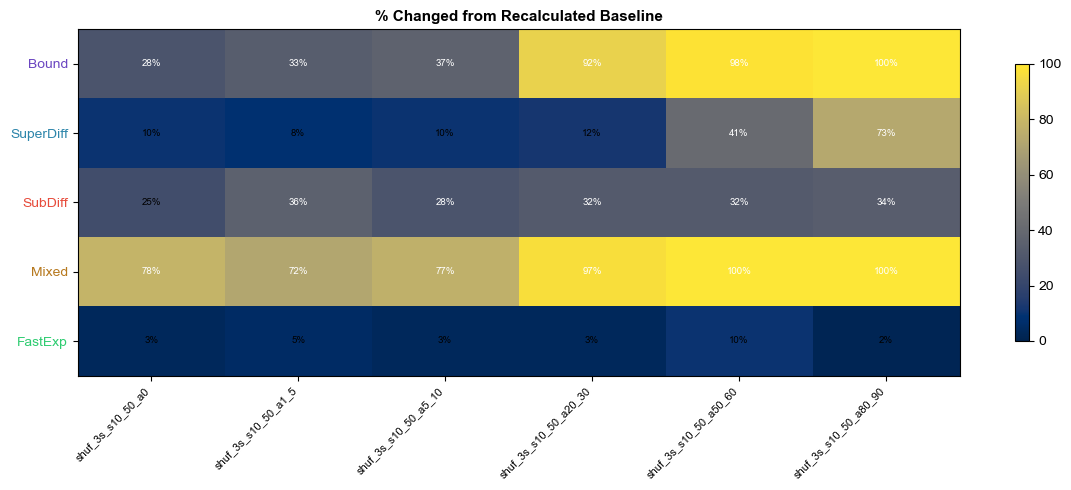

In [26]:
# [11] STABILITY HEATMAP
aug_names = list(SEGMENT_SHUFFLE_CONFIG.keys())
matrix = np.zeros((len(POP_ORDER), len(aug_names)))
for j, a in enumerate(aug_names):
    for i, p in enumerate(POP_ORDER):
        if a in results_by_aug_by_pop and p in results_by_aug_by_pop[a]:
            d = results_by_aug_by_pop[a][p]
            tot = d['stable'] + d['changed']
            matrix[i, j] = 100 * d['changed'] / tot if tot > 0 else 0

fig, ax = plt.subplots(figsize=(max(12, len(aug_names)*0.7), 5))
cmap = 'cividis'
im = ax.imshow(matrix, cmap=cmap, aspect='auto', vmin=0, vmax=100)
for i in range(len(POP_ORDER)):
    for j in range(len(aug_names)):
        ax.text(j, i, f'{matrix[i,j]:.0f}%', ha='center', va='center', fontsize=7, color='white' if matrix[i,j] > 25 else 'black')
ax.set_xticks(np.arange(len(aug_names))); ax.set_xticklabels(aug_names, rotation=45, ha='right', fontsize=8)
ax.set_yticks(np.arange(len(POP_ORDER))); ax.set_yticklabels([POP_ABBREV[p] for p in POP_ORDER], fontsize=10)
for i, p in enumerate(POP_ORDER): ax.get_yticklabels()[i].set_color(POP_COLORS[p])
ax.set_title('% Changed from Recalculated Baseline', fontsize=11, fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.8); plt.tight_layout()
fig.savefig(OUTPUT_FOLDER / 'segment_shuffle_heatmap.svg', format='svg', bbox_inches='tight')
plt.show()

Filtered out 9 tracks where original != recalculated
Using 291 tracks where original == recalculated

DIAG-12: Track selection by RECALCULATED population
  Bound: 60 available → 1 for viz ✅
  SuperDiff: 59 available → 1 for viz ✅
  SubDiff: 53 available → 1 for viz ✅
  Mixed: 60 available → 1 for viz ✅
  FastExp: 59 available → 1 for viz ✅

=== Baseline (no angle) ===
Row 0: RECALC=Bound    (was ORIG=Bound    =)
        ORIG  features: speed=5.161, intersect=180, alpha=0.593, disp=3.083
        RECALC features: speed=5.226, intersect=180, alpha=0.593, disp=3.083
        Augs: SubDi
Row 1: RECALC=SuperDiff (was ORIG=SuperDiff =)
        ORIG  features: speed=4.505, intersect=12, alpha=2.038, disp=2.703
        RECALC features: speed=4.581, intersect=12, alpha=2.038, disp=2.703
        Augs: Super
Row 2: RECALC=SubDiff  (was ORIG=SubDiff  =)
        ORIG  features: speed=8.532, intersect=27, alpha=1.226, disp=5.055
        RECALC features: speed=8.567, intersect=27, alpha=1.226, disp=5.0

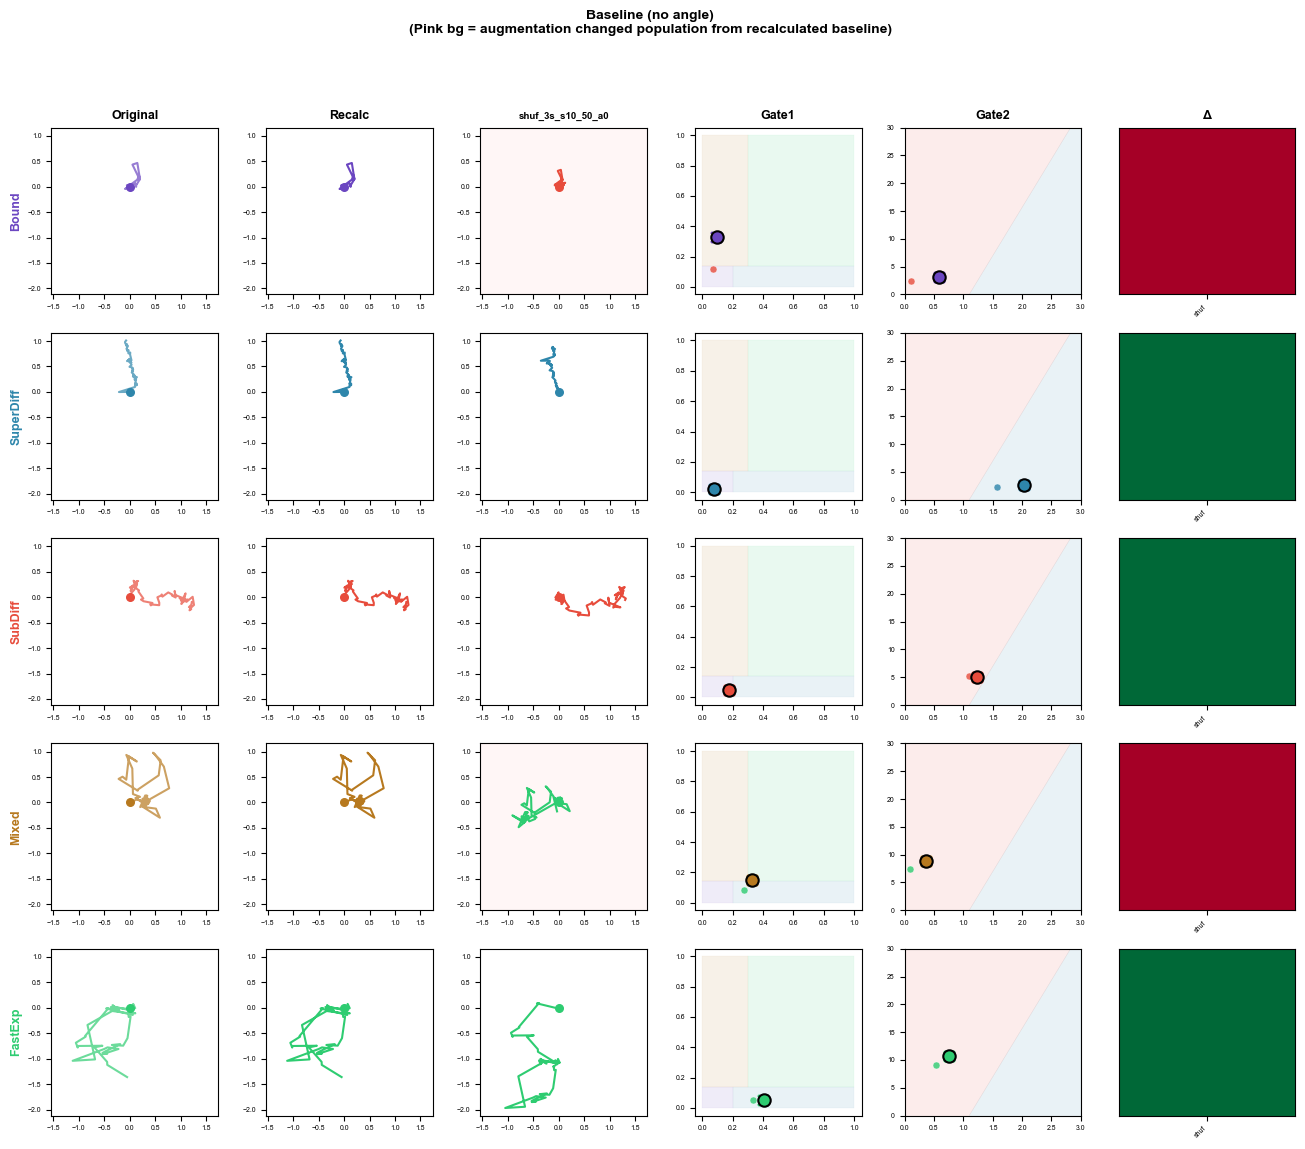


=== Very Mild (1-5°) ===
Row 0: RECALC=Bound    (was ORIG=Bound    =)
        ORIG  features: speed=5.161, intersect=180, alpha=0.593, disp=3.083
        RECALC features: speed=5.226, intersect=180, alpha=0.593, disp=3.083
        Augs: Bound
Row 1: RECALC=SuperDiff (was ORIG=SuperDiff =)
        ORIG  features: speed=4.505, intersect=12, alpha=2.038, disp=2.703
        RECALC features: speed=4.581, intersect=12, alpha=2.038, disp=2.703
        Augs: Super
Row 2: RECALC=SubDiff  (was ORIG=SubDiff  =)
        ORIG  features: speed=8.532, intersect=27, alpha=1.226, disp=5.055
        RECALC features: speed=8.567, intersect=27, alpha=1.226, disp=5.055
        Augs: FastE
Row 3: RECALC=Mixed    (was ORIG=Mixed    =)
        ORIG  features: speed=14.869, intersect=84, alpha=0.358, disp=8.786
        RECALC features: speed=14.891, intersect=84, alpha=0.358, disp=8.786
        Augs: FastE
Row 4: RECALC=FastExp  (was ORIG=FastExp  =)
        ORIG  features: speed=18.024, intersect=31, alpha=0

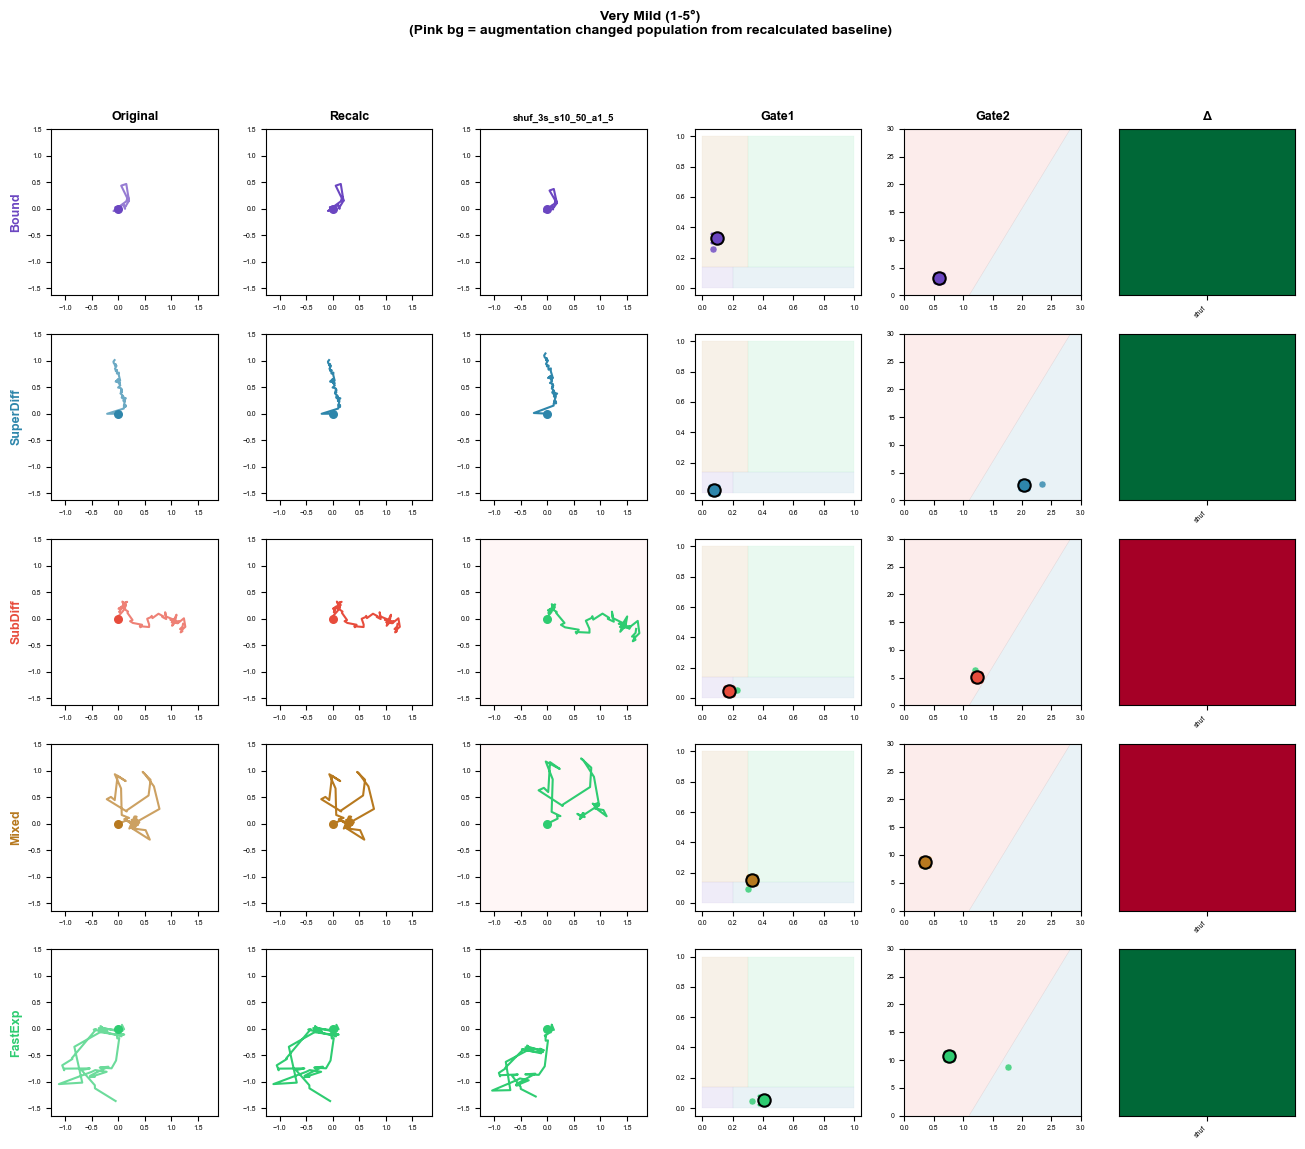


=== Mild (5-10°) ===
Row 0: RECALC=Bound    (was ORIG=Bound    =)
        ORIG  features: speed=5.161, intersect=180, alpha=0.593, disp=3.083
        RECALC features: speed=5.226, intersect=180, alpha=0.593, disp=3.083
        Augs: Bound
Row 1: RECALC=SuperDiff (was ORIG=SuperDiff =)
        ORIG  features: speed=4.505, intersect=12, alpha=2.038, disp=2.703
        RECALC features: speed=4.581, intersect=12, alpha=2.038, disp=2.703
        Augs: Super
Row 2: RECALC=SubDiff  (was ORIG=SubDiff  =)
        ORIG  features: speed=8.532, intersect=27, alpha=1.226, disp=5.055
        RECALC features: speed=8.567, intersect=27, alpha=1.226, disp=5.055
        Augs: Super
Row 3: RECALC=Mixed    (was ORIG=Mixed    =)
        ORIG  features: speed=14.869, intersect=84, alpha=0.358, disp=8.786
        RECALC features: speed=14.891, intersect=84, alpha=0.358, disp=8.786
        Augs: FastE
Row 4: RECALC=FastExp  (was ORIG=FastExp  =)
        ORIG  features: speed=18.024, intersect=31, alpha=0.750

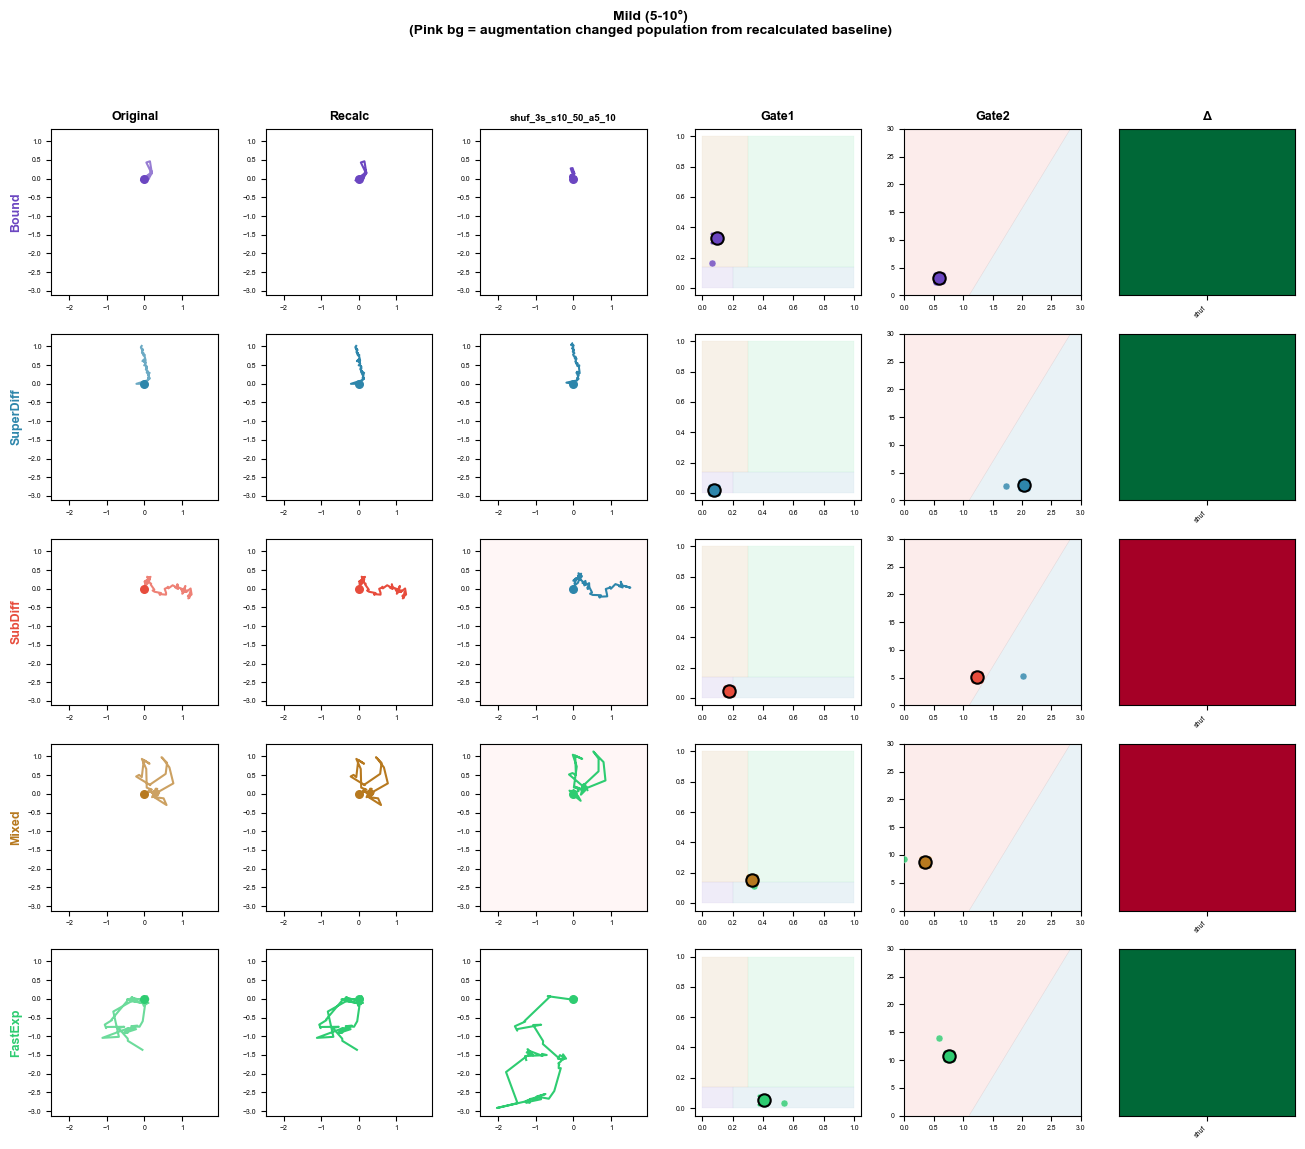


=== Moderate (20-30°) ===
Row 0: RECALC=Bound    (was ORIG=Bound    =)
        ORIG  features: speed=5.161, intersect=180, alpha=0.593, disp=3.083
        RECALC features: speed=5.226, intersect=180, alpha=0.593, disp=3.083
        Augs: Super
Row 1: RECALC=SuperDiff (was ORIG=SuperDiff =)
        ORIG  features: speed=4.505, intersect=12, alpha=2.038, disp=2.703
        RECALC features: speed=4.581, intersect=12, alpha=2.038, disp=2.703
        Augs: Super
Row 2: RECALC=SubDiff  (was ORIG=SubDiff  =)
        ORIG  features: speed=8.532, intersect=27, alpha=1.226, disp=5.055
        RECALC features: speed=8.567, intersect=27, alpha=1.226, disp=5.055
        Augs: FastE
Row 3: RECALC=Mixed    (was ORIG=Mixed    =)
        ORIG  features: speed=14.869, intersect=84, alpha=0.358, disp=8.786
        RECALC features: speed=14.891, intersect=84, alpha=0.358, disp=8.786
        Augs: FastE
Row 4: RECALC=FastExp  (was ORIG=FastExp  =)
        ORIG  features: speed=18.024, intersect=31, alpha=

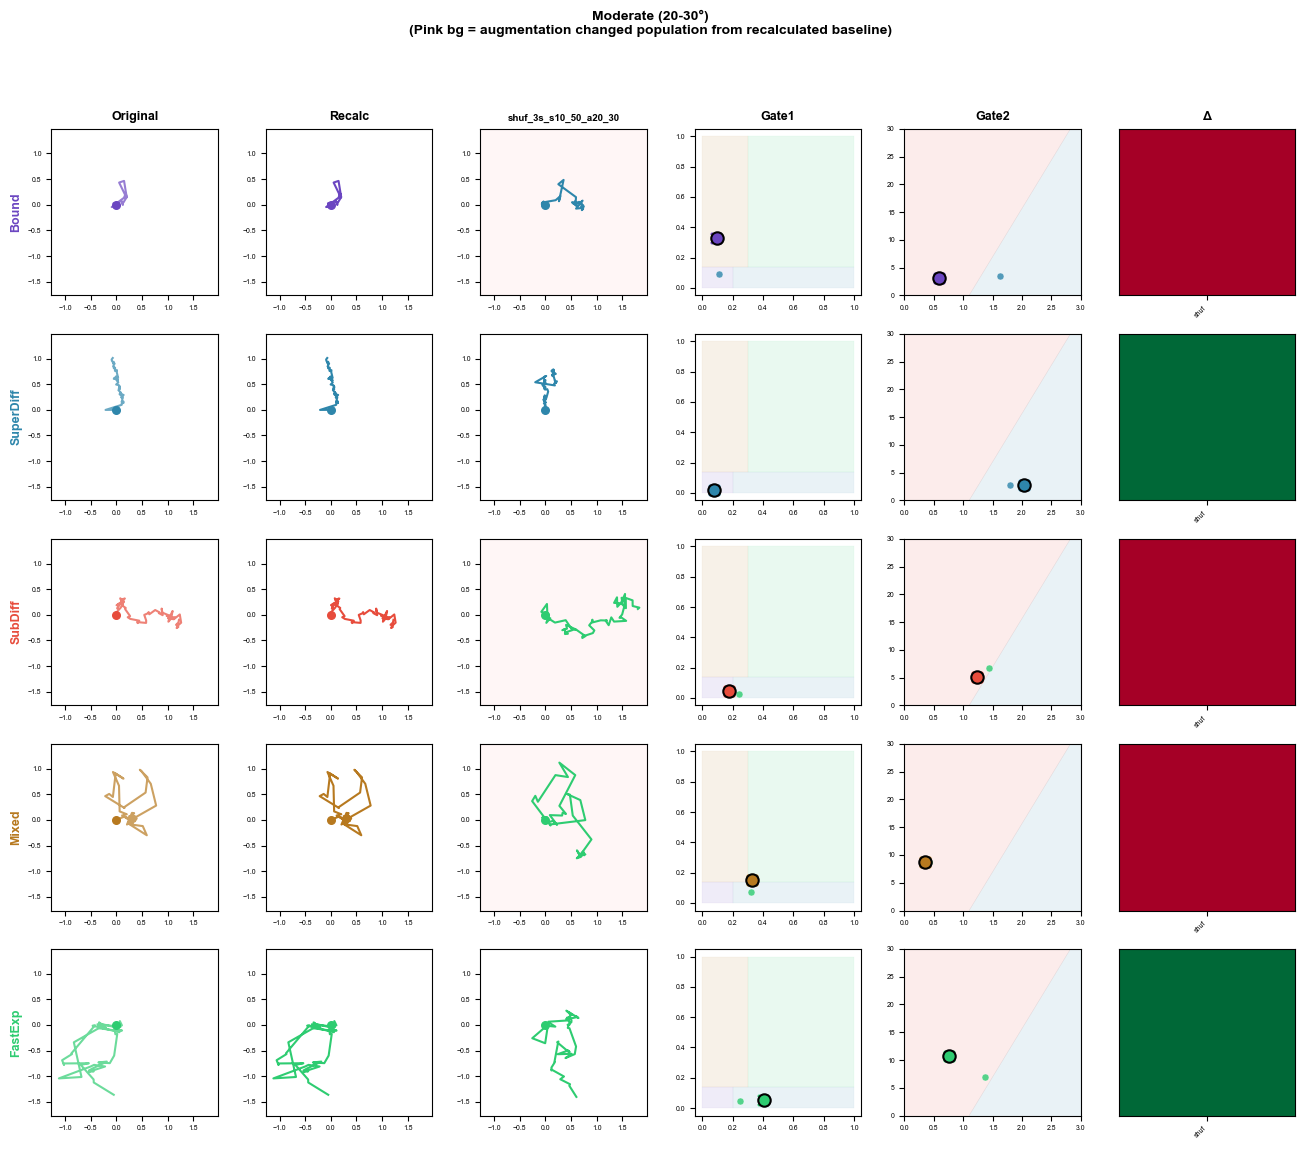


=== Strong (50-60°) ===
Row 0: RECALC=Bound    (was ORIG=Bound    =)
        ORIG  features: speed=5.161, intersect=180, alpha=0.593, disp=3.083
        RECALC features: speed=5.226, intersect=180, alpha=0.593, disp=3.083
        Augs: SubDi
Row 1: RECALC=SuperDiff (was ORIG=SuperDiff =)
        ORIG  features: speed=4.505, intersect=12, alpha=2.038, disp=2.703
        RECALC features: speed=4.581, intersect=12, alpha=2.038, disp=2.703
        Augs: Super
Row 2: RECALC=SubDiff  (was ORIG=SubDiff  =)
        ORIG  features: speed=8.532, intersect=27, alpha=1.226, disp=5.055
        RECALC features: speed=8.567, intersect=27, alpha=1.226, disp=5.055
        Augs: SubDi
Row 3: RECALC=Mixed    (was ORIG=Mixed    =)
        ORIG  features: speed=14.869, intersect=84, alpha=0.358, disp=8.786
        RECALC features: speed=14.891, intersect=84, alpha=0.358, disp=8.786
        Augs: FastE
Row 4: RECALC=FastExp  (was ORIG=FastExp  =)
        ORIG  features: speed=18.024, intersect=31, alpha=0.

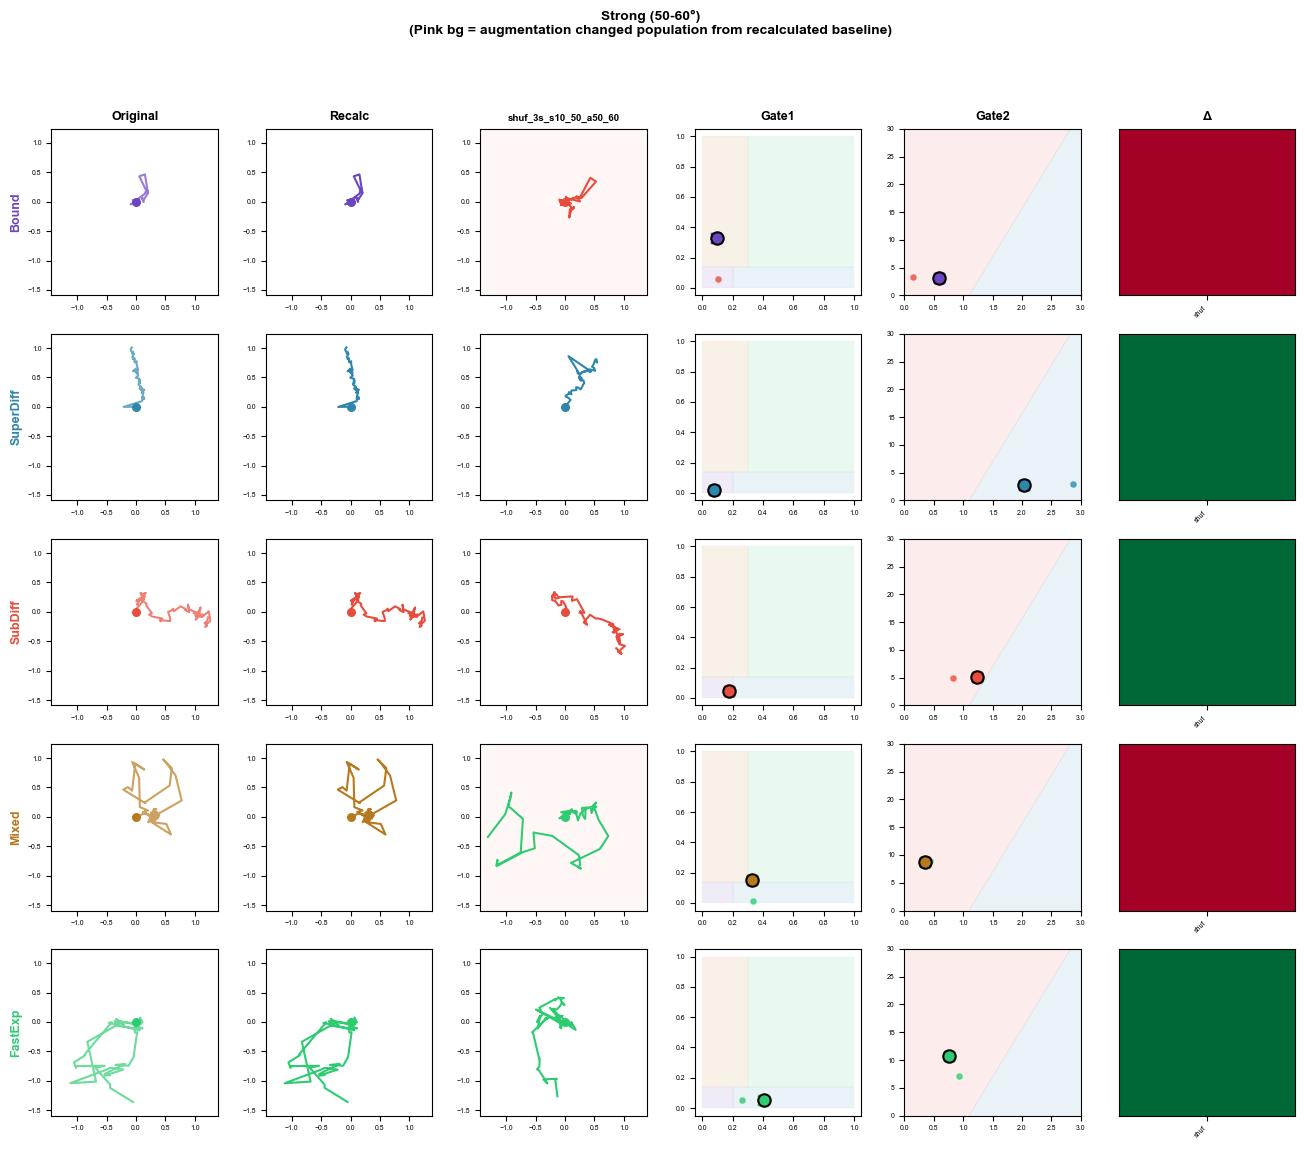


=== Extreme (80-90°) ===
Row 0: RECALC=Bound    (was ORIG=Bound    =)
        ORIG  features: speed=5.161, intersect=180, alpha=0.593, disp=3.083
        RECALC features: speed=5.226, intersect=180, alpha=0.593, disp=3.083
        Augs: Super
Row 1: RECALC=SuperDiff (was ORIG=SuperDiff =)
        ORIG  features: speed=4.505, intersect=12, alpha=2.038, disp=2.703
        RECALC features: speed=4.581, intersect=12, alpha=2.038, disp=2.703
        Augs: Super
Row 2: RECALC=SubDiff  (was ORIG=SubDiff  =)
        ORIG  features: speed=8.532, intersect=27, alpha=1.226, disp=5.055
        RECALC features: speed=8.567, intersect=27, alpha=1.226, disp=5.055
        Augs: FastE
Row 3: RECALC=Mixed    (was ORIG=Mixed    =)
        ORIG  features: speed=14.869, intersect=84, alpha=0.358, disp=8.786
        RECALC features: speed=14.891, intersect=84, alpha=0.358, disp=8.786
        Augs: FastE
Row 4: RECALC=FastExp  (was ORIG=FastExp  =)
        ORIG  features: speed=18.024, intersect=31, alpha=0

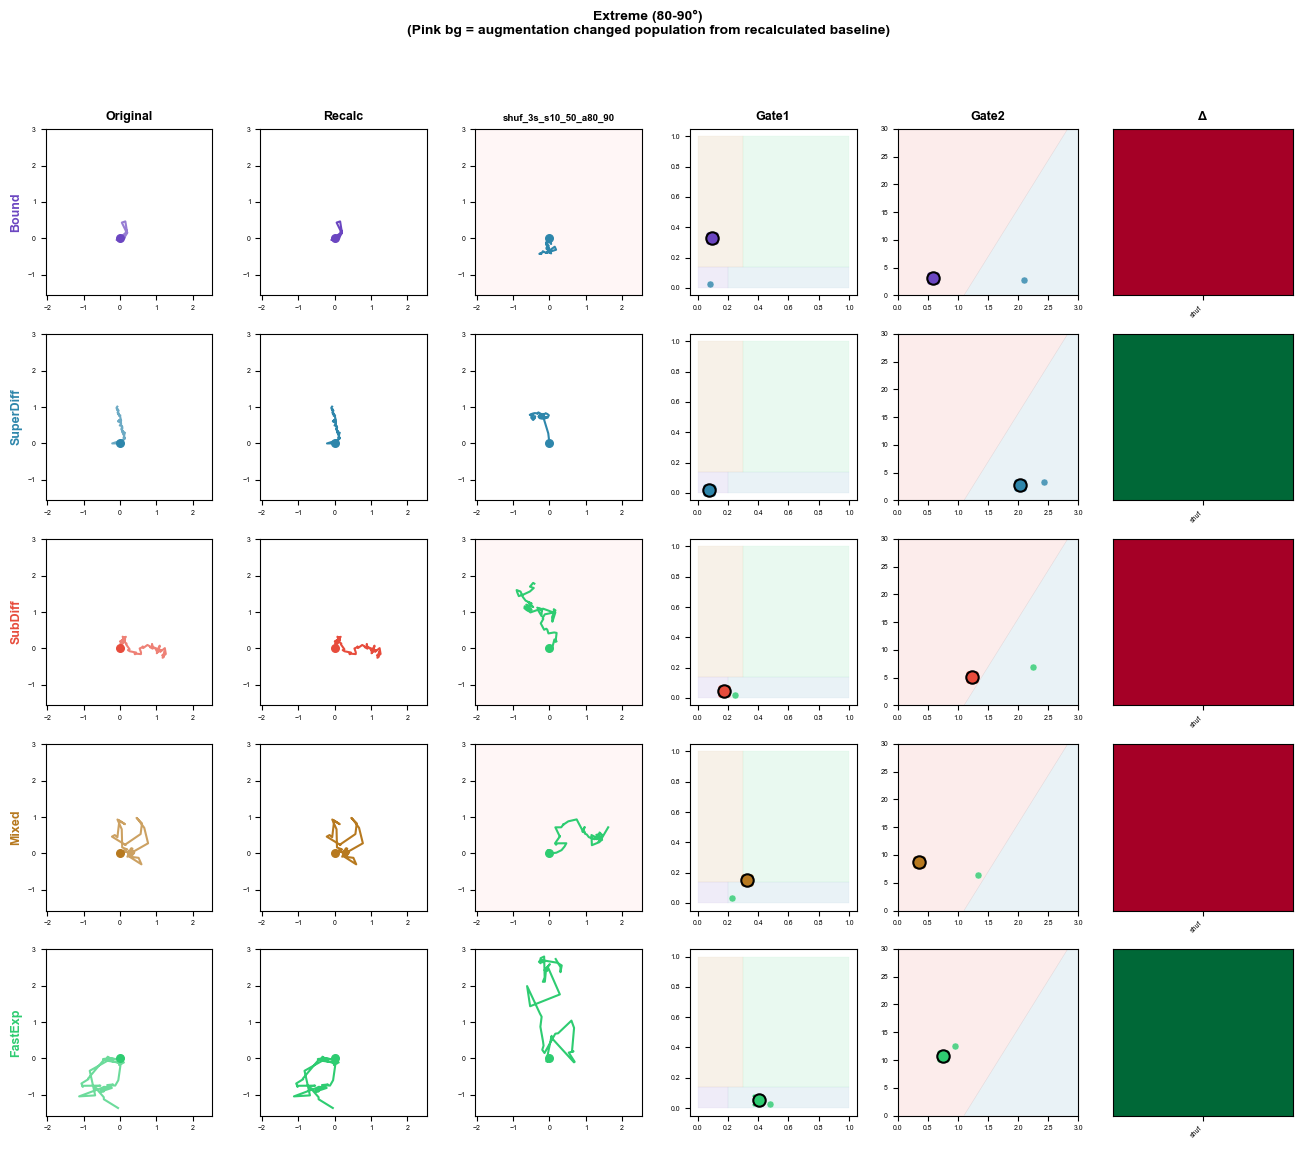


LEGEND:
  Row label: Shows RECALCULATED population (what the row represents)
  Column 1 (Original): Track colored by ORIGINAL population (may differ from row!)
  Column 2 (Recalc): Track colored by RECALCULATED population (matches row label)
  Augmented columns: Track colored by its FINAL GATED population after augmentation
  Pink background: Augmentation changed population from recalculated baseline
  Heatmap: Green=stable, Red=changed (comparing augmented vs recalculated)
  Gate plots: ○ = recalc position, × = original position (if SHOW_ORIGINAL_ON_GATES=True)
Note: SHOW_ORIGINAL_ON_GATES = True
Done!


In [27]:
# [12] TRACK PANELS - Original | Recalculated | Augmentations
# NOTE: Run cells 7-11 first!
# IMPORTANT: We select tracks by their RECALCULATED population (not original!)
#            This ensures each row shows a TRUE example of that behavior type
#            All comparisons are RECALCULATED vs AUGMENTED

# OPTION: Show original track position on gate plots as 'x' marker
SHOW_ORIGINAL_ON_GATES = True  # Set to False to hide original markers

# Group tracks by their RECALCULATED population (this is what matters for analysis)
# tracks_by_recalc_pop = {p: [] for p in POP_ORDER}
# for parent_uid in all_parent_uids:
#     rec = classified_df.filter(pl.col('window_uid') == f'{parent_uid}_recalculated')
#     if rec.height > 0:
#         rec_pop = rec['final_population'][0]
#         if rec_pop in tracks_by_recalc_pop:
#             tracks_by_recalc_pop[rec_pop].append(parent_uid)

###########################

# Group tracks by their RECALCULATED population (this is what matters for analysis)
# IMPORTANT: Only include tracks where original == recalculated (stable upon recalculation)
tracks_by_recalc_pop = {p: [] for p in POP_ORDER}
n_filtered = 0
for parent_uid in all_parent_uids:
    # Get original population
    orig_row = windowed_df.filter(pl.col('window_uid') == parent_uid)
    if orig_row.height == 0: continue
    orig_pop = orig_row['final_population'][0]
    
    # Get recalculated population
    rec = classified_df.filter(pl.col('window_uid') == f'{parent_uid}_recalculated')
    if rec.height == 0: continue
    rec_pop = rec['final_population'][0]
    
    # FILTER: Only include tracks where original == recalculated
    if orig_pop != rec_pop:
        n_filtered += 1
        continue
    
    if rec_pop in tracks_by_recalc_pop:
        tracks_by_recalc_pop[rec_pop].append(parent_uid)

print(f"Filtered out {n_filtered} tracks where original != recalculated")
print(f"Using {len(all_parent_uids) - n_filtered} tracks where original == recalculated")
print()

##########################

# RANDOMIZE selection for each population, then take N_TRACKS_VIZ
viz_tracks = {}
for p in POP_ORDER:
    pool = tracks_by_recalc_pop.get(p, []).copy()
    np.random.shuffle(pool)  # Randomize!
    viz_tracks[p] = pool[:N_TRACKS_VIZ]

# DIAGNOSTIC: What tracks do we have?
print("="*70)
print("DIAG-12: Track selection by RECALCULATED population")
print("="*70)
for p in POP_ORDER:
    available = len(tracks_by_recalc_pop.get(p, []))
    viz = len(viz_tracks.get(p, []))
    status = "✅" if viz >= N_TRACKS_VIZ else ("⚠️ LOW" if viz > 0 else "❌ NONE")
    print(f"  {POP_ABBREV[p]}: {available} available → {viz} for viz {status}")

for group_name, aug_list in SEGMENT_GROUPS.items():
    print(f'\n{"="*70}')
    print(f'=== {group_name} ===')
    print("="*70)
    track_rows = [(p, u) for p in POP_ORDER for u in viz_tracks.get(p, [])]
    if not track_rows:
        print("No tracks - skipping")
        continue
    
    n_rows, n_aug = len(track_rows), len(aug_list)
    n_cols = 2 + n_aug + 3  # Original | Recalc | Augs | Gate1 | Gate2 | Heatmap
    
    # Pre-cache tracks and compute global limits
    cache = {}; gmin_x, gmax_x, gmin_y, gmax_y = np.inf, -np.inf, np.inf, -np.inf
    for pop, uid in track_rows:
        tdf = get_window_frames(instant_df, uid)
        if tdf.height == 0: continue
        x, y = tdf['x_um'].to_numpy(), tdf['y_um'].to_numpy()
        xc, yc = x - x[0], y - y[0]
        cache[uid] = {'x': x, 'y': y, 'xc': xc, 'yc': yc, 'dt': tdf['delta_time_s'].to_numpy(), 'aug': {}}
        gmin_x, gmax_x = min(gmin_x, xc.min()), max(gmax_x, xc.max())
        gmin_y, gmax_y = min(gmin_y, yc.min()), max(gmax_y, yc.max())
        for a in aug_list:
            seed = hash(f'{uid}_{a}') % 2**32
            xa, ya = apply_aug(x, y, a, seed)
            xac, yac = xa - xa[0], ya - ya[0]
            cache[uid]['aug'][a] = {'xc': xac, 'yc': yac}
            gmin_x, gmax_x = min(gmin_x, xac.min()), max(gmax_x, xac.max())
            gmin_y, gmax_y = min(gmin_y, yac.min()), max(gmax_y, yac.max())
    
    rng = max(gmax_x - gmin_x, gmax_y - gmin_y) * 1.1
    cx, cy = (gmax_x + gmin_x) / 2, (gmax_y + gmin_y) / 2
    xlim, ylim = (cx - rng/2, cx + rng/2), (cy - rng/2, cy + rng/2)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.2*n_cols, 2.2*n_rows))
    if n_rows == 1: axes = axes.reshape(1, -1)
    
    for ri, (pop, uid) in enumerate(track_rows):
        if uid not in cache: continue
        c = cache[uid]
        
        # pop = RECALCULATED population (what we selected by)
        pop_color = POP_COLORS.get(pop, '#888')
        
        # Get recalculated data (pop should match since we selected by recalc population)
        rec = classified_df.filter(pl.col('window_uid') == f'{uid}_recalculated')
        rec_pop = rec['final_population'][0] if rec.height > 0 else pop
        
        # Get ORIGINAL population for comparison (may be different!)
        orig_row = windowed_df.filter(pl.col('window_uid') == uid)
        orig_pop = orig_row['final_population'][0] if orig_row.height > 0 else 'unknown'
        orig_color = POP_COLORS.get(orig_pop, '#888')
        
        # DIAGNOSTIC: Show what original was vs what recalc is (row label) + features
        changed = "→" if orig_pop != pop else "="
        print(f"Row {ri}: RECALC={POP_ABBREV.get(pop,'?'):<8} (was ORIG={POP_ABBREV.get(orig_pop,'?'):<8} {changed})")
        
        # Print feature comparison: ORIGINAL vs RECALCULATED
        if orig_row.height > 0 and rec.height > 0:
            print(f"        ORIG  features: speed={orig_row['avg_speed_um_s'][0]:.3f}, intersect={orig_row['self_intersections'][0]}, alpha={orig_row['anomalous_exponent'][0]:.3f}, disp={orig_row['cum_displacement_um'][0]:.3f}")
            print(f"        RECALC features: speed={rec['avg_speed_um_s'][0]:.3f}, intersect={rec['self_intersections'][0]}, alpha={rec['anomalous_exponent'][0]:.3f}, disp={rec['cum_displacement_um'][0]:.3f}")
        
        ci = 0
        
        # Column 0: ORIGINAL track (colored by ORIGINAL population - may differ from row label!)
        ax = axes[ri, ci]
        ax.plot(c['xc'], c['yc'], color=orig_color, lw=1.5, alpha=0.7)
        ax.scatter([0], [0], c=orig_color, s=30, marker='o', zorder=5)
        ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
        if ri == 0: ax.set_title('Original', fontsize=9, fontweight='bold')
        # Row label shows RECALCULATED population (what the row represents)
        ax.set_ylabel(POP_ABBREV.get(pop, pop), fontsize=9, color=pop_color, fontweight='bold')
        ax.tick_params(labelsize=5); ci += 1
        
        # Column 1: RECALCULATED track (colored by RECALCULATED population = row label)
        ax = axes[ri, ci]
        ax.plot(c['xc'], c['yc'], color=pop_color, lw=1.5)
        ax.scatter([0], [0], c=pop_color, s=30, marker='o', zorder=5)
        ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
        if ri == 0: ax.set_title('Recalc', fontsize=9, fontweight='bold')
        ax.tick_params(labelsize=5); ci += 1
        
        # Augmented tracks (colored by THEIR FINAL POPULATION)
        aug_info = []
        for a in aug_list:
            ax = axes[ri, ci]
            ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
            aug_pop = ar['final_population'][0] if ar.height > 0 else 'unknown'
            aug_color = POP_COLORS.get(aug_pop, '#888')
            aug_info.append(f"{POP_ABBREV.get(aug_pop,'?')[:5]}")
            ad = c['aug'].get(a, {})
            if 'xc' in ad:
                ax.plot(ad['xc'], ad['yc'], color=aug_color, lw=1.5)
                ax.scatter([0], [0], c=aug_color, s=30, zorder=5)
            ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
            short = a.replace('shuffle_', '').replace('seg', 's').replace('circular_', 'c').replace('adjacent_', 'adj')
            if ri == 0: ax.set_title(short, fontsize=7, fontweight='bold')
            # Highlight if different from RECALCULATED baseline (the fair comparison)
            if aug_pop != rec_pop: ax.patch.set_facecolor('#FFEEEE'); ax.patch.set_alpha(0.5)
            ax.tick_params(labelsize=5); ci += 1
        print(f"        Augs: {', '.join(aug_info)}")
        
        # Gate 1 plot - show recalc baseline (large circle) and augmented (small dots)
        ax = axes[ri, ci]
        for g, p in GATE1_RECTS.items():
            ax.add_patch(Rectangle((p['x'][0], p['y'][0]), p['x'][1]-p['x'][0], p['y'][1]-p['y'][0], alpha=0.1, fc=p['color'], ec=p['color'], lw=0.3))
        # Optional: Show ORIGINAL position as 'x' marker
        if SHOW_ORIGINAL_ON_GATES and orig_row.height > 0:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                sc_orig = scaler.transform([[orig_row['avg_speed_um_s'][0], orig_row['self_intersections'][0]]])[0]
            ax.scatter(sc_orig[0], sc_orig[1], c=orig_color, s=60, marker='x', lw=2, zorder=8, label='orig')
        if rec.height > 0:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                sc = scaler.transform([[rec['avg_speed_um_s'][0], rec['self_intersections'][0]]])[0]
            # Large circle for recalc baseline in population color
            ax.scatter(sc[0], sc[1], c=pop_color, s=80, marker='o', ec='black', lw=1.5, zorder=10)
        for a in aug_list:
            ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
            if ar.height > 0:
                ap = ar['final_population'][0]; ac = POP_COLORS.get(ap, '#888')
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    sc = scaler.transform([[ar['avg_speed_um_s'][0], ar['self_intersections'][0]]])[0]
                ax.scatter(sc[0], sc[1], c=ac, s=25, ec='white', lw=0.3, alpha=0.8, zorder=5)
        ax.set_xlim(-0.05, 1.05); ax.set_ylim(-0.05, 1.05); ax.set_aspect('equal')
        if ri == 0: ax.set_title('Gate1', fontsize=9, fontweight='bold')
        ax.tick_params(labelsize=5); ci += 1
        
        # Gate 2 plot
        ax = axes[ri, ci]
        ax.add_patch(Polygon(GATE2_BOUNDS['superdiffusive'], alpha=0.1, fc='#2E86AB', ec='#2E86AB', lw=0.3))
        ax.add_patch(Polygon(GATE2_BOUNDS['subdiffusive'], alpha=0.1, fc='#E74C3C', ec='#E74C3C', lw=0.3))
        # Optional: Show ORIGINAL position as 'x' marker
        if SHOW_ORIGINAL_ON_GATES and orig_row.height > 0:
            ax.scatter(orig_row['anomalous_exponent'][0], orig_row['cum_displacement_um'][0], c=orig_color, s=60, marker='x', lw=2, zorder=8)
        if rec.height > 0:
            # Large circle for recalc baseline in population color
            ax.scatter(rec['anomalous_exponent'][0], rec['cum_displacement_um'][0], c=pop_color, s=80, marker='o', ec='black', lw=1.5, zorder=10)
        for a in aug_list:
            ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
            if ar.height > 0:
                ap = ar['final_population'][0]; ac = POP_COLORS.get(ap, '#888')
                ax.scatter(ar['anomalous_exponent'][0], ar['cum_displacement_um'][0], c=ac, s=25, ec='white', lw=0.3, alpha=0.8, zorder=5)
        ax.set_xlim(0, 3); ax.set_ylim(0, 30)  # Extended to match gate bounds (max cum_disp ~28)
        if ri == 0: ax.set_title('Gate2', fontsize=9, fontweight='bold')
        ax.tick_params(labelsize=5); ci += 1
        
        # HEATMAP: Did augmentation change population from RECALCULATED baseline?
        ax = axes[ri, ci]
        aug_changes = []
        for a in aug_list:
            ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
            aug_changes.append(1 if ar.height > 0 and ar['final_population'][0] != rec_pop else 0)
        ax.imshow([aug_changes], cmap='RdYlGn_r', vmin=0, vmax=1, aspect='auto')
        ax.set_xticks(np.arange(len(aug_list))); ax.set_xticklabels([a[:4] for a in aug_list], fontsize=5, rotation=45, ha='right')
        ax.set_yticks([])
        if ri == 0: ax.set_title('Δ', fontsize=9, fontweight='bold')
    
    plt.suptitle(f'{group_name}\n(Pink bg = augmentation changed population from recalculated baseline)', fontsize=10, fontweight='bold', y=1.04)
    plt.tight_layout()
    safe = group_name.lower().replace(' ', '_').replace('+', '_')
    fig.savefig(OUTPUT_FOLDER / f'track_panel_{safe}.svg', format='svg', bbox_inches='tight')
    plt.show()

print("\n" + "="*70)
print("LEGEND:")
print("  Row label: Shows RECALCULATED population (what the row represents)")
print("  Column 1 (Original): Track colored by ORIGINAL population (may differ from row!)")
print("  Column 2 (Recalc): Track colored by RECALCULATED population (matches row label)")
print("  Augmented columns: Track colored by its FINAL GATED population after augmentation")
print("  Pink background: Augmentation changed population from recalculated baseline")
print("  Heatmap: Green=stable, Red=changed (comparing augmented vs recalculated)")
print("  Gate plots: ○ = recalc position, × = original position (if SHOW_ORIGINAL_ON_GATES=True)")
print("="*70)
print(f"Note: SHOW_ORIGINAL_ON_GATES = {SHOW_ORIGINAL_ON_GATES}")
print('Done!')

In [31]:
OUTPUT_FOLDER

WindowsPath('D:/TRANSFORMER_DEVELOPMENT/plots/shuffle_scale_analysis')

In [23]:
# # [12B] SINGLE POPULATION DEEP DIVE - Many tracks from ONE population
# # Use this to see how augmentations affect many examples of one behavior type

# # ============ CONFIGURE THIS ============
# TARGET_POP = 'fast_exploratory'  # Change to: 'bound_stationary', 'superdiffusive_transport', 
#                                   #            'subdiffusive_motion', 'mixed_exploratory_bound', 'fast_exploratory'
# N_EXAMPLES = 10  # Number of track examples to show
# # Titration: ±50% scale + angular noise with GUARANTEED RANGES
# # TARGET_AUGS = [
# #     'shuf_s50_a0',      # No noise baseline
# #     'shuf_s50_a2_5',    # 2-5° guaranteed
# #     'shuf_s50_a5_10',   # 5-10° guaranteed
# #     'shuf_s50_a10_15',  # 10-15° guaranteed
# #     'shuf_s50_a15_20',  # 15-20° guaranteed
# #     'shuf_s50_a20_25',  # 20-25° guaranteed
# #     'shuf_s50_a25_30',  # 25-30° guaranteed
# #     'shuf_only',        # Reference: shuffle only
# # ]
# # ========================================
# # Use all augmentations from config (2, 3, and 4 segment shuffles with all scaling options)
# TARGET_AUGS = list(SEGMENT_SHUFFLE_CONFIG.keys())

# print("="*70)
# print(f"SINGLE POPULATION DEEP DIVE: {POP_ABBREV.get(TARGET_POP, TARGET_POP)}")
# print("="*70)

# # Get tracks from this population (by RECALCULATED classification)
# pop_tracks = tracks_by_recalc_pop.get(TARGET_POP, []).copy()
# np.random.shuffle(pop_tracks)
# viz_tracks_single = pop_tracks[:N_EXAMPLES]

# print(f"Available: {len(pop_tracks)} tracks")
# print(f"Showing: {len(viz_tracks_single)} examples")
# print(f"Augmentations: {TARGET_AUGS}")

# if len(viz_tracks_single) == 0:
#     print(f"❌ No tracks found for {TARGET_POP}!")
# else:
#     n_rows = len(viz_tracks_single)
#     n_aug = len(TARGET_AUGS)
#     n_cols = 2 + n_aug + 3  # Original | Recalc | Augs | Gate1 | Gate2 | Heatmap
    
#     # Pre-cache tracks and compute global limits
#     cache = {}
#     gmin_x, gmax_x, gmin_y, gmax_y = np.inf, -np.inf, np.inf, -np.inf
    
#     for uid in viz_tracks_single:
#         tdf = get_window_frames(instant_df, uid)
#         if tdf.height == 0: continue
#         x, y = tdf['x_um'].to_numpy(), tdf['y_um'].to_numpy()
#         xc, yc = x - x[0], y - y[0]
#         cache[uid] = {'x': x, 'y': y, 'xc': xc, 'yc': yc, 'dt': tdf['delta_time_s'].to_numpy(), 'aug': {}}
#         gmin_x, gmax_x = min(gmin_x, xc.min()), max(gmax_x, xc.max())
#         gmin_y, gmax_y = min(gmin_y, yc.min()), max(gmax_y, yc.max())
#         for a in TARGET_AUGS:
#             seed = hash(f'{uid}_{a}') % 2**32
#             xa, ya = apply_aug(x, y, a, seed)
#             xac, yac = xa - xa[0], ya - ya[0]
#             cache[uid]['aug'][a] = {'xc': xac, 'yc': yac}
#             gmin_x, gmax_x = min(gmin_x, xac.min()), max(gmax_x, xac.max())
#             gmin_y, gmax_y = min(gmin_y, yac.min()), max(gmax_y, yac.max())
    
#     rng = max(gmax_x - gmin_x, gmax_y - gmin_y) * 1.1
#     cx, cy = (gmax_x + gmin_x) / 2, (gmax_y + gmin_y) / 2
#     xlim, ylim = (cx - rng/2, cx + rng/2), (cy - rng/2, cy + rng/2)
    
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.2*n_cols, 2.0*n_rows))
#     if n_rows == 1: axes = axes.reshape(1, -1)
    
#     pop_color = POP_COLORS.get(TARGET_POP, '#888')
    
#     for ri, uid in enumerate(viz_tracks_single):
#         if uid not in cache: continue
#         c = cache[uid]
        
#         # Get recalculated data
#         rec = classified_df.filter(pl.col('window_uid') == f'{uid}_recalculated')
#         rec_pop = rec['final_population'][0] if rec.height > 0 else TARGET_POP
        
#         # Get original data
#         orig_row = windowed_df.filter(pl.col('window_uid') == uid)
#         orig_pop = orig_row['final_population'][0] if orig_row.height > 0 else 'unknown'
#         orig_color = POP_COLORS.get(orig_pop, '#888')
        
#         ci = 0
        
#         # Column 0: ORIGINAL track
#         ax = axes[ri, ci]
#         ax.plot(c['xc'], c['yc'], color=orig_color, lw=1.2, alpha=0.8)
#         ax.scatter([0], [0], c=orig_color, s=20, marker='o', zorder=5)
#         ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
#         if ri == 0: ax.set_title('Original', fontsize=8, fontweight='bold')
#         ax.set_ylabel(f'#{ri+1}', fontsize=8, color=pop_color, fontweight='bold')
#         ax.tick_params(labelsize=4); ci += 1
        
#         # Column 1: RECALCULATED track
#         ax = axes[ri, ci]
#         ax.plot(c['xc'], c['yc'], color=pop_color, lw=1.2)
#         ax.scatter([0], [0], c=pop_color, s=20, marker='o', zorder=5)
#         ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
#         if ri == 0: ax.set_title('Recalc', fontsize=8, fontweight='bold')
#         ax.tick_params(labelsize=4); ci += 1
        
#         # Augmented tracks
#         for a in TARGET_AUGS:
#             ax = axes[ri, ci]
#             ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
#             aug_pop = ar['final_population'][0] if ar.height > 0 else 'unknown'
#             aug_color = POP_COLORS.get(aug_pop, '#888')
#             ad = c['aug'].get(a, {})
#             if 'xc' in ad:
#                 ax.plot(ad['xc'], ad['yc'], color=aug_color, lw=1.2)
#                 ax.scatter([0], [0], c=aug_color, s=20, zorder=5)
#             ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
#             # Shorter label: shuf_s50_a10_15 → 10-15°
#             # short = a.replace('shuf_s50_a', '').replace('_', '-') + ('°' if a.startswith('shuf_s50_a') and a != 'shuf_s50_a0' else '')
#             # if a == 'shuf_s50_a0': short = 'scale'
#             # short = short.replace('shuf_only', 'shuf')
#                 # Use helper function for labels
#             if a in SEGMENT_SHUFFLE_CONFIG:
#                 try:
#                     short = get_scale_label(a)
#                 except:
#                     short = a.replace('shuf_', '').replace('_a0', '').replace('_', '-')
#             else:
#                 short = a.replace('shuf_s50_a', '').replace('_', '-') + ('°' if a.startswith('shuf_s50_a') and a != 'shuf_s50_a0' else '')
#                 if a == 'shuf_s50_a0': short = 'scale'
#                 short = short.replace('shuf_only', 'shuf')
#             if ri == 0: ax.set_title(short, fontsize=7, fontweight='bold')
#             if aug_pop != rec_pop: 
#                 ax.patch.set_facecolor('#FFEEEE'); ax.patch.set_alpha(0.5)
#             ax.tick_params(labelsize=4); ci += 1
        
#         # Gate 1 plot
#         ax = axes[ri, ci]
#         for g, p in GATE1_RECTS.items():
#             ax.add_patch(Rectangle((p['x'][0], p['y'][0]), p['x'][1]-p['x'][0], p['y'][1]-p['y'][0], alpha=0.1, fc=p['color'], ec=p['color'], lw=0.3))
#         if rec.height > 0:
#             with warnings.catch_warnings():
#                 warnings.simplefilter('ignore')
#                 sc = scaler.transform([[rec['avg_speed_um_s'][0], rec['self_intersections'][0]]])[0]
#             ax.scatter(sc[0], sc[1], c=pop_color, s=50, marker='o', ec='black', lw=1, zorder=10)
#         for a in TARGET_AUGS:
#             ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
#             if ar.height > 0:
#                 ap = ar['final_population'][0]; ac = POP_COLORS.get(ap, '#888')
#                 with warnings.catch_warnings():
#                     warnings.simplefilter('ignore')
#                     sc = scaler.transform([[ar['avg_speed_um_s'][0], ar['self_intersections'][0]]])[0]
#                 ax.scatter(sc[0], sc[1], c=ac, s=15, ec='white', lw=0.2, alpha=0.8, zorder=5)
#         ax.set_xlim(-0.05, 1.05); ax.set_ylim(-0.05, 1.05); ax.set_aspect('equal')
#         if ri == 0: ax.set_title('G1', fontsize=8, fontweight='bold')
#         ax.tick_params(labelsize=4); ci += 1
        
#         # Gate 2 plot
#         ax = axes[ri, ci]
#         ax.add_patch(Polygon(GATE2_BOUNDS['superdiffusive'], alpha=0.1, fc='#2E86AB', ec='#2E86AB', lw=0.3))
#         ax.add_patch(Polygon(GATE2_BOUNDS['subdiffusive'], alpha=0.1, fc='#E74C3C', ec='#E74C3C', lw=0.3))
#         if rec.height > 0:
#             ax.scatter(rec['anomalous_exponent'][0], rec['cum_displacement_um'][0], c=pop_color, s=50, marker='o', ec='black', lw=1, zorder=10)
#         for a in TARGET_AUGS:
#             ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
#             if ar.height > 0:
#                 ap = ar['final_population'][0]; ac = POP_COLORS.get(ap, '#888')
#                 ax.scatter(ar['anomalous_exponent'][0], ar['cum_displacement_um'][0], c=ac, s=15, ec='white', lw=0.2, alpha=0.8, zorder=5)
#         ax.set_xlim(0, 3); ax.set_ylim(0, 30)
#         if ri == 0: ax.set_title('G2', fontsize=8, fontweight='bold')
#         ax.tick_params(labelsize=4); ci += 1
        
#         # Heatmap
#         ax = axes[ri, ci]
#         aug_changes = []
#         for a in TARGET_AUGS:
#             ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
#             aug_changes.append(1 if ar.height > 0 and ar['final_population'][0] != rec_pop else 0)
#         ax.imshow([aug_changes], cmap='RdYlGn_r', vmin=0, vmax=1, aspect='auto')
#         ax.set_xticks([]); ax.set_yticks([])
#         if ri == 0: ax.set_title('Δ', fontsize=8, fontweight='bold')
    
#     plt.suptitle(f'{POP_ABBREV.get(TARGET_POP, TARGET_POP)} Population - {N_EXAMPLES} Examples\n(Pink = category changed)', 
#                  fontsize=11, fontweight='bold', y=1.02)
#     plt.tight_layout()
#     safe = TARGET_POP.replace('_', '')
#     fig.savefig(OUTPUT_FOLDER / f'single_pop_{safe}_{N_EXAMPLES}ex.svg', format='svg', bbox_inches='tight')
#     plt.show()
    
#     # Summary stats
#     print("\n" + "="*70)
#     print("STABILITY SUMMARY:")
#     print("="*70)
#     for a in TARGET_AUGS:
#         stable = sum(1 for uid in viz_tracks_single 
#                     if classified_df.filter(pl.col('window_uid') == f'{uid}_{a}').height > 0 and
#                        classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')['final_population'][0] == 
#                        classified_df.filter(pl.col('window_uid') == f'{uid}_recalculated')['final_population'][0])
#         short = a.replace('shuf_scale_', '±').replace('pct', '%').replace('shuf_only_4seg', 'shuffle only')
#         print(f"  {short}: {stable}/{len(viz_tracks_single)} stable ({100*stable/len(viz_tracks_single):.0f}%)")
#     print("="*70)

SINGLE POPULATION DEEP DIVE: Bound
Available: 60 tracks
Showing: 10 examples
Augmentations: ['shuf_3s_s10_50_a0', 'shuf_3s_s10_50_a1_5', 'shuf_3s_s10_50_a5_10', 'shuf_3s_s10_50_a20_30', 'shuf_3s_s10_50_a50_60', 'shuf_3s_s10_50_a80_90']


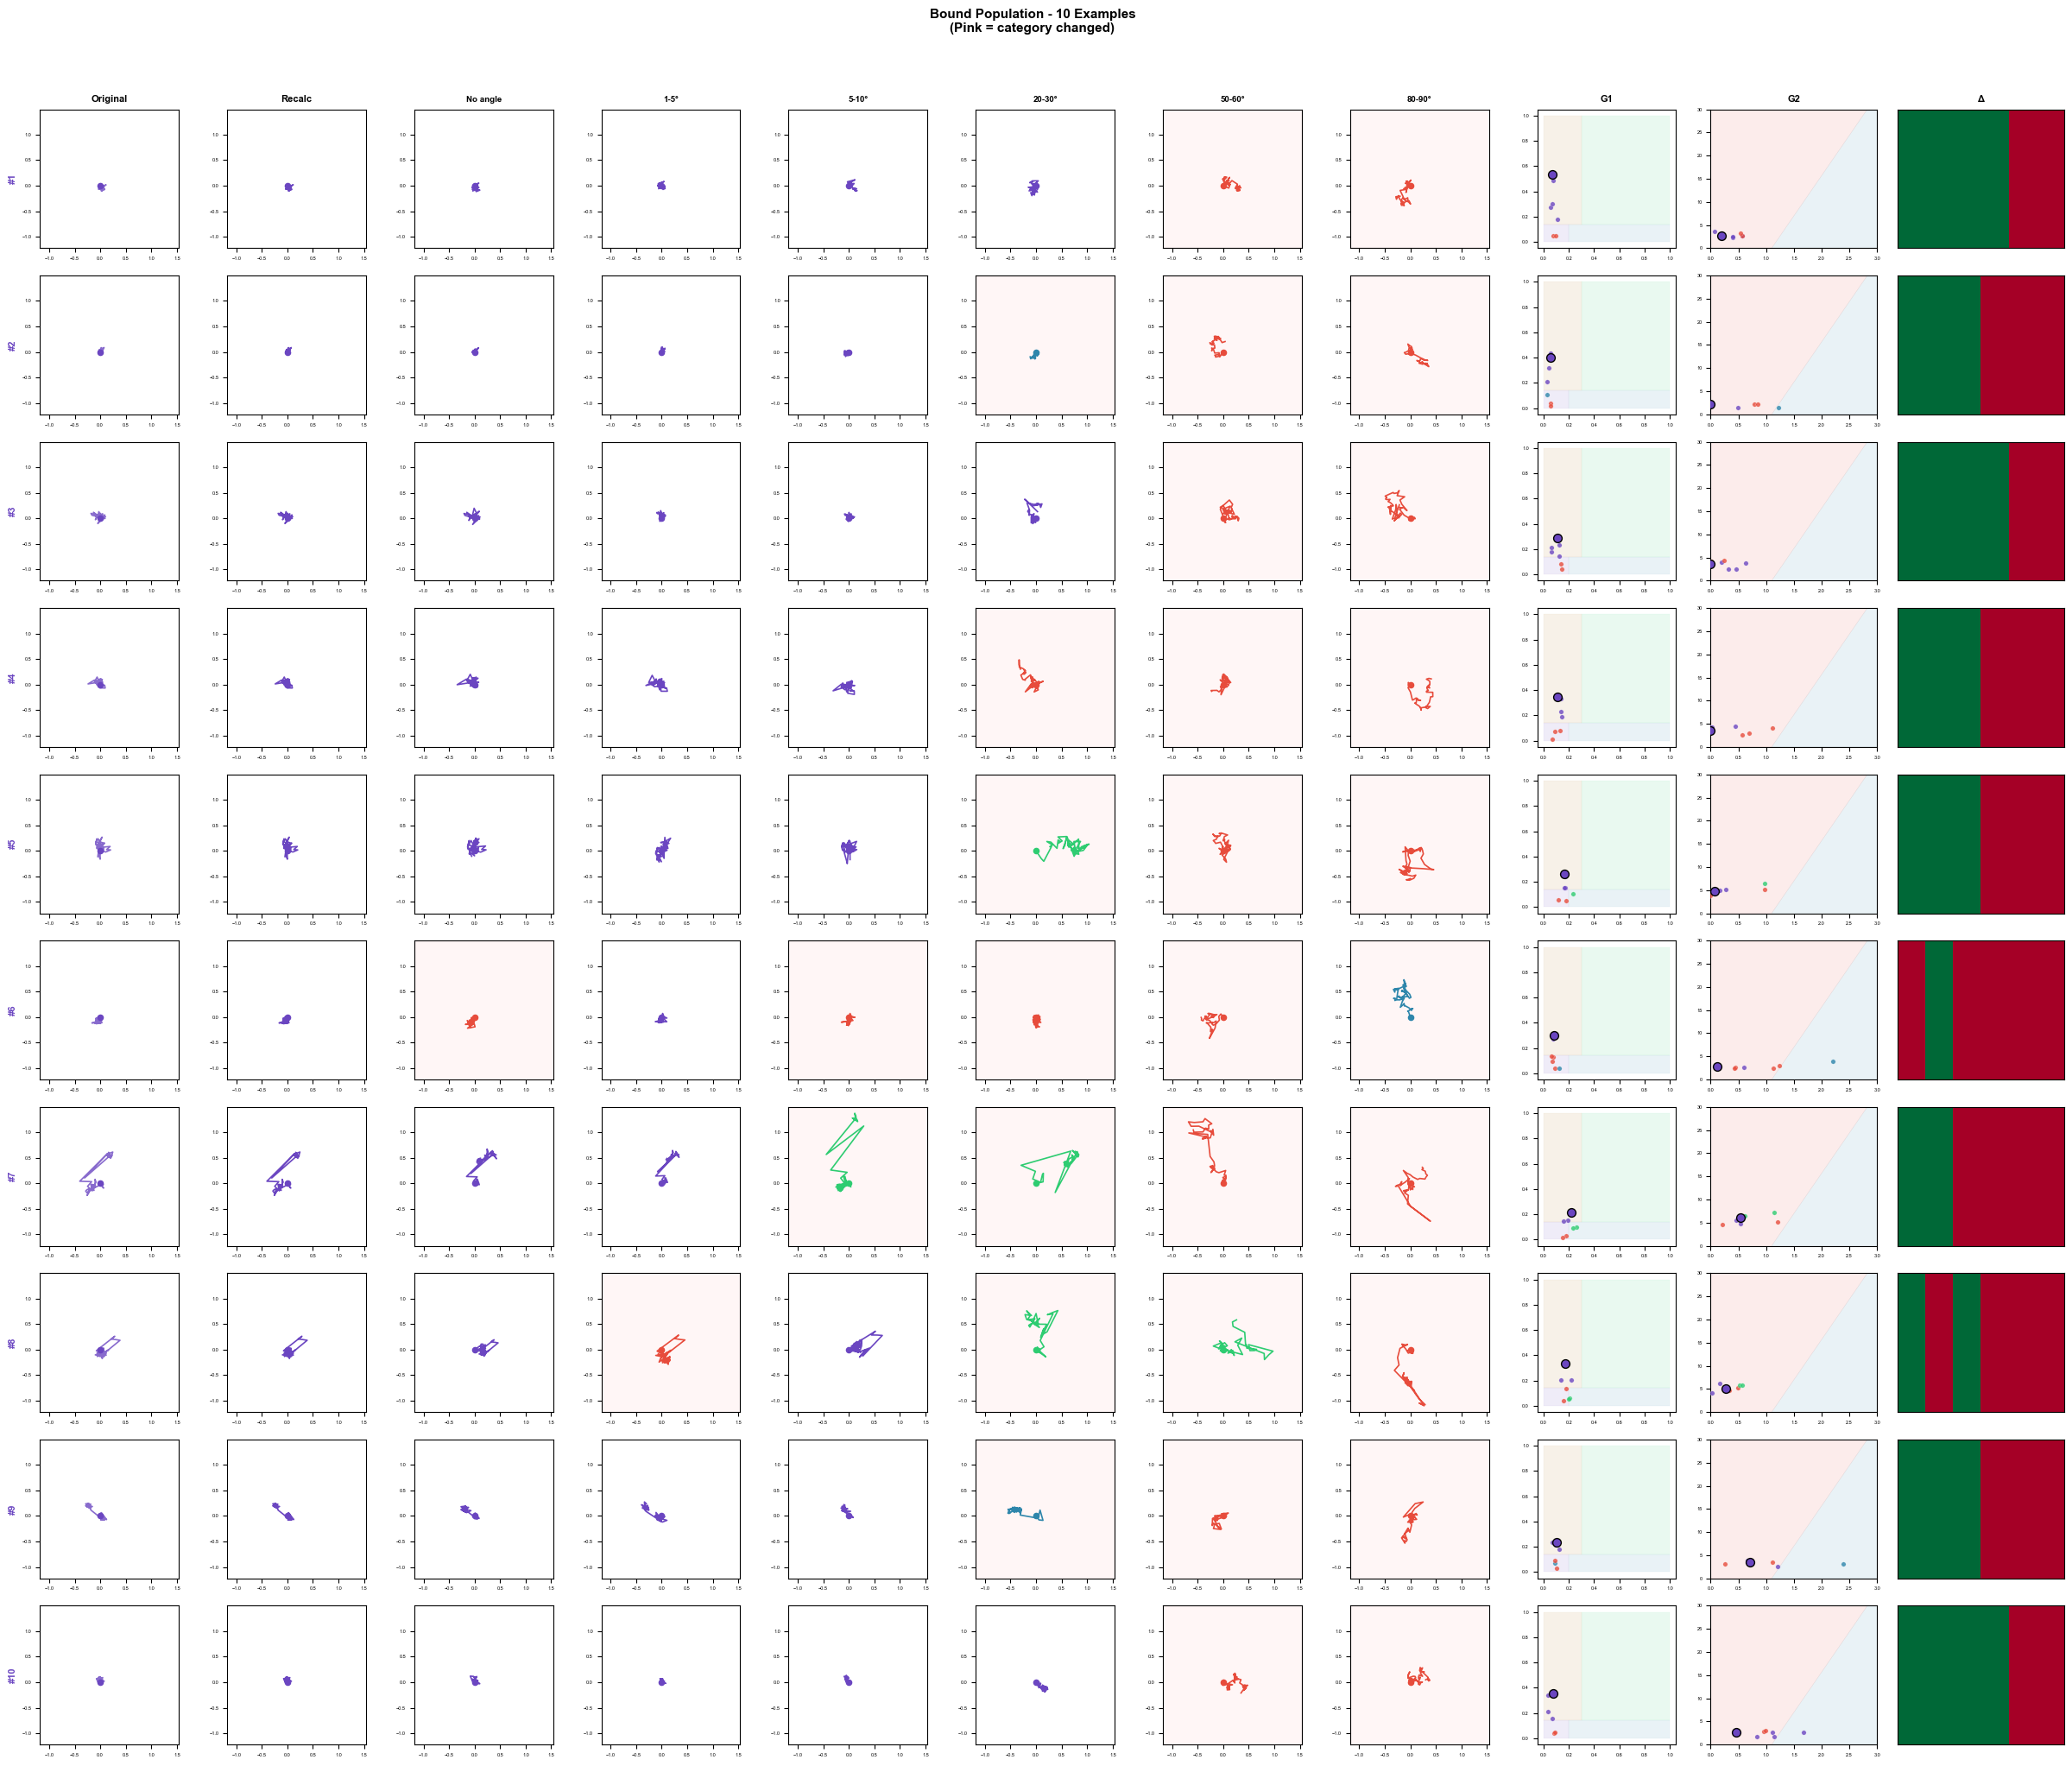


STABILITY SUMMARY:
  shuf_3s_s10_50_a0: 9/10 stable (90%)
  shuf_3s_s10_50_a1_5: 9/10 stable (90%)
  shuf_3s_s10_50_a5_10: 8/10 stable (80%)
  shuf_3s_s10_50_a20_30: 3/10 stable (30%)
  shuf_3s_s10_50_a50_60: 0/10 stable (0%)
  shuf_3s_s10_50_a80_90: 0/10 stable (0%)
SINGLE POPULATION DEEP DIVE: SuperDiff
Available: 59 tracks
Showing: 10 examples
Augmentations: ['shuf_3s_s10_50_a0', 'shuf_3s_s10_50_a1_5', 'shuf_3s_s10_50_a5_10', 'shuf_3s_s10_50_a20_30', 'shuf_3s_s10_50_a50_60', 'shuf_3s_s10_50_a80_90']


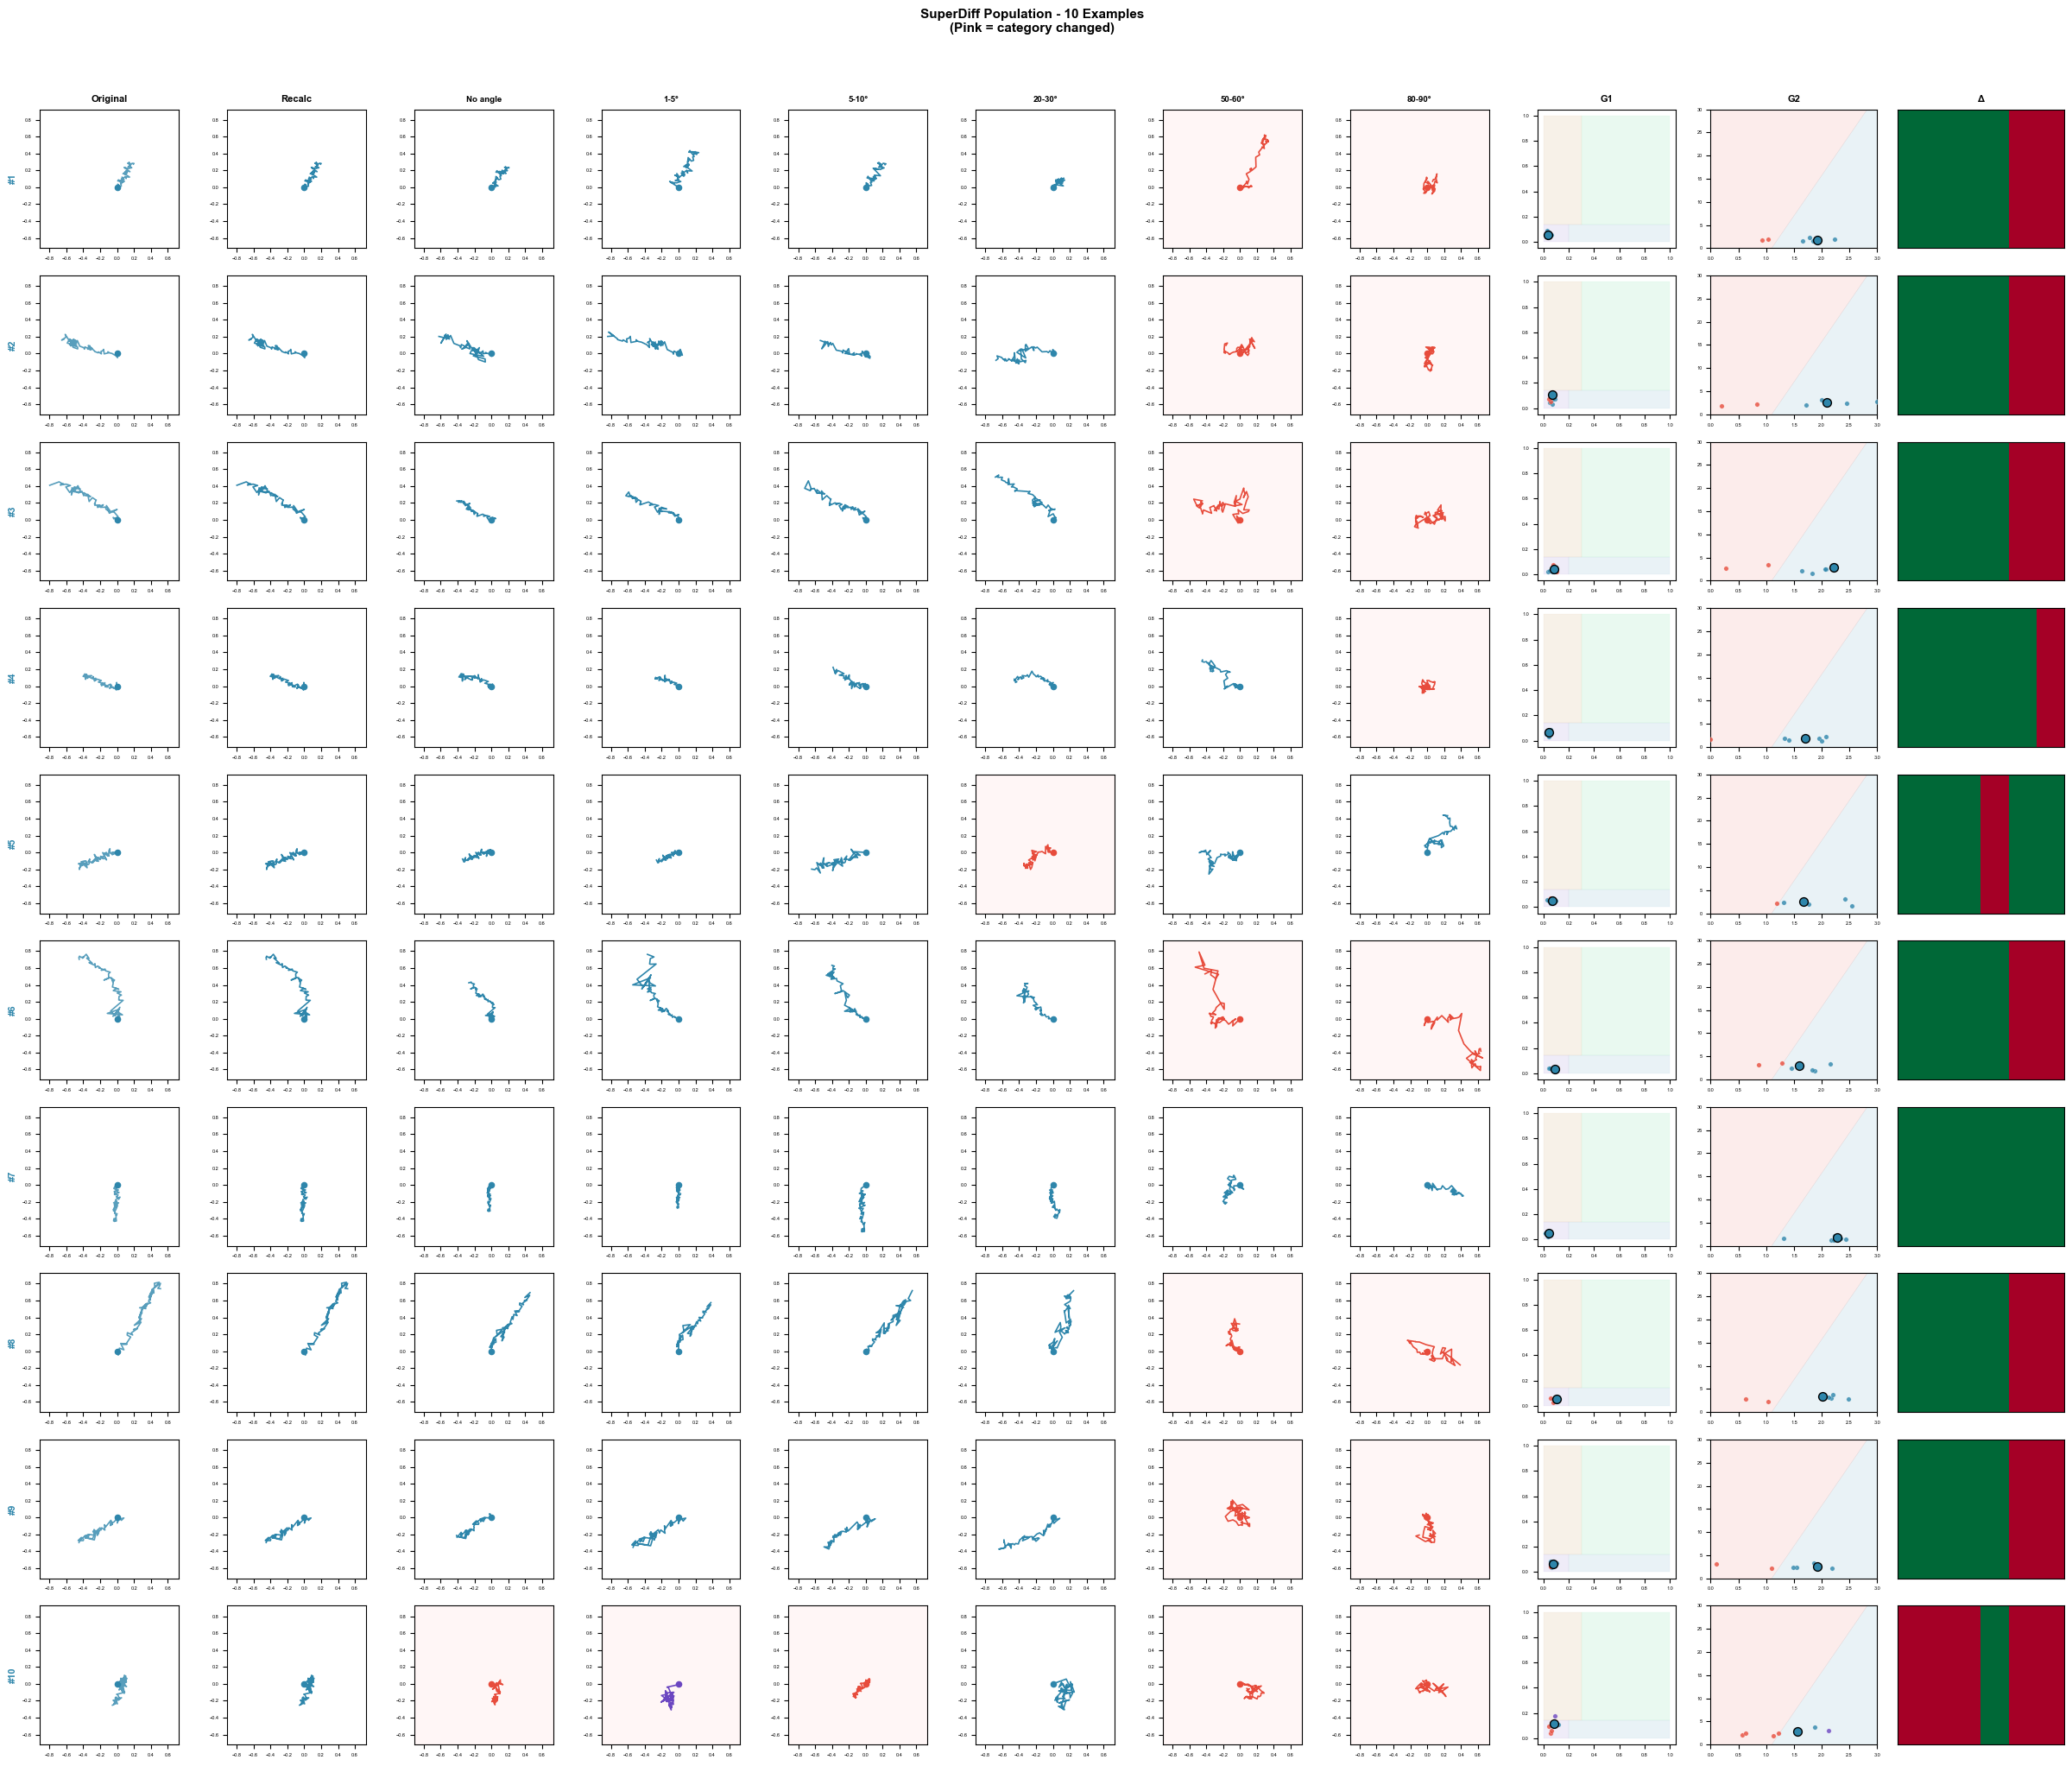


STABILITY SUMMARY:
  shuf_3s_s10_50_a0: 9/10 stable (90%)
  shuf_3s_s10_50_a1_5: 9/10 stable (90%)
  shuf_3s_s10_50_a5_10: 9/10 stable (90%)
  shuf_3s_s10_50_a20_30: 9/10 stable (90%)
  shuf_3s_s10_50_a50_60: 3/10 stable (30%)
  shuf_3s_s10_50_a80_90: 2/10 stable (20%)
SINGLE POPULATION DEEP DIVE: SubDiff
Available: 51 tracks
Showing: 10 examples
Augmentations: ['shuf_3s_s10_50_a0', 'shuf_3s_s10_50_a1_5', 'shuf_3s_s10_50_a5_10', 'shuf_3s_s10_50_a20_30', 'shuf_3s_s10_50_a50_60', 'shuf_3s_s10_50_a80_90']


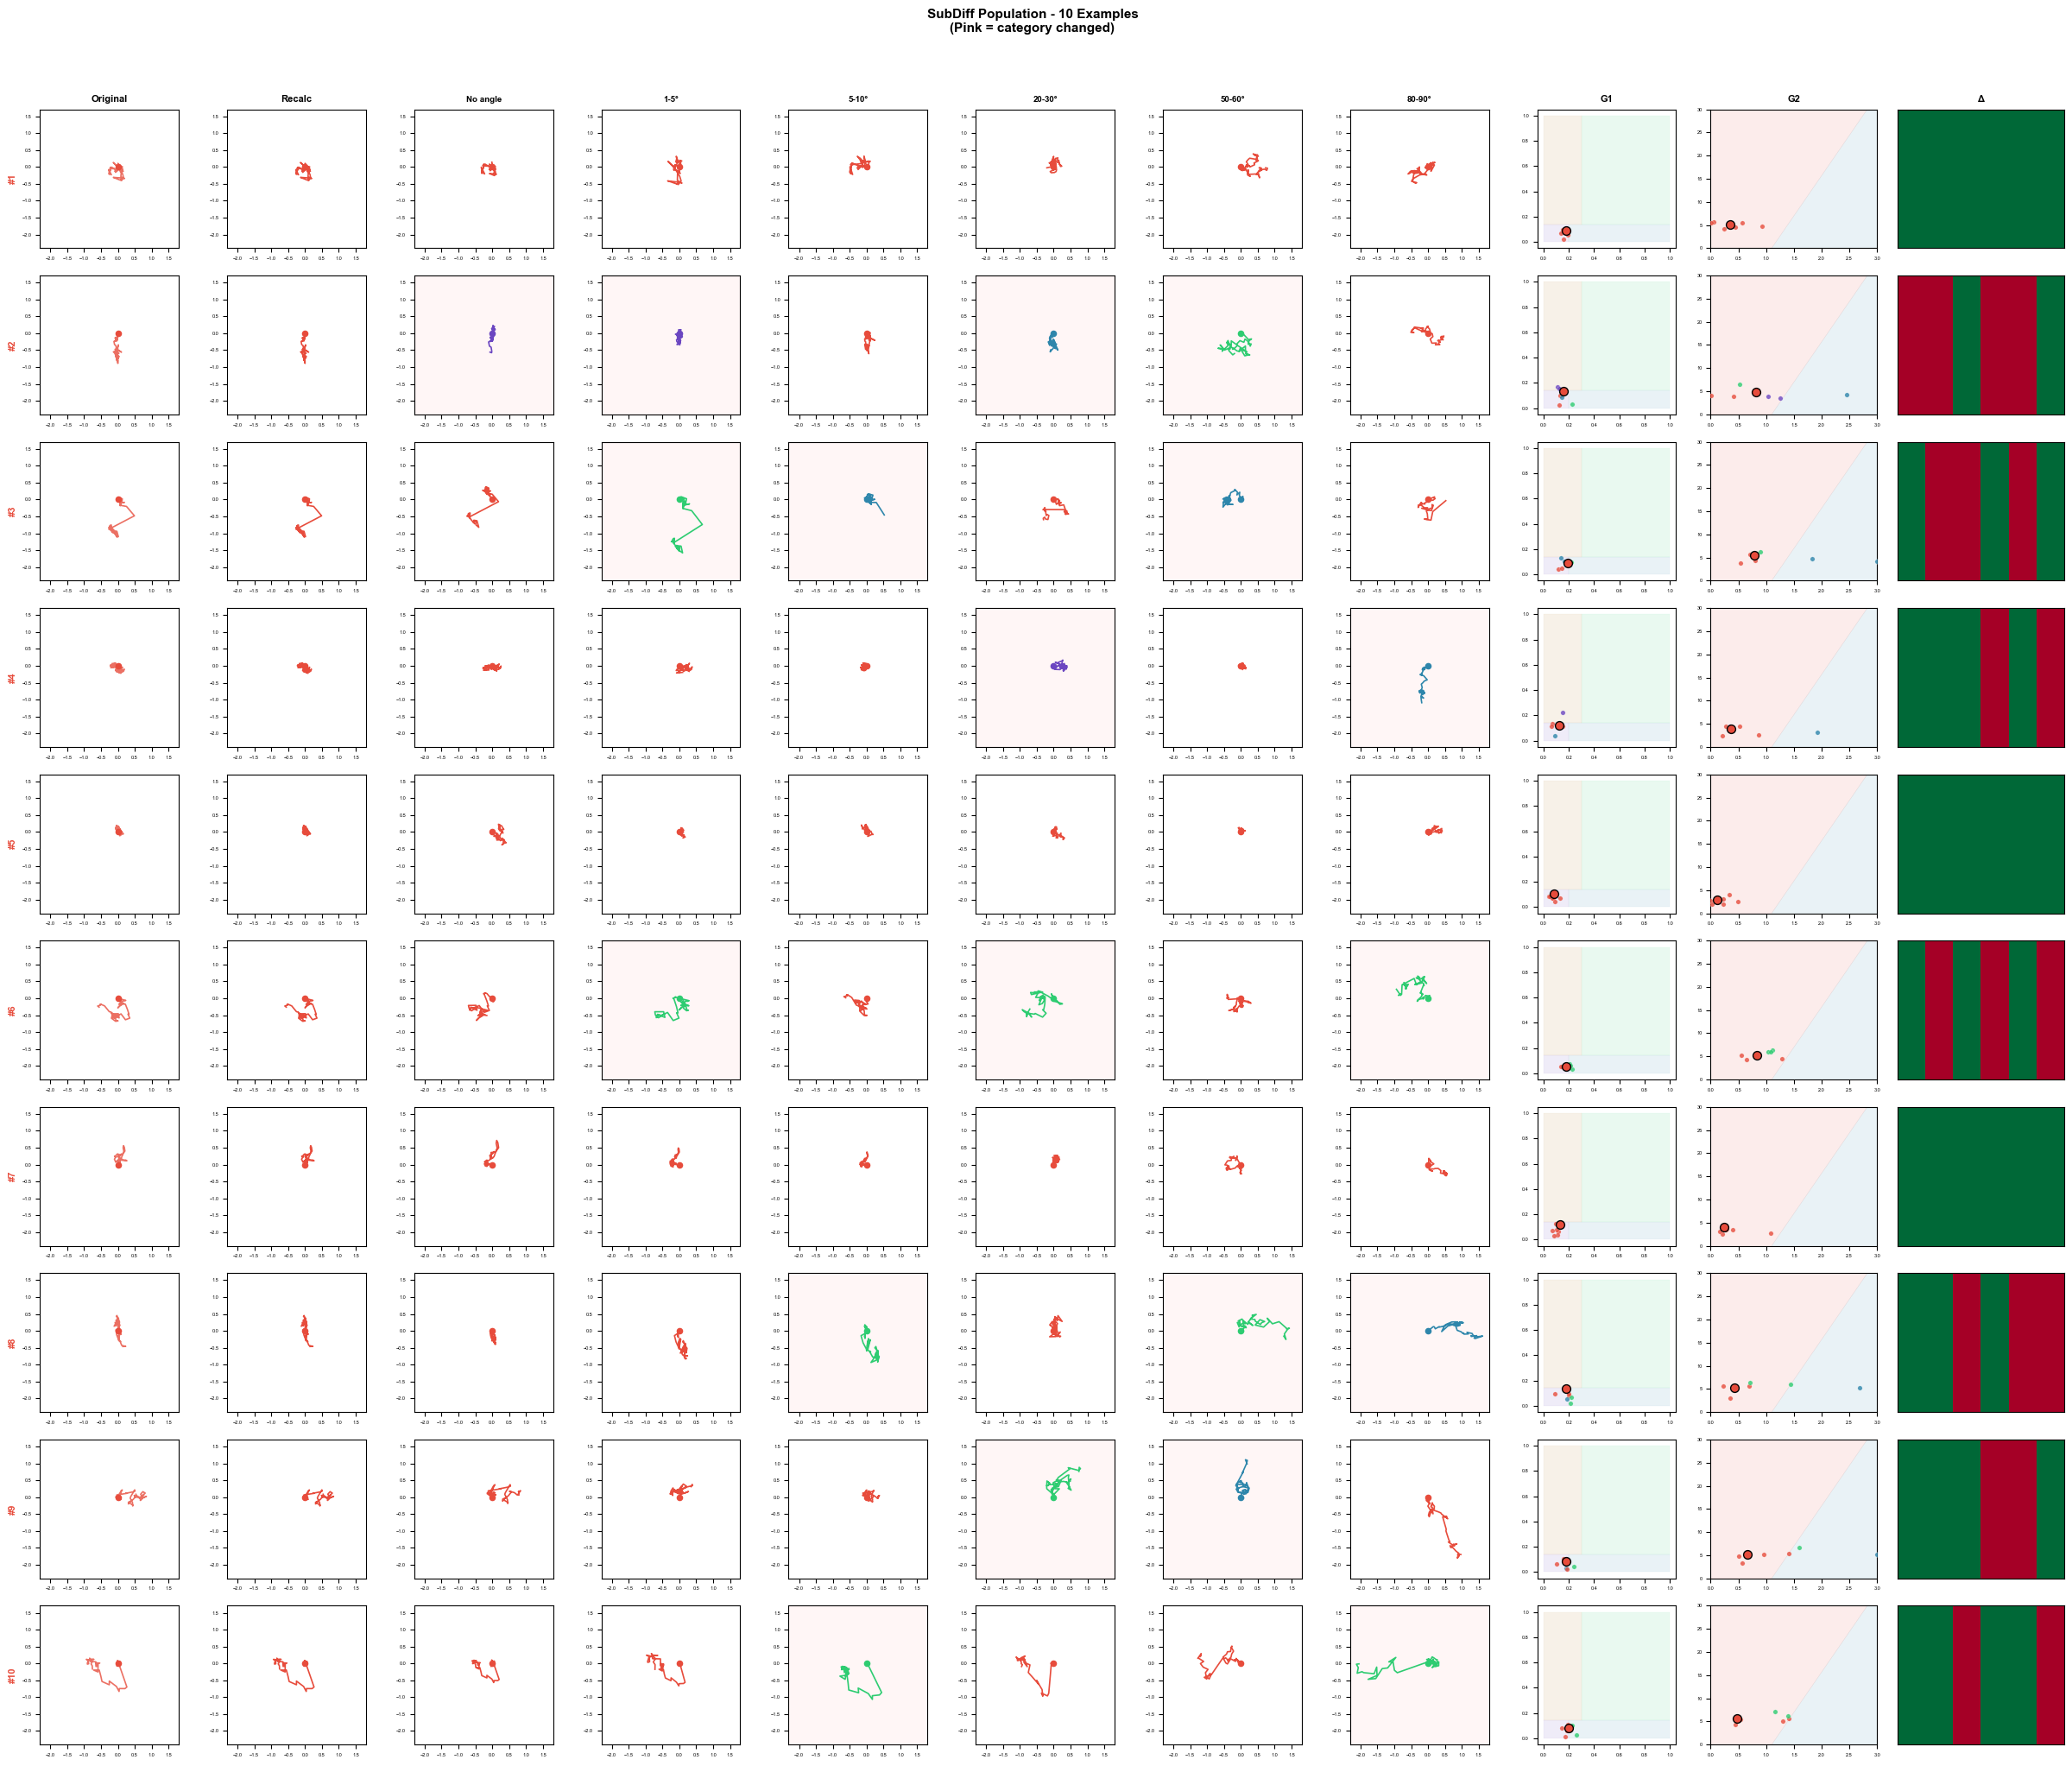


STABILITY SUMMARY:
  shuf_3s_s10_50_a0: 9/10 stable (90%)
  shuf_3s_s10_50_a1_5: 7/10 stable (70%)
  shuf_3s_s10_50_a5_10: 7/10 stable (70%)
  shuf_3s_s10_50_a20_30: 6/10 stable (60%)
  shuf_3s_s10_50_a50_60: 6/10 stable (60%)
  shuf_3s_s10_50_a80_90: 6/10 stable (60%)
SINGLE POPULATION DEEP DIVE: Mixed
Available: 59 tracks
Showing: 10 examples
Augmentations: ['shuf_3s_s10_50_a0', 'shuf_3s_s10_50_a1_5', 'shuf_3s_s10_50_a5_10', 'shuf_3s_s10_50_a20_30', 'shuf_3s_s10_50_a50_60', 'shuf_3s_s10_50_a80_90']


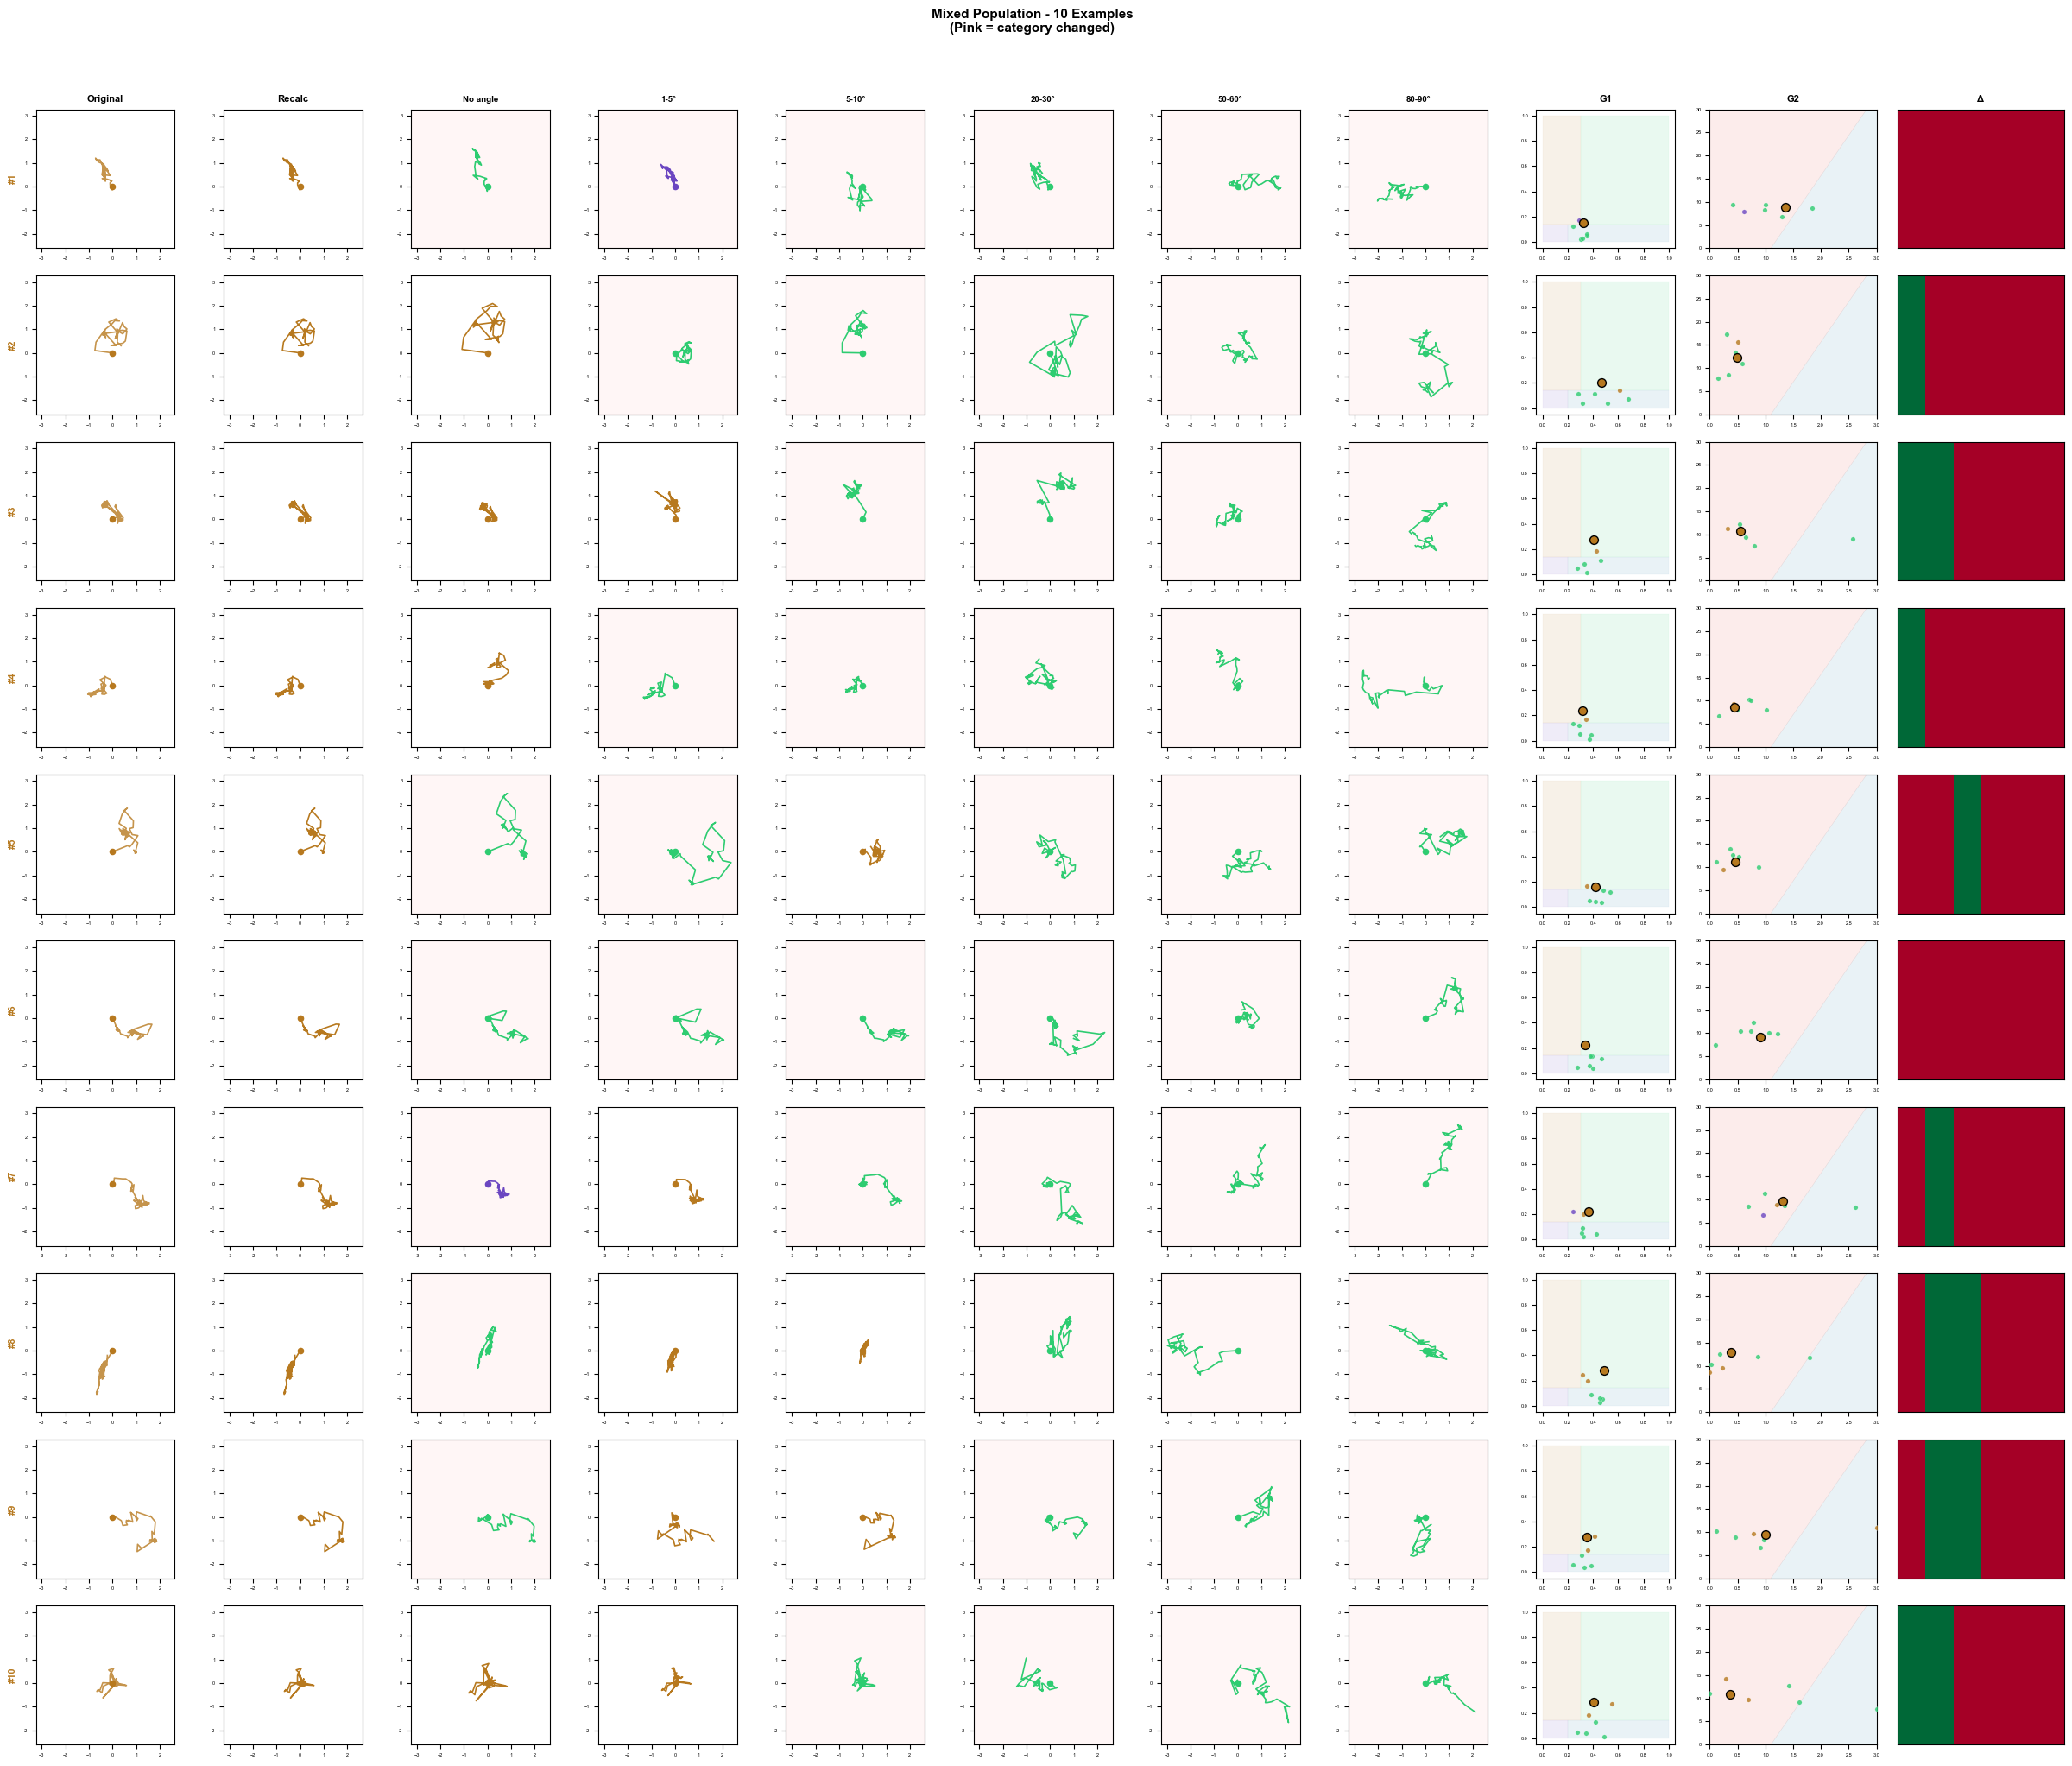


STABILITY SUMMARY:
  shuf_3s_s10_50_a0: 4/10 stable (40%)
  shuf_3s_s10_50_a1_5: 5/10 stable (50%)
  shuf_3s_s10_50_a5_10: 3/10 stable (30%)
  shuf_3s_s10_50_a20_30: 0/10 stable (0%)
  shuf_3s_s10_50_a50_60: 0/10 stable (0%)
  shuf_3s_s10_50_a80_90: 0/10 stable (0%)
SINGLE POPULATION DEEP DIVE: FastExp
Available: 60 tracks
Showing: 10 examples
Augmentations: ['shuf_3s_s10_50_a0', 'shuf_3s_s10_50_a1_5', 'shuf_3s_s10_50_a5_10', 'shuf_3s_s10_50_a20_30', 'shuf_3s_s10_50_a50_60', 'shuf_3s_s10_50_a80_90']


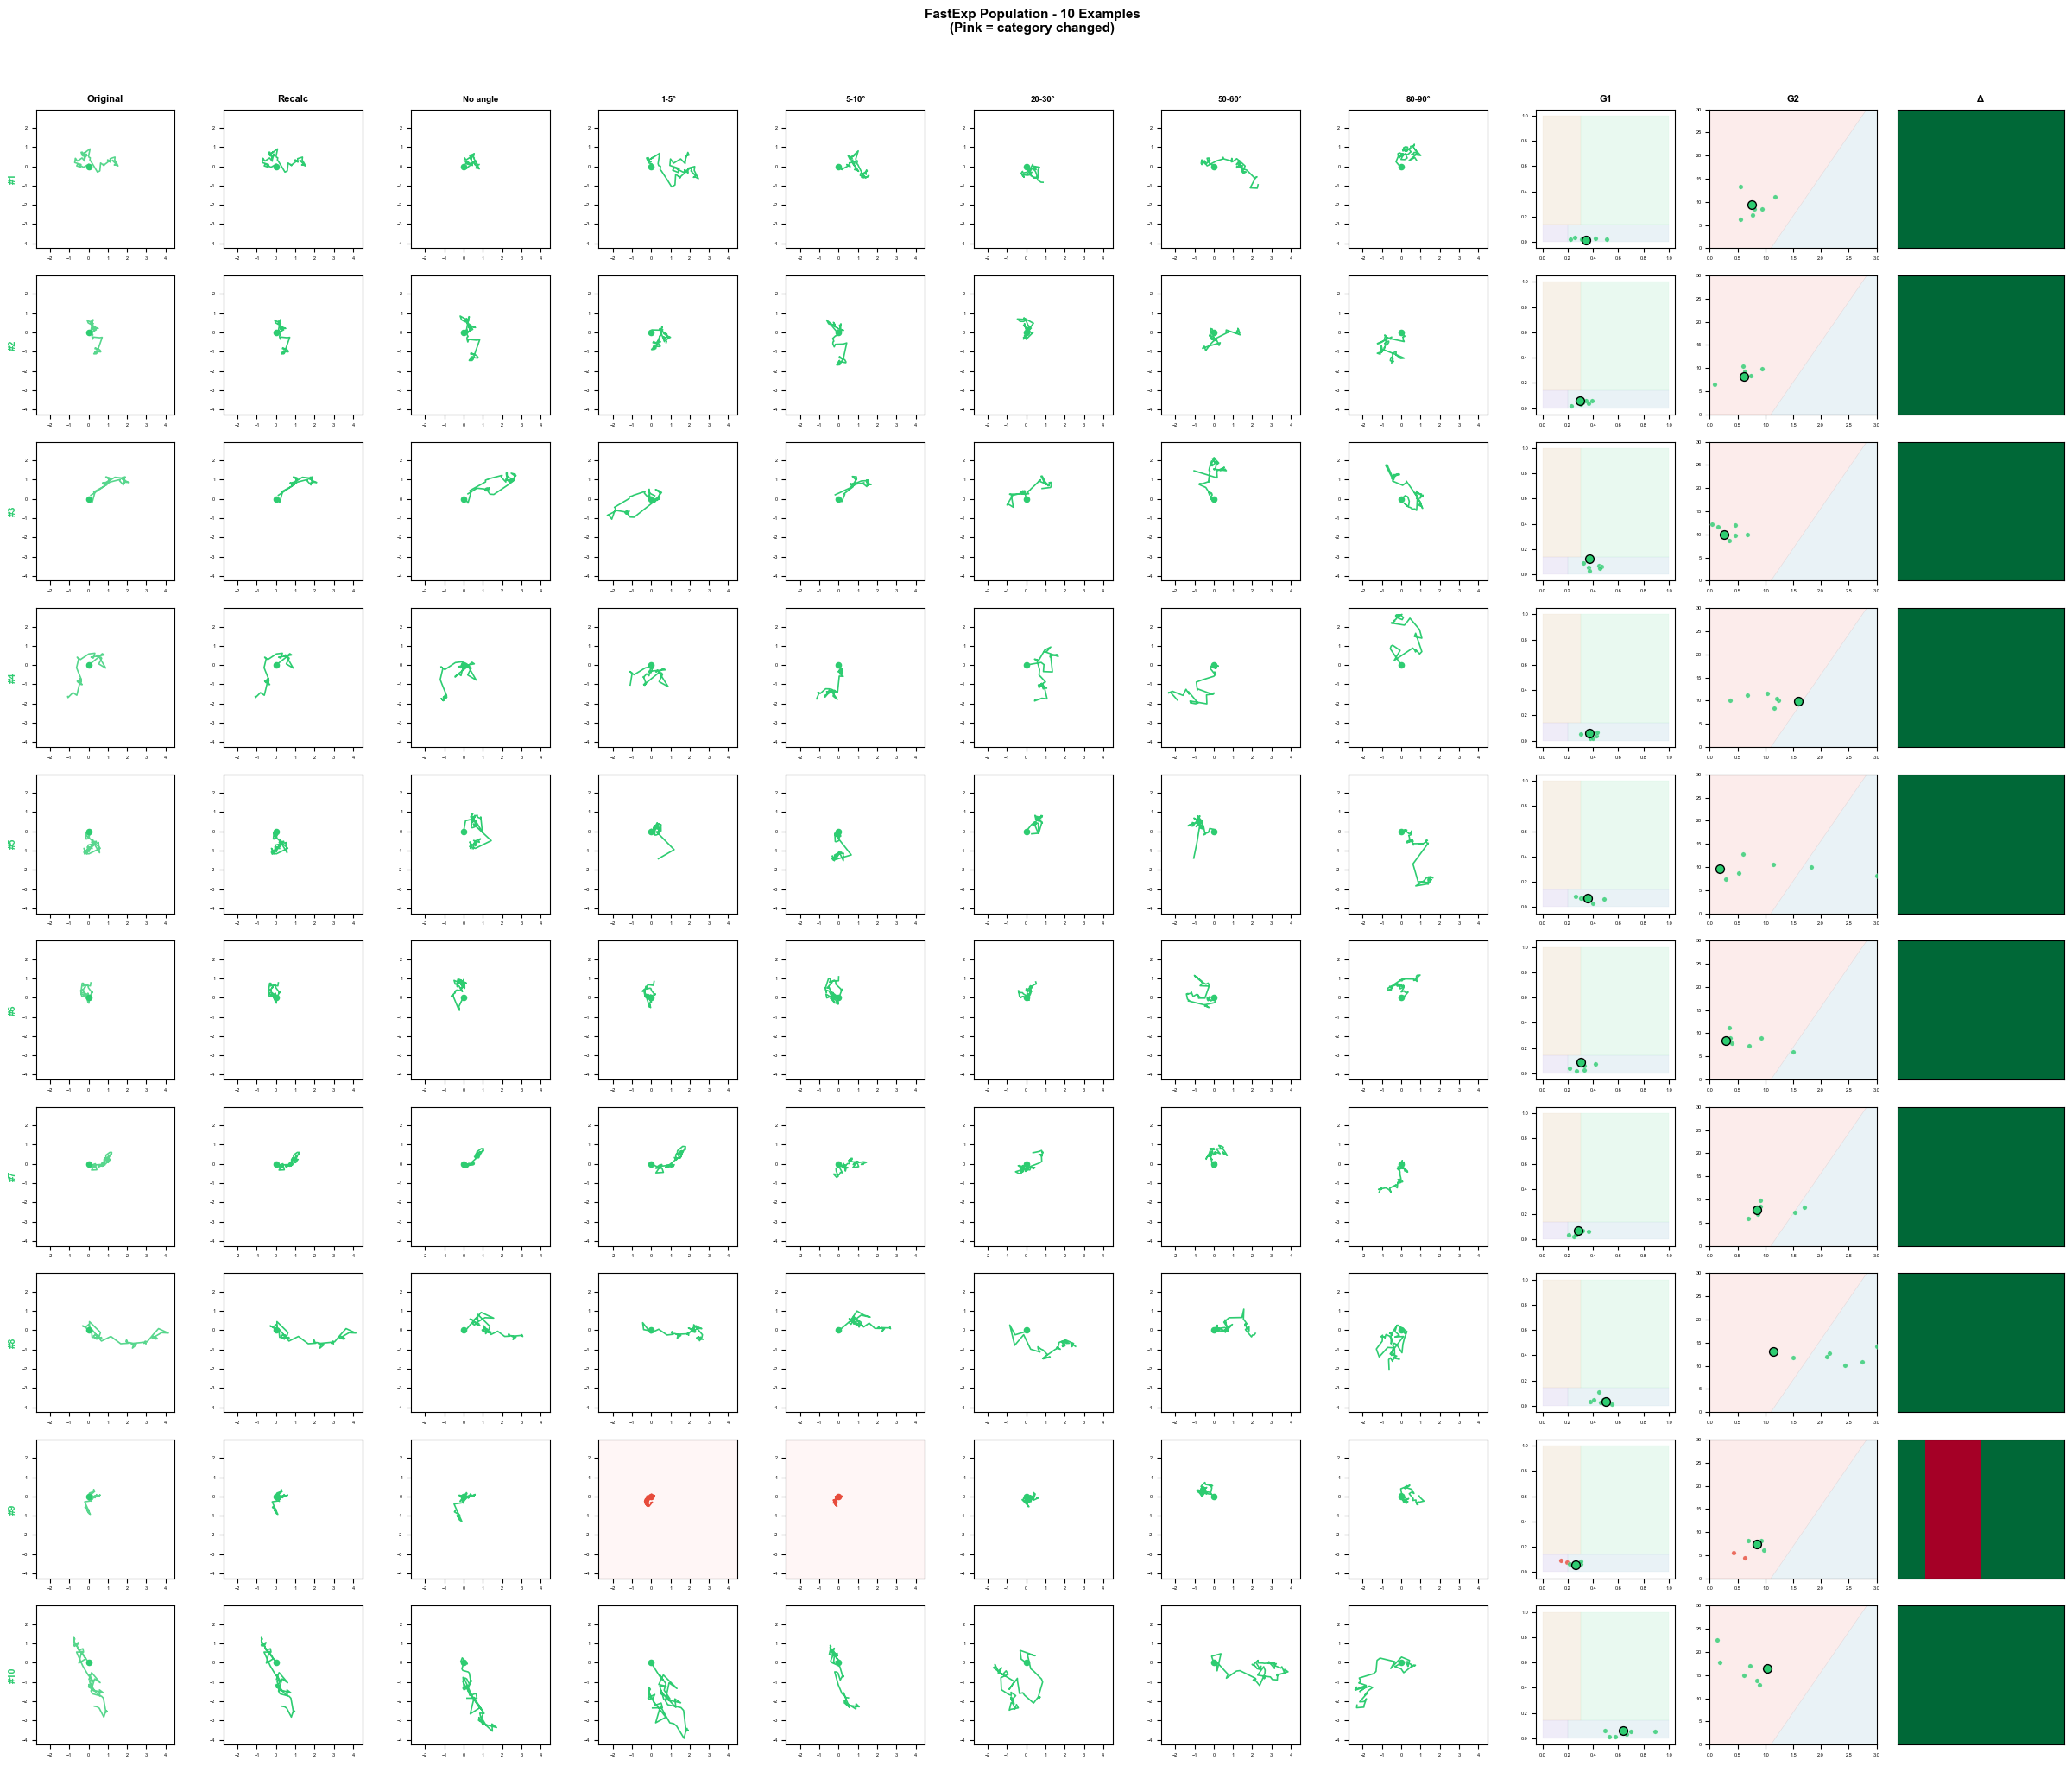


STABILITY SUMMARY:
  shuf_3s_s10_50_a0: 10/10 stable (100%)
  shuf_3s_s10_50_a1_5: 9/10 stable (90%)
  shuf_3s_s10_50_a5_10: 9/10 stable (90%)
  shuf_3s_s10_50_a20_30: 10/10 stable (100%)
  shuf_3s_s10_50_a50_60: 10/10 stable (100%)
  shuf_3s_s10_50_a80_90: 10/10 stable (100%)


In [24]:
# [12B] SINGLE POPULATION DEEP DIVE - Many tracks from ONE population
# Use this to see how augmentations affect many examples of one behavior type

# ============ CONFIGURE THIS ============
for TARGET_POP in ['bound_stationary', 'superdiffusive_transport', 'subdiffusive_motion', 'mixed_exploratory_bound', 'fast_exploratory']:
    N_EXAMPLES = 10  # Number of track examples to show
    # Titration: ±50% scale + angular noise with GUARANTEED RANGES
    # TARGET_AUGS = [
    #     'shuf_s50_a0',      # No noise baseline
    #     'shuf_s50_a2_5',    # 2-5° guaranteed
    #     'shuf_s50_a5_10',   # 5-10° guaranteed
    #     'shuf_s50_a10_15',  # 10-15° guaranteed
    #     'shuf_s50_a15_20',  # 15-20° guaranteed
    #     'shuf_s50_a20_25',  # 20-25° guaranteed
    #     'shuf_s50_a25_30',  # 25-30° guaranteed
    #     'shuf_only',        # Reference: shuffle only
    # ]
    # ========================================
    # Use all augmentations from config (2, 3, and 4 segment shuffles with all scaling options)
    TARGET_AUGS = list(SEGMENT_SHUFFLE_CONFIG.keys())

    print("="*70)
    print(f"SINGLE POPULATION DEEP DIVE: {POP_ABBREV.get(TARGET_POP, TARGET_POP)}")
    print("="*70)

    # Get tracks from this population (by RECALCULATED classification)
    pop_tracks = tracks_by_recalc_pop.get(TARGET_POP, []).copy()
    np.random.shuffle(pop_tracks)
    viz_tracks_single = pop_tracks[:N_EXAMPLES]

    print(f"Available: {len(pop_tracks)} tracks")
    print(f"Showing: {len(viz_tracks_single)} examples")
    print(f"Augmentations: {TARGET_AUGS}")

    if len(viz_tracks_single) == 0:
        print(f"❌ No tracks found for {TARGET_POP}!")
    else:
        n_rows = len(viz_tracks_single)
        n_aug = len(TARGET_AUGS)
        n_cols = 2 + n_aug + 3  # Original | Recalc | Augs | Gate1 | Gate2 | Heatmap
        
        # Pre-cache tracks and compute global limits
        cache = {}
        gmin_x, gmax_x, gmin_y, gmax_y = np.inf, -np.inf, np.inf, -np.inf
        
        for uid in viz_tracks_single:
            tdf = get_window_frames(instant_df, uid)
            if tdf.height == 0: continue
            x, y = tdf['x_um'].to_numpy(), tdf['y_um'].to_numpy()
            xc, yc = x - x[0], y - y[0]
            cache[uid] = {'x': x, 'y': y, 'xc': xc, 'yc': yc, 'dt': tdf['delta_time_s'].to_numpy(), 'aug': {}}
            gmin_x, gmax_x = min(gmin_x, xc.min()), max(gmax_x, xc.max())
            gmin_y, gmax_y = min(gmin_y, yc.min()), max(gmax_y, yc.max())
            for a in TARGET_AUGS:
                seed = hash(f'{uid}_{a}') % 2**32
                xa, ya = apply_aug(x, y, a, seed)
                xac, yac = xa - xa[0], ya - ya[0]
                cache[uid]['aug'][a] = {'xc': xac, 'yc': yac}
                gmin_x, gmax_x = min(gmin_x, xac.min()), max(gmax_x, xac.max())
                gmin_y, gmax_y = min(gmin_y, yac.min()), max(gmax_y, yac.max())
        
        rng = max(gmax_x - gmin_x, gmax_y - gmin_y) * 1.1
        cx, cy = (gmax_x + gmin_x) / 2, (gmax_y + gmin_y) / 2
        xlim, ylim = (cx - rng/2, cx + rng/2), (cy - rng/2, cy + rng/2)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.2*n_cols, 2.0*n_rows))
        if n_rows == 1: axes = axes.reshape(1, -1)
        
        pop_color = POP_COLORS.get(TARGET_POP, '#888')
        
        for ri, uid in enumerate(viz_tracks_single):
            if uid not in cache: continue
            c = cache[uid]
            
            # Get recalculated data
            rec = classified_df.filter(pl.col('window_uid') == f'{uid}_recalculated')
            rec_pop = rec['final_population'][0] if rec.height > 0 else TARGET_POP
            
            # Get original data
            orig_row = windowed_df.filter(pl.col('window_uid') == uid)
            orig_pop = orig_row['final_population'][0] if orig_row.height > 0 else 'unknown'
            orig_color = POP_COLORS.get(orig_pop, '#888')
            
            ci = 0
            
            # Column 0: ORIGINAL track
            ax = axes[ri, ci]
            ax.plot(c['xc'], c['yc'], color=orig_color, lw=1.2, alpha=0.8)
            ax.scatter([0], [0], c=orig_color, s=20, marker='o', zorder=5)
            ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
            if ri == 0: ax.set_title('Original', fontsize=8, fontweight='bold')
            ax.set_ylabel(f'#{ri+1}', fontsize=8, color=pop_color, fontweight='bold')
            ax.tick_params(labelsize=4); ci += 1
            
            # Column 1: RECALCULATED track
            ax = axes[ri, ci]
            ax.plot(c['xc'], c['yc'], color=pop_color, lw=1.2)
            ax.scatter([0], [0], c=pop_color, s=20, marker='o', zorder=5)
            ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
            if ri == 0: ax.set_title('Recalc', fontsize=8, fontweight='bold')
            ax.tick_params(labelsize=4); ci += 1
            
            # Augmented tracks
            for a in TARGET_AUGS:
                ax = axes[ri, ci]
                ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
                aug_pop = ar['final_population'][0] if ar.height > 0 else 'unknown'
                aug_color = POP_COLORS.get(aug_pop, '#888')
                ad = c['aug'].get(a, {})
                if 'xc' in ad:
                    ax.plot(ad['xc'], ad['yc'], color=aug_color, lw=1.2)
                    ax.scatter([0], [0], c=aug_color, s=20, zorder=5)
                ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect('equal')
                # Shorter label: shuf_s50_a10_15 → 10-15°
                # short = a.replace('shuf_s50_a', '').replace('_', '-') + ('°' if a.startswith('shuf_s50_a') and a != 'shuf_s50_a0' else '')
                # if a == 'shuf_s50_a0': short = 'scale'
                # short = short.replace('shuf_only', 'shuf')
                    # Use helper function for labels
                if a in SEGMENT_SHUFFLE_CONFIG:
                    try:
                        short = get_scale_label(a)
                    except:
                        short = a.replace('shuf_', '').replace('_a0', '').replace('_', '-')
                else:
                    short = a.replace('shuf_s50_a', '').replace('_', '-') + ('°' if a.startswith('shuf_s50_a') and a != 'shuf_s50_a0' else '')
                    if a == 'shuf_s50_a0': short = 'scale'
                    short = short.replace('shuf_only', 'shuf')
                if ri == 0: ax.set_title(short, fontsize=7, fontweight='bold')
                if aug_pop != rec_pop: 
                    ax.patch.set_facecolor('#FFEEEE'); ax.patch.set_alpha(0.5)
                ax.tick_params(labelsize=4); ci += 1
            
            # Gate 1 plot
            ax = axes[ri, ci]
            for g, p in GATE1_RECTS.items():
                ax.add_patch(Rectangle((p['x'][0], p['y'][0]), p['x'][1]-p['x'][0], p['y'][1]-p['y'][0], alpha=0.1, fc=p['color'], ec=p['color'], lw=0.3))
            if rec.height > 0:
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    sc = scaler.transform([[rec['avg_speed_um_s'][0], rec['self_intersections'][0]]])[0]
                ax.scatter(sc[0], sc[1], c=pop_color, s=50, marker='o', ec='black', lw=1, zorder=10)
            for a in TARGET_AUGS:
                ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
                if ar.height > 0:
                    ap = ar['final_population'][0]; ac = POP_COLORS.get(ap, '#888')
                    with warnings.catch_warnings():
                        warnings.simplefilter('ignore')
                        sc = scaler.transform([[ar['avg_speed_um_s'][0], ar['self_intersections'][0]]])[0]
                    ax.scatter(sc[0], sc[1], c=ac, s=15, ec='white', lw=0.2, alpha=0.8, zorder=5)
            ax.set_xlim(-0.05, 1.05); ax.set_ylim(-0.05, 1.05); ax.set_aspect('equal')
            if ri == 0: ax.set_title('G1', fontsize=8, fontweight='bold')
            ax.tick_params(labelsize=4); ci += 1
            
            # Gate 2 plot
            ax = axes[ri, ci]
            ax.add_patch(Polygon(GATE2_BOUNDS['superdiffusive'], alpha=0.1, fc='#2E86AB', ec='#2E86AB', lw=0.3))
            ax.add_patch(Polygon(GATE2_BOUNDS['subdiffusive'], alpha=0.1, fc='#E74C3C', ec='#E74C3C', lw=0.3))
            if rec.height > 0:
                ax.scatter(rec['anomalous_exponent'][0], rec['cum_displacement_um'][0], c=pop_color, s=50, marker='o', ec='black', lw=1, zorder=10)
            for a in TARGET_AUGS:
                ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
                if ar.height > 0:
                    ap = ar['final_population'][0]; ac = POP_COLORS.get(ap, '#888')
                    ax.scatter(ar['anomalous_exponent'][0], ar['cum_displacement_um'][0], c=ac, s=15, ec='white', lw=0.2, alpha=0.8, zorder=5)
            ax.set_xlim(0, 3); ax.set_ylim(0, 30)
            if ri == 0: ax.set_title('G2', fontsize=8, fontweight='bold')
            ax.tick_params(labelsize=4); ci += 1
            
            # Heatmap
            ax = axes[ri, ci]
            aug_changes = []
            for a in TARGET_AUGS:
                ar = classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')
                aug_changes.append(1 if ar.height > 0 and ar['final_population'][0] != rec_pop else 0)
            ax.imshow([aug_changes], cmap='RdYlGn_r', vmin=0, vmax=1, aspect='auto')
            ax.set_xticks([]); ax.set_yticks([])
            if ri == 0: ax.set_title('Δ', fontsize=8, fontweight='bold')
        
        plt.suptitle(f'{POP_ABBREV.get(TARGET_POP, TARGET_POP)} Population - {N_EXAMPLES} Examples\n(Pink = category changed)', 
                    fontsize=11, fontweight='bold', y=1.02)
        plt.tight_layout()
        safe = TARGET_POP.replace('_', '')
        fig.savefig(OUTPUT_FOLDER / f'single_pop_{safe}_{N_EXAMPLES}ex.svg', format='svg', bbox_inches='tight')
        plt.show()
        
        # Summary stats
        print("\n" + "="*70)
        print("STABILITY SUMMARY:")
        print("="*70)
        for a in TARGET_AUGS:
            stable = sum(1 for uid in viz_tracks_single 
                        if classified_df.filter(pl.col('window_uid') == f'{uid}_{a}').height > 0 and
                        classified_df.filter(pl.col('window_uid') == f'{uid}_{a}')['final_population'][0] == 
                        classified_df.filter(pl.col('window_uid') == f'{uid}_recalculated')['final_population'][0])
            short = a.replace('shuf_scale_', '±').replace('pct', '%').replace('shuf_only_4seg', 'shuffle only')
            print(f"  {short}: {stable}/{len(viz_tracks_single)} stable ({100*stable/len(viz_tracks_single):.0f}%)")
        print("="*70)

In [26]:
# [DECISION HELPER] Which augmentations to use for training?
# Goal: "As different as possible while still remaining same category"

print("="*70)
print("AUGMENTATION SELECTION ANALYSIS")
print("Goal: Maximize diversity while preserving category")
print("="*70)

# Calculate stability for each augmentation
aug_stability = []
for aug_name, counts in results_by_aug.items():
    total = counts['stable'] + counts['changed']
    if total > 0:
        stability = 100 * counts['stable'] / total
        aug_stability.append((aug_name, stability, counts['stable'], counts['changed']))

# Sort by stability (highest = most safe)
aug_stability.sort(key=lambda x: -x[1])

print(f"\n{'Augmentation':<25} {'Stable':>8} {'Changed':>8} {'Stability':>10} {'Recommendation':<25}")
print("-" * 85)
for aug, stab, stable, changed in aug_stability:
    if stab >= 95:
        rec = "✅ EXCELLENT"
    elif stab >= 90:
        rec = "✅ GOOD"
    elif stab >= 80:
        rec = "⚠️ MODERATE"
    elif stab >= 70:
        rec = "⚠️ RISKY"
    else:
        rec = "❌ AVOID"
    print(f"{aug:<25} {stable:>8} {changed:>8} {stab:>9.1f}%  {rec}")

# Group by recommendation tier
excellent = [(a, s) for a, s, _, _ in aug_stability if s >= 95]
good = [(a, s) for a, s, _, _ in aug_stability if 90 <= s < 95]
moderate = [(a, s) for a, s, _, _ in aug_stability if 80 <= s < 90]
risky = [(a, s) for a, s, _, _ in aug_stability if s < 80]

print("\n" + "="*70)
print("RECOMMENDATIONS FOR NETWORK TRAINING")
print("="*70)

if excellent:
    print(f"\n✅ TIER 1 - Use freely (≥95% stability):")
    for a, s in excellent:
        print(f"   {a}: {s:.1f}%")
    
if good:
    print(f"\n✅ TIER 2 - Recommended (90-95%):")
    for a, s in good:
        print(f"   {a}: {s:.1f}%")
    
if moderate:
    print(f"\n⚠️ TIER 3 - Use sparingly (80-90%):")
    for a, s in moderate:
        print(f"   {a}: {s:.1f}%")

if risky:
    print(f"\n❌ AVOID - Too disruptive (<80%):")
    for a, s in risky:
        print(f"   {a}: {s:.1f}%")

print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
SUGGESTED TRAINING COMBINATIONS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

CONSERVATIVE (safest):
  • circular_25, circular_50 - preserves everything, just shifts start
  • adjacent_1swap - minimal disruption
  
BALANCED (recommended for most cases):
  • circular_* + adjacent_1-2swap + shuffle_2-3seg
  • Good diversity without excessive category changes
  
AGGRESSIVE (if model overfits):
  • Add shuffle_4-6seg to the above
  • Monitor validation closely for category confusion

KEY INSIGHT: CIRCULAR augmentations are special!
  → They create visually different tracks
  → BUT preserve ALL computed features (speed, alpha, displacement, intersections)
  → Perfect for teaching start-point invariance without changing labels

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")
print("="*70)

AUGMENTATION SELECTION ANALYSIS
Goal: Maximize diversity while preserving category

Augmentation                Stable  Changed  Stability Recommendation           
-------------------------------------------------------------------------------------
shuf_3s_s10_50_a0              210       79      72.7%  ⚠️ RISKY
shuf_3s_s10_50_a1_5            202       87      69.9%  ❌ AVOID
shuf_3s_s10_50_a5_10           195       94      67.5%  ❌ AVOID
shuf_3s_s10_50_a20_30          165      124      57.1%  ❌ AVOID
shuf_3s_s10_50_a50_60          113      176      39.1%  ❌ AVOID
shuf_3s_s10_50_a80_90           93      196      32.2%  ❌ AVOID

RECOMMENDATIONS FOR NETWORK TRAINING

❌ AVOID - Too disruptive (<80%):
   shuf_3s_s10_50_a0: 72.7%
   shuf_3s_s10_50_a1_5: 69.9%
   shuf_3s_s10_50_a5_10: 67.5%
   shuf_3s_s10_50_a20_30: 57.1%
   shuf_3s_s10_50_a50_60: 39.1%
   shuf_3s_s10_50_a80_90: 32.2%

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
SUGGESTED TRAINING COMBINATIONS:
━━

In [27]:
# [13] VERIFICATION: FEATURE RECALCULATION ACCURACY
# Compare ORIGINAL features (from windowed_df) vs RECALCULATED features (our compute_features)
# This checks if our calculation method matches the original pipeline

print("="*70)
print("VERIFICATION: FEATURE RECALCULATION ACCURACY")
print("="*70)
print("Comparing: Original features (from windowed_df) vs Recalculated (compute_features)")
print("Using actual delta_time_s from each track for exact calculation\n")

# Features to compare
FEATURES = ['avg_speed_um_s', 'cum_displacement_um', 'self_intersections', 'anomalous_exponent']

print(f"{'Track':<35} | {'Feature':<20} | {'Original':<12} | {'Recalc':<12} | {'Diff':<12}")
print("-" * 100)

all_diffs = {f: [] for f in FEATURES}
n_shown = 0

for pop in POP_ORDER[:3]:  # Show 3 populations
    pop_uids = selected_parents.get(pop, [])[:2]  # 2 tracks per pop
    
    for uid in pop_uids:
        # Get original row from windowed_df
        orig_row = windowed_df.filter(pl.col('window_uid') == uid)
        if orig_row.height == 0:
            continue
        
        # Get track data and recalculate
        tdf = get_window_frames(instant_df, uid)
        if tdf.height == 0:
            continue
        x, y = tdf['x_um'].to_numpy(), tdf['y_um'].to_numpy()
        dt = tdf['delta_time_s'].to_numpy()
        
        recalc = compute_features(x, y, dt)
        
        uid_short = uid[:33] + ".." if len(uid) > 35 else uid
        
        for i, feat in enumerate(FEATURES):
            orig_val = orig_row[feat][0]
            recalc_val = recalc[feat]
            
            if orig_val is not None and not np.isnan(orig_val):
                diff = recalc_val - orig_val
                pct_diff = 100 * diff / orig_val if orig_val != 0 else 0
                all_diffs[feat].append(diff)
                
                status = "✅" if abs(pct_diff) < 5 else "⚠️" if abs(pct_diff) < 20 else "❌"
                
                # Only print track name on first feature
                track_col = uid_short if i == 0 else ""
                print(f"{track_col:<35} | {feat:<20} | {orig_val:>12.4f} | {recalc_val:>12.4f} | {diff:>+11.4f} {status}")
        
        print()  # Blank line between tracks
        n_shown += 1

# Summary
print("="*70)
print("SUMMARY:")
print("="*70)
for feat in FEATURES:
    diffs = all_diffs[feat]
    if len(diffs) > 0:
        mean_diff = np.mean(diffs)
        std_diff = np.std(diffs)
        max_diff = np.max(np.abs(diffs))
        status = "✅ GOOD" if abs(mean_diff) < 0.1 * np.mean(np.abs(diffs) + 1e-10) else "⚠️ CHECK"
        print(f"  {feat:<25}: mean={mean_diff:+.4f}, std={std_diff:.4f}, max|diff|={max_diff:.4f} {status}")

print("\nNote: Small differences are expected due to floating point precision.")
print("Large differences (❌) may indicate calculation method mismatch.")


VERIFICATION: FEATURE RECALCULATION ACCURACY
Comparing: Original features (from windowed_df) vs Recalculated (compute_features)
Using actual delta_time_s from each track for exact calculation

Track                               | Feature              | Original     | Recalc       | Diff        
----------------------------------------------------------------------------------------------------
ncmrw_26_14703_R1_34_3027.0_3086.0  | avg_speed_um_s       |       6.5429 |       6.5960 |     +0.0531 ✅
                                    | cum_displacement_um  |       3.8916 |       3.8916 |     +0.0000 ✅
                                    | self_intersections   |     225.0000 |     225.0000 |     +0.0000 ✅
                                    | anomalous_exponent   |       0.2052 |       0.2052 |     +0.0000 ✅

nch1h_2_25012_R1_22_3326.0_3385.0   | avg_speed_um_s       |       4.9871 |       4.8616 |     -0.1255 ✅
                                    | cum_displacement_um  |       2.8683 | 

In [28]:
# AUGMENTATION SELECTION HELPER
# Goal: "As different as possible while still remaining same category"

print("="*70)
print("AUGMENTATION SELECTION ANALYSIS")
print("="*70)
print("""
AUGMENTATION METHODS (Low → High Disruption):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. CIRCULAR (circular_25/50/random)
   - Shifts start point only, preserves ALL temporal relationships
   - MILDEST: Perfect for rotation-invariant training
   
2. ADJACENT SWAP (adjacent_1/2/3swap)  
   - Swaps neighboring segment pairs
   - MILD: Localized disruption, maintains trajectory flow
   
3. SHUFFLE 2-3 segments (shuffle_2seg/3seg)
   - Reorders 2-3 large chunks
   - MODERATE: Good balance of difference vs preservation
   
4. SHUFFLE 4-6 segments (shuffle_4seg/5seg/6seg)
   - Reorders more, smaller chunks
   - HIGH: Significant disruption to trajectory continuity
   
5. SHUFFLE + REVERSAL (shuffle_rev_*)
   - Shuffle + reverse some segments (changes velocity direction!)
   - VERY HIGH: Changes both order AND local motion direction
   
6. SHUFFLE 10-12 segments (shuffle_10seg/12seg)
   - Many tiny pieces shuffled
   - EXTREME: Almost complete scrambling
""")

# Analyze stability results
print("\n" + "="*70)
print("STABILITY ANALYSIS: % of tracks that KEPT their category")
print("="*70)

# Calculate stability for each augmentation
aug_stability = []
for aug_name, counts in results_by_aug.items():
    total = counts['stable'] + counts['changed']
    if total > 0:
        stability = 100 * counts['stable'] / total
        aug_stability.append((aug_name, stability, total))

# Sort by stability (highest = most safe)
aug_stability.sort(key=lambda x: -x[1])

print(f"\n{'Augmentation':<25} {'Stability %':>12} {'Recommendation':<20}")
print("-" * 60)
for aug, stab, total in aug_stability:
    if stab >= 95:
        rec = "✅ EXCELLENT - use freely"
    elif stab >= 90:
        rec = "✅ GOOD - recommended"
    elif stab >= 80:
        rec = "⚠️ MODERATE - use carefully"
    elif stab >= 70:
        rec = "⚠️ RISKY - limited use"
    else:
        rec = "❌ AVOID - too disruptive"
    print(f"{aug:<25} {stab:>10.1f}%  {rec}")

# Summary recommendation
print("\n" + "="*70)
print("RECOMMENDATIONS FOR TRAINING:")
print("="*70)

# Get top augmentations by stability
excellent = [a for a, s, _ in aug_stability if s >= 95]
good = [a for a, s, _ in aug_stability if 90 <= s < 95]
moderate = [a for a, s, _ in aug_stability if 80 <= s < 90]

if excellent:
    print(f"\n✅ TIER 1 (≥95% stability) - Use freely:")
    for a in excellent: print(f"   • {a}")
    
if good:
    print(f"\n✅ TIER 2 (90-95% stability) - Recommended:")
    for a in good: print(f"   • {a}")
    
if moderate:
    print(f"\n⚠️ TIER 3 (80-90% stability) - Use with caution:")
    for a in moderate: print(f"   • {a}")

print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
SUGGESTED TRAINING STRATEGY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. Start with TIER 1 augmentations (safest)
2. Add TIER 2 if you need more variety
3. Consider TIER 3 only if model is overfitting

The "best" augmentation maximizes:
  • Trajectory diversity (different track shapes)
  • Category preservation (stays same population)
  
CIRCULAR augmentations are ideal because they create
different-looking tracks while preserving ALL features!
""")

print("="*70)

AUGMENTATION SELECTION ANALYSIS

AUGMENTATION METHODS (Low → High Disruption):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. CIRCULAR (circular_25/50/random)
   - Shifts start point only, preserves ALL temporal relationships
   - MILDEST: Perfect for rotation-invariant training
   
2. ADJACENT SWAP (adjacent_1/2/3swap)  
   - Swaps neighboring segment pairs
   - MILD: Localized disruption, maintains trajectory flow
   
3. SHUFFLE 2-3 segments (shuffle_2seg/3seg)
   - Reorders 2-3 large chunks
   - MODERATE: Good balance of difference vs preservation
   
4. SHUFFLE 4-6 segments (shuffle_4seg/5seg/6seg)
   - Reorders more, smaller chunks
   - HIGH: Significant disruption to trajectory continuity
   
5. SHUFFLE + REVERSAL (shuffle_rev_*)
   - Shuffle + reverse some segments (changes velocity direction!)
   - VERY HIGH: Changes both order AND local motion direction
   
6. SHUFFLE 10-12 segments (shuffle_10seg/12seg)
   - Many tiny pieces shuffled
   - EXTREME: Almost complete scrambling

# Augmentation Methods Overview

## 1. SEGMENT SHUFFLE (shuffle_Nseg)
Split track into N equal segments, randomly reorder them.
```
Original:    [A]-[B]-[C]-[D]    (4 segments)
Augmented:   [C]-[A]-[D]-[B]    (random permutation)
```
**Severity ↑**: More segments = more disruption to trajectory continuity

| Variant | Effect |
|---------|--------|
| 2seg | Mild - only 2 pieces to swap |
| 4seg | Moderate |
| 10-12seg | Extreme - many tiny pieces |

---

## 2. SHUFFLE + REVERSAL (shuffle_rev_Nseg_P%)
Shuffle segments AND reverse P% of them (changes velocity direction).
```
Original:    [A→]-[B→]-[C→]-[D→]
Augmented:   [C→]-[←A]-[D→]-[←B]   (some reversed)
```
**Severity ↑**: More reversal % = more direction changes

---

## 3. CIRCULAR PERMUTATION (circular_P%)
Shift starting point by P% (like rotating a ring). **MILDEST** - preserves ALL temporal relationships!
```
Original:    [A]-[B]-[C]-[D]
circular_50: [C]-[D]-[A]-[B]    (shift by 50%)
```

---

## 4. ADJACENT SWAP (adjacent_Nswap)
Swap N pairs of neighboring segments. Gentler than full shuffle.
```
Original:   [A]-[B]-[C]-[D]-[E]-[F]
adjacent_2: [B]-[A]-[D]-[C]-[E]-[F]  (2 pairs swapped)
```

---

## Summary: Disruption Level
```
circular_* < adjacent_1-2 < shuffle_2-3seg < shuffle_4-6seg < shuffle_rev_* < shuffle_10-12seg
   MILD ──────────────────────────────────────────────────────────────────────► EXTREME
```